# Uncertainty Estimation using TensorFlow Probability

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
tf.enable_eager_execution()

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

W0802 11:45:28.053591  9476 module_wrapper.py:136] From C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.



TensorFlow version: 1.15.0-dev20190730
TensorFlow Probability version: 0.8.0-dev20190801


## Build the dataset for regression

In [2]:
def load_dataset(n, w0, b0, x_low, x_high):
    def s(x):
        g = (x - x_low) / (x_high - x_low)
        return 3 * (0.25 + g**2)
    def f(x, w, b):
        return w * x * (1. + np.sin(x)) + b
    x = (x_high - x_low) * np.random.rand(n) + x_low  # N(x_low, x_high)
    x = np.sort(x)
    eps = np.random.randn(n) * s(x)
    y = f(x, w0, b0) + eps
    return x, y

X_train.shape = (400, 1)
y_train.shape = (400, 1)
X_test.shape = (100, 1)


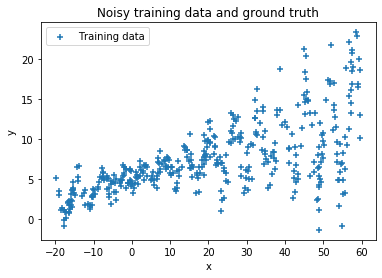

In [3]:
n_data = 500
n_train = 400
w0 = 0.125
b0 = 5.0
x_low, x_high = -20, 60

X, y = load_dataset(n_data, w0, b0, x_low, x_high)
X = np.expand_dims(X, 1)
y = np.expand_dims(y, 1)

idx_randperm = np.random.permutation(n_data)
idx_train = np.sort(idx_randperm[:n_train])
idx_test = np.sort(idx_randperm[n_train:])

X_train, y_train = X[idx_train], y[idx_train]
X_test = X[idx_test]

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)

plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Traditional point-estimate neural network

In [4]:
def neg_log_likelihood_with_dist(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

In [5]:
batch_size = 100
n_epochs = 3000
lr = 1e-3

def build_point_estimate_model(scale=1):
    model_in = Input(shape=(1,))
    x = Dense(16)(model_in)
    x = LeakyReLU(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(16)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(1)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale))(x)
    model = Model(model_in, model_out)
    return model

pe_model = build_point_estimate_model()
pe_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
pe_model.summary()
hist = pe_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

W0802 11:45:30.379008  9476 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0     

Epoch 94/3000
400/400 - 0s - loss: 6.8463 - mean_squared_error: 13.0585
Epoch 95/3000
400/400 - 0s - loss: 6.8699 - mean_squared_error: 13.8310
Epoch 96/3000
400/400 - 0s - loss: 6.8850 - mean_squared_error: 13.3959
Epoch 97/3000
400/400 - 0s - loss: 6.9066 - mean_squared_error: 13.3076
Epoch 98/3000
400/400 - 0s - loss: 6.8581 - mean_squared_error: 13.5761
Epoch 99/3000
400/400 - 0s - loss: 6.8463 - mean_squared_error: 13.0863
Epoch 100/3000
400/400 - 0s - loss: 6.8350 - mean_squared_error: 12.2528
Epoch 101/3000
400/400 - 0s - loss: 6.8370 - mean_squared_error: 13.3676
Epoch 102/3000
400/400 - 0s - loss: 6.8365 - mean_squared_error: 12.1756
Epoch 103/3000
400/400 - 0s - loss: 6.8156 - mean_squared_error: 13.3374
Epoch 104/3000
400/400 - 0s - loss: 6.8583 - mean_squared_error: 12.7749
Epoch 105/3000
400/400 - 0s - loss: 6.8479 - mean_squared_error: 12.5506
Epoch 106/3000
400/400 - 0s - loss: 6.8244 - mean_squared_error: 12.4682
Epoch 107/3000
400/400 - 0s - loss: 6.8618 - mean_squared

Epoch 207/3000
400/400 - 0s - loss: 6.8437 - mean_squared_error: 12.9184
Epoch 208/3000
400/400 - 0s - loss: 6.8402 - mean_squared_error: 13.0398
Epoch 209/3000
400/400 - 0s - loss: 6.8429 - mean_squared_error: 13.2127
Epoch 210/3000
400/400 - 0s - loss: 6.8791 - mean_squared_error: 13.4091
Epoch 211/3000
400/400 - 0s - loss: 6.8579 - mean_squared_error: 12.8666
Epoch 212/3000
400/400 - 0s - loss: 6.8668 - mean_squared_error: 13.2798
Epoch 213/3000
400/400 - 0s - loss: 6.8299 - mean_squared_error: 12.6903
Epoch 214/3000
400/400 - 0s - loss: 6.8433 - mean_squared_error: 12.7979
Epoch 215/3000
400/400 - 0s - loss: 6.8336 - mean_squared_error: 12.1537
Epoch 216/3000
400/400 - 0s - loss: 6.9009 - mean_squared_error: 13.1144
Epoch 217/3000
400/400 - 0s - loss: 6.8291 - mean_squared_error: 13.0069
Epoch 218/3000
400/400 - 0s - loss: 6.8733 - mean_squared_error: 13.7276
Epoch 219/3000
400/400 - 0s - loss: 6.9134 - mean_squared_error: 12.5396
Epoch 220/3000
400/400 - 0s - loss: 6.8704 - mean_s

Epoch 320/3000
400/400 - 0s - loss: 6.8485 - mean_squared_error: 13.3343
Epoch 321/3000
400/400 - 0s - loss: 6.8671 - mean_squared_error: 13.1365
Epoch 322/3000
400/400 - 0s - loss: 6.8523 - mean_squared_error: 12.5033
Epoch 323/3000
400/400 - 0s - loss: 6.8541 - mean_squared_error: 12.5288
Epoch 324/3000
400/400 - 0s - loss: 6.8567 - mean_squared_error: 12.5960
Epoch 325/3000
400/400 - 0s - loss: 6.8600 - mean_squared_error: 12.9315
Epoch 326/3000
400/400 - 0s - loss: 6.8566 - mean_squared_error: 12.3856
Epoch 327/3000
400/400 - 0s - loss: 6.8213 - mean_squared_error: 12.8394
Epoch 328/3000
400/400 - 0s - loss: 6.8560 - mean_squared_error: 12.8555
Epoch 329/3000
400/400 - 0s - loss: 6.8531 - mean_squared_error: 13.1803
Epoch 330/3000
400/400 - 0s - loss: 6.8788 - mean_squared_error: 13.1048
Epoch 331/3000
400/400 - 0s - loss: 6.8704 - mean_squared_error: 12.8238
Epoch 332/3000
400/400 - 0s - loss: 6.8828 - mean_squared_error: 12.9690
Epoch 333/3000
400/400 - 0s - loss: 6.8397 - mean_s

Epoch 433/3000
400/400 - 0s - loss: 6.8409 - mean_squared_error: 12.6946
Epoch 434/3000
400/400 - 0s - loss: 6.8501 - mean_squared_error: 12.5467
Epoch 435/3000
400/400 - 0s - loss: 6.8254 - mean_squared_error: 12.5062
Epoch 436/3000
400/400 - 0s - loss: 6.8210 - mean_squared_error: 13.2479
Epoch 437/3000
400/400 - 0s - loss: 6.8176 - mean_squared_error: 12.7342
Epoch 438/3000
400/400 - 0s - loss: 6.8260 - mean_squared_error: 12.3156
Epoch 439/3000
400/400 - 0s - loss: 6.8166 - mean_squared_error: 12.9317
Epoch 440/3000
400/400 - 0s - loss: 6.8210 - mean_squared_error: 13.1883
Epoch 441/3000
400/400 - 0s - loss: 6.8281 - mean_squared_error: 13.0545
Epoch 442/3000
400/400 - 0s - loss: 6.8253 - mean_squared_error: 12.7764
Epoch 443/3000
400/400 - 0s - loss: 6.8189 - mean_squared_error: 12.5055
Epoch 444/3000
400/400 - 0s - loss: 6.8176 - mean_squared_error: 12.4256
Epoch 445/3000
400/400 - 0s - loss: 6.8399 - mean_squared_error: 12.7186
Epoch 446/3000
400/400 - 0s - loss: 6.8254 - mean_s

Epoch 546/3000
400/400 - 0s - loss: 6.8430 - mean_squared_error: 12.3531
Epoch 547/3000
400/400 - 0s - loss: 6.8598 - mean_squared_error: 12.6325
Epoch 548/3000
400/400 - 0s - loss: 6.8173 - mean_squared_error: 12.9355
Epoch 549/3000
400/400 - 0s - loss: 6.8338 - mean_squared_error: 12.6681
Epoch 550/3000
400/400 - 0s - loss: 6.8207 - mean_squared_error: 12.7460
Epoch 551/3000
400/400 - 0s - loss: 6.8126 - mean_squared_error: 12.7304
Epoch 552/3000
400/400 - 0s - loss: 6.8009 - mean_squared_error: 12.6031
Epoch 553/3000
400/400 - 0s - loss: 6.8491 - mean_squared_error: 12.5509
Epoch 554/3000
400/400 - 0s - loss: 6.8246 - mean_squared_error: 13.6206
Epoch 555/3000
400/400 - 0s - loss: 6.8172 - mean_squared_error: 12.8002
Epoch 556/3000
400/400 - 0s - loss: 6.8846 - mean_squared_error: 12.2451
Epoch 557/3000
400/400 - 0s - loss: 6.8114 - mean_squared_error: 12.0735
Epoch 558/3000
400/400 - 0s - loss: 6.8469 - mean_squared_error: 13.3945
Epoch 559/3000
400/400 - 0s - loss: 6.8115 - mean_s

Epoch 659/3000
400/400 - 0s - loss: 6.8178 - mean_squared_error: 13.0671
Epoch 660/3000
400/400 - 0s - loss: 6.8278 - mean_squared_error: 12.8038
Epoch 661/3000
400/400 - 0s - loss: 6.8165 - mean_squared_error: 12.5751
Epoch 662/3000
400/400 - 0s - loss: 6.8203 - mean_squared_error: 12.9982
Epoch 663/3000
400/400 - 0s - loss: 6.8195 - mean_squared_error: 13.0852
Epoch 664/3000
400/400 - 0s - loss: 6.8532 - mean_squared_error: 12.6491
Epoch 665/3000
400/400 - 0s - loss: 6.8281 - mean_squared_error: 12.6174
Epoch 666/3000
400/400 - 0s - loss: 6.8380 - mean_squared_error: 13.1654
Epoch 667/3000
400/400 - 0s - loss: 6.8230 - mean_squared_error: 12.4731
Epoch 668/3000
400/400 - 0s - loss: 6.8163 - mean_squared_error: 12.7562
Epoch 669/3000
400/400 - 0s - loss: 6.7969 - mean_squared_error: 12.7610
Epoch 670/3000
400/400 - 0s - loss: 6.8189 - mean_squared_error: 13.1728
Epoch 671/3000
400/400 - 0s - loss: 6.8670 - mean_squared_error: 12.6998
Epoch 672/3000
400/400 - 0s - loss: 6.9907 - mean_s

Epoch 772/3000
400/400 - 0s - loss: 6.8014 - mean_squared_error: 12.8023
Epoch 773/3000
400/400 - 0s - loss: 6.8097 - mean_squared_error: 13.5003
Epoch 774/3000
400/400 - 0s - loss: 6.8033 - mean_squared_error: 12.5432
Epoch 775/3000
400/400 - 0s - loss: 6.8241 - mean_squared_error: 13.2870
Epoch 776/3000
400/400 - 0s - loss: 6.8842 - mean_squared_error: 13.0573
Epoch 777/3000
400/400 - 0s - loss: 6.8351 - mean_squared_error: 12.6855
Epoch 778/3000
400/400 - 0s - loss: 6.8119 - mean_squared_error: 12.8436
Epoch 779/3000
400/400 - 0s - loss: 6.7975 - mean_squared_error: 12.8448
Epoch 780/3000
400/400 - 0s - loss: 6.8274 - mean_squared_error: 12.4072
Epoch 781/3000
400/400 - 0s - loss: 6.8046 - mean_squared_error: 12.4128
Epoch 782/3000
400/400 - 0s - loss: 6.8079 - mean_squared_error: 13.0869
Epoch 783/3000
400/400 - 0s - loss: 6.8434 - mean_squared_error: 13.0822
Epoch 784/3000
400/400 - 0s - loss: 6.8196 - mean_squared_error: 12.1801
Epoch 785/3000
400/400 - 0s - loss: 6.8134 - mean_s

Epoch 885/3000
400/400 - 0s - loss: 6.8139 - mean_squared_error: 11.9179
Epoch 886/3000
400/400 - 0s - loss: 6.8088 - mean_squared_error: 12.1908
Epoch 887/3000
400/400 - 0s - loss: 6.7974 - mean_squared_error: 12.3201
Epoch 888/3000
400/400 - 0s - loss: 6.8119 - mean_squared_error: 13.2893
Epoch 889/3000
400/400 - 0s - loss: 6.8202 - mean_squared_error: 12.6572
Epoch 890/3000
400/400 - 0s - loss: 6.8173 - mean_squared_error: 12.7091
Epoch 891/3000
400/400 - 0s - loss: 6.7868 - mean_squared_error: 12.8499
Epoch 892/3000
400/400 - 0s - loss: 6.7983 - mean_squared_error: 13.0459
Epoch 893/3000
400/400 - 0s - loss: 6.8130 - mean_squared_error: 12.8239
Epoch 894/3000
400/400 - 0s - loss: 6.7947 - mean_squared_error: 12.4794
Epoch 895/3000
400/400 - 0s - loss: 6.8390 - mean_squared_error: 13.4690
Epoch 896/3000
400/400 - 0s - loss: 6.8091 - mean_squared_error: 13.1408
Epoch 897/3000
400/400 - 0s - loss: 6.8178 - mean_squared_error: 12.1463
Epoch 898/3000
400/400 - 0s - loss: 6.7980 - mean_s

Epoch 998/3000
400/400 - 0s - loss: 6.8011 - mean_squared_error: 12.3564
Epoch 999/3000
400/400 - 0s - loss: 6.8544 - mean_squared_error: 12.9647
Epoch 1000/3000
400/400 - 0s - loss: 6.8061 - mean_squared_error: 12.6973
Epoch 1001/3000
400/400 - 0s - loss: 6.8529 - mean_squared_error: 13.5566
Epoch 1002/3000
400/400 - 0s - loss: 6.8014 - mean_squared_error: 12.2069
Epoch 1003/3000
400/400 - 0s - loss: 6.8354 - mean_squared_error: 12.4168
Epoch 1004/3000
400/400 - 0s - loss: 6.7821 - mean_squared_error: 12.5479
Epoch 1005/3000
400/400 - 0s - loss: 6.8033 - mean_squared_error: 12.5385
Epoch 1006/3000
400/400 - 0s - loss: 6.7838 - mean_squared_error: 12.4755
Epoch 1007/3000
400/400 - 0s - loss: 6.7746 - mean_squared_error: 12.3216
Epoch 1008/3000
400/400 - 0s - loss: 6.8419 - mean_squared_error: 13.0755
Epoch 1009/3000
400/400 - 0s - loss: 6.7845 - mean_squared_error: 12.4496
Epoch 1010/3000
400/400 - 0s - loss: 6.8100 - mean_squared_error: 12.8766
Epoch 1011/3000
400/400 - 0s - loss: 6.7

Epoch 1109/3000
400/400 - 0s - loss: 6.8024 - mean_squared_error: 13.5779
Epoch 1110/3000
400/400 - 0s - loss: 6.7793 - mean_squared_error: 12.2276
Epoch 1111/3000
400/400 - 0s - loss: 6.7828 - mean_squared_error: 12.6267
Epoch 1112/3000
400/400 - 0s - loss: 6.7932 - mean_squared_error: 12.8606
Epoch 1113/3000
400/400 - 0s - loss: 6.8486 - mean_squared_error: 13.5061
Epoch 1114/3000
400/400 - 0s - loss: 6.8036 - mean_squared_error: 12.5797
Epoch 1115/3000
400/400 - 0s - loss: 6.8062 - mean_squared_error: 12.9789
Epoch 1116/3000
400/400 - 0s - loss: 6.8222 - mean_squared_error: 12.5773
Epoch 1117/3000
400/400 - 0s - loss: 6.8078 - mean_squared_error: 12.8603
Epoch 1118/3000
400/400 - 0s - loss: 6.7816 - mean_squared_error: 12.4385
Epoch 1119/3000
400/400 - 0s - loss: 6.7704 - mean_squared_error: 13.0197
Epoch 1120/3000
400/400 - 0s - loss: 6.7743 - mean_squared_error: 11.9244
Epoch 1121/3000
400/400 - 0s - loss: 6.7926 - mean_squared_error: 13.1466
Epoch 1122/3000
400/400 - 0s - loss: 6

Epoch 1220/3000
400/400 - 0s - loss: 6.7848 - mean_squared_error: 12.3930
Epoch 1221/3000
400/400 - 0s - loss: 6.7906 - mean_squared_error: 12.6308
Epoch 1222/3000
400/400 - 0s - loss: 6.7843 - mean_squared_error: 13.1908
Epoch 1223/3000
400/400 - 0s - loss: 6.7909 - mean_squared_error: 12.8125
Epoch 1224/3000
400/400 - 0s - loss: 6.7863 - mean_squared_error: 12.7735
Epoch 1225/3000
400/400 - 0s - loss: 6.7751 - mean_squared_error: 12.9960
Epoch 1226/3000
400/400 - 0s - loss: 6.7713 - mean_squared_error: 12.6474
Epoch 1227/3000
400/400 - 0s - loss: 6.7639 - mean_squared_error: 12.0067
Epoch 1228/3000
400/400 - 0s - loss: 6.7852 - mean_squared_error: 12.4391
Epoch 1229/3000
400/400 - 0s - loss: 6.7944 - mean_squared_error: 12.9611
Epoch 1230/3000
400/400 - 0s - loss: 6.7712 - mean_squared_error: 12.1944
Epoch 1231/3000
400/400 - 0s - loss: 6.8046 - mean_squared_error: 13.1877
Epoch 1232/3000
400/400 - 0s - loss: 6.7810 - mean_squared_error: 12.9272
Epoch 1233/3000
400/400 - 0s - loss: 6

Epoch 1331/3000
400/400 - 0s - loss: 6.7689 - mean_squared_error: 12.4394
Epoch 1332/3000
400/400 - 0s - loss: 6.8079 - mean_squared_error: 12.7099
Epoch 1333/3000
400/400 - 0s - loss: 6.7552 - mean_squared_error: 12.9582
Epoch 1334/3000
400/400 - 0s - loss: 6.7855 - mean_squared_error: 12.8274
Epoch 1335/3000
400/400 - 0s - loss: 6.7626 - mean_squared_error: 13.0420
Epoch 1336/3000
400/400 - 0s - loss: 6.7467 - mean_squared_error: 12.2055
Epoch 1337/3000
400/400 - 0s - loss: 6.7766 - mean_squared_error: 12.8727
Epoch 1338/3000
400/400 - 0s - loss: 6.7773 - mean_squared_error: 13.3830
Epoch 1339/3000
400/400 - 0s - loss: 6.7731 - mean_squared_error: 12.9148
Epoch 1340/3000
400/400 - 0s - loss: 6.7991 - mean_squared_error: 12.7425
Epoch 1341/3000
400/400 - 0s - loss: 6.7799 - mean_squared_error: 12.8904
Epoch 1342/3000
400/400 - 0s - loss: 6.7634 - mean_squared_error: 12.9399
Epoch 1343/3000
400/400 - 0s - loss: 6.7818 - mean_squared_error: 12.5880
Epoch 1344/3000
400/400 - 0s - loss: 6

Epoch 1442/3000
400/400 - 0s - loss: 6.7471 - mean_squared_error: 12.2853
Epoch 1443/3000
400/400 - 0s - loss: 6.7870 - mean_squared_error: 12.5325
Epoch 1444/3000
400/400 - 0s - loss: 6.7751 - mean_squared_error: 12.0428
Epoch 1445/3000
400/400 - 0s - loss: 6.7659 - mean_squared_error: 12.2761
Epoch 1446/3000
400/400 - 0s - loss: 6.7688 - mean_squared_error: 13.0426
Epoch 1447/3000
400/400 - 0s - loss: 6.7771 - mean_squared_error: 12.9301
Epoch 1448/3000
400/400 - 0s - loss: 6.7464 - mean_squared_error: 13.1066
Epoch 1449/3000
400/400 - 0s - loss: 6.7826 - mean_squared_error: 12.5612
Epoch 1450/3000
400/400 - 0s - loss: 6.7782 - mean_squared_error: 12.9939
Epoch 1451/3000
400/400 - 0s - loss: 6.7513 - mean_squared_error: 12.4498
Epoch 1452/3000
400/400 - 0s - loss: 6.8064 - mean_squared_error: 13.0235
Epoch 1453/3000
400/400 - 0s - loss: 6.7802 - mean_squared_error: 13.0225
Epoch 1454/3000
400/400 - 0s - loss: 6.7816 - mean_squared_error: 12.9607
Epoch 1455/3000
400/400 - 0s - loss: 6

Epoch 1553/3000
400/400 - 0s - loss: 6.7609 - mean_squared_error: 11.8456
Epoch 1554/3000
400/400 - 0s - loss: 6.7707 - mean_squared_error: 12.5144
Epoch 1555/3000
400/400 - 0s - loss: 6.7632 - mean_squared_error: 13.1133
Epoch 1556/3000
400/400 - 0s - loss: 6.7673 - mean_squared_error: 11.6843
Epoch 1557/3000
400/400 - 0s - loss: 6.8380 - mean_squared_error: 12.8201
Epoch 1558/3000
400/400 - 0s - loss: 6.7396 - mean_squared_error: 12.6537
Epoch 1559/3000
400/400 - 0s - loss: 6.7470 - mean_squared_error: 12.5662
Epoch 1560/3000
400/400 - 0s - loss: 6.7425 - mean_squared_error: 11.9836
Epoch 1561/3000
400/400 - 0s - loss: 6.7228 - mean_squared_error: 12.7627
Epoch 1562/3000
400/400 - 0s - loss: 6.7283 - mean_squared_error: 11.7959
Epoch 1563/3000
400/400 - 0s - loss: 6.7463 - mean_squared_error: 12.7313
Epoch 1564/3000
400/400 - 0s - loss: 6.7288 - mean_squared_error: 12.0043
Epoch 1565/3000
400/400 - 0s - loss: 6.7290 - mean_squared_error: 13.1101
Epoch 1566/3000
400/400 - 0s - loss: 6

Epoch 1664/3000
400/400 - 0s - loss: 6.7330 - mean_squared_error: 13.1196
Epoch 1665/3000
400/400 - 0s - loss: 6.7567 - mean_squared_error: 12.4259
Epoch 1666/3000
400/400 - 0s - loss: 6.7432 - mean_squared_error: 13.0937
Epoch 1667/3000
400/400 - 0s - loss: 6.7389 - mean_squared_error: 13.1831
Epoch 1668/3000
400/400 - 0s - loss: 6.7366 - mean_squared_error: 13.0309
Epoch 1669/3000
400/400 - 0s - loss: 6.7637 - mean_squared_error: 12.7234
Epoch 1670/3000
400/400 - 0s - loss: 6.7173 - mean_squared_error: 12.4310
Epoch 1671/3000
400/400 - 0s - loss: 6.7385 - mean_squared_error: 13.1695
Epoch 1672/3000
400/400 - 0s - loss: 6.7412 - mean_squared_error: 12.0065
Epoch 1673/3000
400/400 - 0s - loss: 6.7278 - mean_squared_error: 12.3471
Epoch 1674/3000
400/400 - 0s - loss: 6.7143 - mean_squared_error: 11.8919
Epoch 1675/3000
400/400 - 0s - loss: 6.7233 - mean_squared_error: 12.4234
Epoch 1676/3000
400/400 - 0s - loss: 6.7170 - mean_squared_error: 12.7686
Epoch 1677/3000
400/400 - 0s - loss: 6

Epoch 1775/3000
400/400 - 0s - loss: 6.6977 - mean_squared_error: 12.9212
Epoch 1776/3000
400/400 - 0s - loss: 6.7200 - mean_squared_error: 12.8423
Epoch 1777/3000
400/400 - 0s - loss: 6.7277 - mean_squared_error: 12.5783
Epoch 1778/3000
400/400 - 0s - loss: 6.6777 - mean_squared_error: 12.4595
Epoch 1779/3000
400/400 - 0s - loss: 6.7019 - mean_squared_error: 12.3200
Epoch 1780/3000
400/400 - 0s - loss: 6.7280 - mean_squared_error: 13.0910
Epoch 1781/3000
400/400 - 0s - loss: 6.7193 - mean_squared_error: 12.6140
Epoch 1782/3000
400/400 - 0s - loss: 6.7285 - mean_squared_error: 12.7953
Epoch 1783/3000
400/400 - 0s - loss: 6.7154 - mean_squared_error: 12.8081
Epoch 1784/3000
400/400 - 0s - loss: 6.6941 - mean_squared_error: 13.0251
Epoch 1785/3000
400/400 - 0s - loss: 6.7046 - mean_squared_error: 13.1008
Epoch 1786/3000
400/400 - 0s - loss: 6.7166 - mean_squared_error: 12.7592
Epoch 1787/3000
400/400 - 0s - loss: 6.7048 - mean_squared_error: 12.4644
Epoch 1788/3000
400/400 - 0s - loss: 6

Epoch 1886/3000
400/400 - 0s - loss: 6.7148 - mean_squared_error: 12.9919
Epoch 1887/3000
400/400 - 0s - loss: 6.6764 - mean_squared_error: 12.6469
Epoch 1888/3000
400/400 - 0s - loss: 6.7157 - mean_squared_error: 12.0418
Epoch 1889/3000
400/400 - 0s - loss: 6.7204 - mean_squared_error: 12.6589
Epoch 1890/3000
400/400 - 0s - loss: 6.7565 - mean_squared_error: 12.8007
Epoch 1891/3000
400/400 - 0s - loss: 6.6866 - mean_squared_error: 12.8534
Epoch 1892/3000
400/400 - 0s - loss: 6.6760 - mean_squared_error: 13.0269
Epoch 1893/3000
400/400 - 0s - loss: 6.6914 - mean_squared_error: 12.6860
Epoch 1894/3000
400/400 - 0s - loss: 6.6786 - mean_squared_error: 12.4336
Epoch 1895/3000
400/400 - 0s - loss: 6.6885 - mean_squared_error: 12.3884
Epoch 1896/3000
400/400 - 0s - loss: 6.6635 - mean_squared_error: 12.4928
Epoch 1897/3000
400/400 - 0s - loss: 6.6998 - mean_squared_error: 12.2346
Epoch 1898/3000
400/400 - 0s - loss: 6.6589 - mean_squared_error: 13.3236
Epoch 1899/3000
400/400 - 0s - loss: 6

Epoch 1997/3000
400/400 - 0s - loss: 6.6404 - mean_squared_error: 12.0788
Epoch 1998/3000
400/400 - 0s - loss: 6.6574 - mean_squared_error: 12.1391
Epoch 1999/3000
400/400 - 0s - loss: 6.6426 - mean_squared_error: 12.0493
Epoch 2000/3000
400/400 - 0s - loss: 6.6224 - mean_squared_error: 11.2732
Epoch 2001/3000
400/400 - 0s - loss: 6.6329 - mean_squared_error: 12.8141
Epoch 2002/3000
400/400 - 0s - loss: 6.6490 - mean_squared_error: 12.6472
Epoch 2003/3000
400/400 - 0s - loss: 6.6394 - mean_squared_error: 13.1794
Epoch 2004/3000
400/400 - 0s - loss: 6.6473 - mean_squared_error: 12.1217
Epoch 2005/3000
400/400 - 0s - loss: 6.6373 - mean_squared_error: 12.5354
Epoch 2006/3000
400/400 - 0s - loss: 6.6525 - mean_squared_error: 12.0542
Epoch 2007/3000
400/400 - 0s - loss: 6.6245 - mean_squared_error: 12.3957
Epoch 2008/3000
400/400 - 0s - loss: 6.6615 - mean_squared_error: 11.8137
Epoch 2009/3000
400/400 - 0s - loss: 6.6584 - mean_squared_error: 12.2285
Epoch 2010/3000
400/400 - 0s - loss: 6

Epoch 2108/3000
400/400 - 0s - loss: 6.6822 - mean_squared_error: 13.0117
Epoch 2109/3000
400/400 - 0s - loss: 6.6541 - mean_squared_error: 12.5394
Epoch 2110/3000
400/400 - 0s - loss: 6.6295 - mean_squared_error: 12.8584
Epoch 2111/3000
400/400 - 0s - loss: 6.6280 - mean_squared_error: 12.7492
Epoch 2112/3000
400/400 - 0s - loss: 6.6153 - mean_squared_error: 12.6940
Epoch 2113/3000
400/400 - 0s - loss: 6.6835 - mean_squared_error: 11.8649
Epoch 2114/3000
400/400 - 0s - loss: 6.6871 - mean_squared_error: 12.2603
Epoch 2115/3000
400/400 - 0s - loss: 6.6567 - mean_squared_error: 12.3442
Epoch 2116/3000
400/400 - 0s - loss: 6.6073 - mean_squared_error: 12.6122
Epoch 2117/3000
400/400 - 0s - loss: 6.6428 - mean_squared_error: 12.6770
Epoch 2118/3000
400/400 - 0s - loss: 6.6023 - mean_squared_error: 11.8734
Epoch 2119/3000
400/400 - 0s - loss: 6.6044 - mean_squared_error: 12.1242
Epoch 2120/3000
400/400 - 0s - loss: 6.7085 - mean_squared_error: 12.6933
Epoch 2121/3000
400/400 - 0s - loss: 6

Epoch 2219/3000
400/400 - 0s - loss: 6.6218 - mean_squared_error: 12.6168
Epoch 2220/3000
400/400 - 0s - loss: 6.5971 - mean_squared_error: 12.8316
Epoch 2221/3000
400/400 - 0s - loss: 6.6015 - mean_squared_error: 12.0985
Epoch 2222/3000
400/400 - 0s - loss: 6.5960 - mean_squared_error: 12.5907
Epoch 2223/3000
400/400 - 0s - loss: 6.6561 - mean_squared_error: 12.5807
Epoch 2224/3000
400/400 - 0s - loss: 6.6178 - mean_squared_error: 12.4743
Epoch 2225/3000
400/400 - 0s - loss: 6.6113 - mean_squared_error: 13.0726
Epoch 2226/3000
400/400 - 0s - loss: 6.5944 - mean_squared_error: 11.9121
Epoch 2227/3000
400/400 - 0s - loss: 6.6195 - mean_squared_error: 11.8014
Epoch 2228/3000
400/400 - 0s - loss: 6.7097 - mean_squared_error: 12.7736
Epoch 2229/3000
400/400 - 0s - loss: 6.5777 - mean_squared_error: 12.4601
Epoch 2230/3000
400/400 - 0s - loss: 6.6302 - mean_squared_error: 12.7840
Epoch 2231/3000
400/400 - 0s - loss: 6.6345 - mean_squared_error: 13.2242
Epoch 2232/3000
400/400 - 0s - loss: 6

Epoch 2330/3000
400/400 - 0s - loss: 6.5523 - mean_squared_error: 12.0003
Epoch 2331/3000
400/400 - 0s - loss: 6.6244 - mean_squared_error: 12.0049
Epoch 2332/3000
400/400 - 0s - loss: 6.6904 - mean_squared_error: 12.1754
Epoch 2333/3000
400/400 - 0s - loss: 6.6291 - mean_squared_error: 12.8633
Epoch 2334/3000
400/400 - 0s - loss: 6.6013 - mean_squared_error: 12.7132
Epoch 2335/3000
400/400 - 0s - loss: 6.5855 - mean_squared_error: 11.7930
Epoch 2336/3000
400/400 - 0s - loss: 6.6133 - mean_squared_error: 12.3969
Epoch 2337/3000
400/400 - 0s - loss: 6.5857 - mean_squared_error: 12.3687
Epoch 2338/3000
400/400 - 0s - loss: 6.5704 - mean_squared_error: 12.3410
Epoch 2339/3000
400/400 - 0s - loss: 6.6482 - mean_squared_error: 12.4181
Epoch 2340/3000
400/400 - 0s - loss: 6.6861 - mean_squared_error: 12.6696
Epoch 2341/3000
400/400 - 0s - loss: 6.5610 - mean_squared_error: 11.9322
Epoch 2342/3000
400/400 - 0s - loss: 6.6498 - mean_squared_error: 11.9851
Epoch 2343/3000
400/400 - 0s - loss: 6

Epoch 2441/3000
400/400 - 0s - loss: 6.5393 - mean_squared_error: 12.4343
Epoch 2442/3000
400/400 - 0s - loss: 6.5617 - mean_squared_error: 12.2502
Epoch 2443/3000
400/400 - 0s - loss: 6.5490 - mean_squared_error: 12.1433
Epoch 2444/3000
400/400 - 0s - loss: 6.6137 - mean_squared_error: 12.9040
Epoch 2445/3000
400/400 - 0s - loss: 6.5616 - mean_squared_error: 11.9951
Epoch 2446/3000
400/400 - 0s - loss: 6.6453 - mean_squared_error: 12.4631
Epoch 2447/3000
400/400 - 0s - loss: 6.6381 - mean_squared_error: 12.2121
Epoch 2448/3000
400/400 - 0s - loss: 6.5895 - mean_squared_error: 12.7552
Epoch 2449/3000
400/400 - 0s - loss: 6.6162 - mean_squared_error: 12.1688
Epoch 2450/3000
400/400 - 0s - loss: 6.6238 - mean_squared_error: 12.8589
Epoch 2451/3000
400/400 - 0s - loss: 6.5685 - mean_squared_error: 11.8102
Epoch 2452/3000
400/400 - 0s - loss: 6.6240 - mean_squared_error: 12.3873
Epoch 2453/3000
400/400 - 0s - loss: 6.5320 - mean_squared_error: 12.0207
Epoch 2454/3000
400/400 - 0s - loss: 6

Epoch 2552/3000
400/400 - 0s - loss: 6.5540 - mean_squared_error: 12.4182
Epoch 2553/3000
400/400 - 0s - loss: 6.5317 - mean_squared_error: 12.4455
Epoch 2554/3000
400/400 - 0s - loss: 6.5194 - mean_squared_error: 12.3865
Epoch 2555/3000
400/400 - 0s - loss: 6.5964 - mean_squared_error: 12.4467
Epoch 2556/3000
400/400 - 0s - loss: 6.5600 - mean_squared_error: 11.8799
Epoch 2557/3000
400/400 - 0s - loss: 6.6488 - mean_squared_error: 12.3455
Epoch 2558/3000
400/400 - 0s - loss: 6.5963 - mean_squared_error: 13.1503
Epoch 2559/3000
400/400 - 0s - loss: 6.5540 - mean_squared_error: 12.3023
Epoch 2560/3000
400/400 - 0s - loss: 6.6734 - mean_squared_error: 13.6096
Epoch 2561/3000
400/400 - 0s - loss: 6.5186 - mean_squared_error: 11.9010
Epoch 2562/3000
400/400 - 0s - loss: 6.5055 - mean_squared_error: 12.0889
Epoch 2563/3000
400/400 - 0s - loss: 6.5203 - mean_squared_error: 11.8569
Epoch 2564/3000
400/400 - 0s - loss: 6.5165 - mean_squared_error: 11.8633
Epoch 2565/3000
400/400 - 0s - loss: 6

Epoch 2663/3000
400/400 - 0s - loss: 6.4965 - mean_squared_error: 12.6075
Epoch 2664/3000
400/400 - 0s - loss: 6.4935 - mean_squared_error: 12.6772
Epoch 2665/3000
400/400 - 0s - loss: 6.5073 - mean_squared_error: 12.8142
Epoch 2666/3000
400/400 - 0s - loss: 6.5497 - mean_squared_error: 12.0434
Epoch 2667/3000
400/400 - 0s - loss: 6.4818 - mean_squared_error: 11.6407
Epoch 2668/3000
400/400 - 0s - loss: 6.5297 - mean_squared_error: 11.7718
Epoch 2669/3000
400/400 - 0s - loss: 6.4760 - mean_squared_error: 12.1399
Epoch 2670/3000
400/400 - 0s - loss: 6.5884 - mean_squared_error: 13.1400
Epoch 2671/3000
400/400 - 0s - loss: 6.4733 - mean_squared_error: 11.8228
Epoch 2672/3000
400/400 - 0s - loss: 6.5120 - mean_squared_error: 12.0950
Epoch 2673/3000
400/400 - 0s - loss: 6.5651 - mean_squared_error: 12.0035
Epoch 2674/3000
400/400 - 0s - loss: 6.4759 - mean_squared_error: 12.2326
Epoch 2675/3000
400/400 - 0s - loss: 6.5038 - mean_squared_error: 12.3447
Epoch 2676/3000
400/400 - 0s - loss: 6

Epoch 2774/3000
400/400 - 0s - loss: 6.5784 - mean_squared_error: 12.9338
Epoch 2775/3000
400/400 - 0s - loss: 6.5558 - mean_squared_error: 11.7549
Epoch 2776/3000
400/400 - 0s - loss: 6.6935 - mean_squared_error: 13.1935
Epoch 2777/3000
400/400 - 0s - loss: 6.5245 - mean_squared_error: 12.4237
Epoch 2778/3000
400/400 - 0s - loss: 6.6003 - mean_squared_error: 12.7766
Epoch 2779/3000
400/400 - 0s - loss: 6.4793 - mean_squared_error: 12.2235
Epoch 2780/3000
400/400 - 0s - loss: 6.5734 - mean_squared_error: 12.4412
Epoch 2781/3000
400/400 - 0s - loss: 6.5756 - mean_squared_error: 12.1831
Epoch 2782/3000
400/400 - 0s - loss: 6.5805 - mean_squared_error: 12.8415
Epoch 2783/3000
400/400 - 0s - loss: 6.5695 - mean_squared_error: 12.8836
Epoch 2784/3000
400/400 - 0s - loss: 6.5910 - mean_squared_error: 12.5684
Epoch 2785/3000
400/400 - 0s - loss: 6.6544 - mean_squared_error: 12.5257
Epoch 2786/3000
400/400 - 0s - loss: 6.5091 - mean_squared_error: 12.6554
Epoch 2787/3000
400/400 - 0s - loss: 6

Epoch 2885/3000
400/400 - 0s - loss: 6.4774 - mean_squared_error: 11.8105
Epoch 2886/3000
400/400 - 0s - loss: 6.6081 - mean_squared_error: 12.5045
Epoch 2887/3000
400/400 - 0s - loss: 6.5839 - mean_squared_error: 12.0283
Epoch 2888/3000
400/400 - 0s - loss: 6.5424 - mean_squared_error: 11.6249
Epoch 2889/3000
400/400 - 0s - loss: 6.4977 - mean_squared_error: 11.8079
Epoch 2890/3000
400/400 - 0s - loss: 6.5861 - mean_squared_error: 12.6749
Epoch 2891/3000
400/400 - 0s - loss: 6.4467 - mean_squared_error: 11.9624
Epoch 2892/3000
400/400 - 0s - loss: 6.4667 - mean_squared_error: 12.8065
Epoch 2893/3000
400/400 - 0s - loss: 6.4576 - mean_squared_error: 12.1691
Epoch 2894/3000
400/400 - 0s - loss: 6.5038 - mean_squared_error: 11.7971
Epoch 2895/3000
400/400 - 0s - loss: 6.4524 - mean_squared_error: 12.3264
Epoch 2896/3000
400/400 - 0s - loss: 6.5574 - mean_squared_error: 12.5373
Epoch 2897/3000
400/400 - 0s - loss: 6.4176 - mean_squared_error: 12.0148
Epoch 2898/3000
400/400 - 0s - loss: 6

Epoch 2996/3000
400/400 - 0s - loss: 6.4745 - mean_squared_error: 12.2421
Epoch 2997/3000
400/400 - 0s - loss: 6.4385 - mean_squared_error: 11.4907
Epoch 2998/3000
400/400 - 0s - loss: 6.4664 - mean_squared_error: 12.1099
Epoch 2999/3000
400/400 - 0s - loss: 6.5798 - mean_squared_error: 12.1206
Epoch 3000/3000
400/400 - 0s - loss: 6.4898 - mean_squared_error: 11.7679


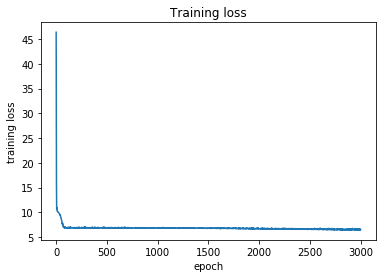

In [6]:
plt.plot(range(n_epochs), hist.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
y_test_pred_pe = pe_model(X_test)

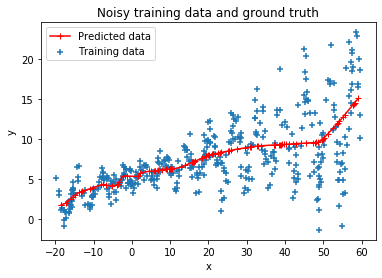

In [7]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test_pred_pe.mean(), 'r-', marker='+', label='Predicted data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate aleatoric uncertainty

In [8]:
def build_aleatoric_model():
    model_in = Input(shape=(1,))
    x = Dense(16)(model_in)
    x = LeakyReLU(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(16)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(1+1)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],
                                                        scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])))(x)
    model = Model(model_in, model_out)
    return model

al_model = build_aleatoric_model()
al_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
al_model.summary()
hist = al_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                32        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1088      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16)                0   

Epoch 93/3000
400/400 - 0s - loss: 3.1087 - mean_squared_error: 16.7631
Epoch 94/3000
400/400 - 0s - loss: 3.0179 - mean_squared_error: 15.0426
Epoch 95/3000
400/400 - 0s - loss: 3.0161 - mean_squared_error: 15.0707
Epoch 96/3000
400/400 - 0s - loss: 2.9833 - mean_squared_error: 14.4177
Epoch 97/3000
400/400 - 0s - loss: 2.9560 - mean_squared_error: 15.8588
Epoch 98/3000
400/400 - 0s - loss: 2.9685 - mean_squared_error: 14.6458
Epoch 99/3000
400/400 - 0s - loss: 2.9246 - mean_squared_error: 16.0862
Epoch 100/3000
400/400 - 0s - loss: 2.9105 - mean_squared_error: 15.6224
Epoch 101/3000
400/400 - 0s - loss: 2.8947 - mean_squared_error: 15.1208
Epoch 102/3000
400/400 - 0s - loss: 2.8703 - mean_squared_error: 14.5486
Epoch 103/3000
400/400 - 0s - loss: 2.8544 - mean_squared_error: 15.3162
Epoch 104/3000
400/400 - 0s - loss: 2.8282 - mean_squared_error: 15.1702
Epoch 105/3000
400/400 - 0s - loss: 2.8208 - mean_squared_error: 14.6225
Epoch 106/3000
400/400 - 0s - loss: 2.8116 - mean_squared_

Epoch 206/3000
400/400 - 0s - loss: 2.4279 - mean_squared_error: 19.7118
Epoch 207/3000
400/400 - 0s - loss: 2.4267 - mean_squared_error: 16.8638
Epoch 208/3000
400/400 - 0s - loss: 2.4222 - mean_squared_error: 23.0455
Epoch 209/3000
400/400 - 0s - loss: 2.4244 - mean_squared_error: 20.9946
Epoch 210/3000
400/400 - 0s - loss: 2.4207 - mean_squared_error: 17.2758
Epoch 211/3000
400/400 - 0s - loss: 2.4212 - mean_squared_error: 18.3278
Epoch 212/3000
400/400 - 0s - loss: 2.4168 - mean_squared_error: 18.6491
Epoch 213/3000
400/400 - 0s - loss: 2.4162 - mean_squared_error: 20.1995
Epoch 214/3000
400/400 - 0s - loss: 2.4255 - mean_squared_error: 18.9528
Epoch 215/3000
400/400 - 0s - loss: 2.4186 - mean_squared_error: 20.0725
Epoch 216/3000
400/400 - 0s - loss: 2.4143 - mean_squared_error: 20.5783
Epoch 217/3000
400/400 - 0s - loss: 2.4148 - mean_squared_error: 19.3276
Epoch 218/3000
400/400 - 0s - loss: 2.4124 - mean_squared_error: 20.0624
Epoch 219/3000
400/400 - 0s - loss: 2.4144 - mean_s

Epoch 319/3000
400/400 - 0s - loss: 2.3499 - mean_squared_error: 24.1589
Epoch 320/3000
400/400 - 0s - loss: 2.3478 - mean_squared_error: 24.3877
Epoch 321/3000
400/400 - 0s - loss: 2.3491 - mean_squared_error: 25.6706
Epoch 322/3000
400/400 - 0s - loss: 2.3469 - mean_squared_error: 18.6113
Epoch 323/3000
400/400 - 0s - loss: 2.3452 - mean_squared_error: 24.1627
Epoch 324/3000
400/400 - 0s - loss: 2.3447 - mean_squared_error: 25.1221
Epoch 325/3000
400/400 - 0s - loss: 2.3500 - mean_squared_error: 21.8798
Epoch 326/3000
400/400 - 0s - loss: 2.3439 - mean_squared_error: 19.7664
Epoch 327/3000
400/400 - 0s - loss: 2.3666 - mean_squared_error: 23.5862
Epoch 328/3000
400/400 - 0s - loss: 2.3532 - mean_squared_error: 24.0131
Epoch 329/3000
400/400 - 0s - loss: 2.3495 - mean_squared_error: 23.5974
Epoch 330/3000
400/400 - 0s - loss: 2.3458 - mean_squared_error: 21.8852
Epoch 331/3000
400/400 - 0s - loss: 2.3425 - mean_squared_error: 21.3662
Epoch 332/3000
400/400 - 0s - loss: 2.3485 - mean_s

Epoch 432/3000
400/400 - 0s - loss: 2.3085 - mean_squared_error: 25.1140
Epoch 433/3000
400/400 - 0s - loss: 2.3042 - mean_squared_error: 21.5580
Epoch 434/3000
400/400 - 0s - loss: 2.3055 - mean_squared_error: 23.9310
Epoch 435/3000
400/400 - 0s - loss: 2.3058 - mean_squared_error: 24.2191
Epoch 436/3000
400/400 - 0s - loss: 2.3054 - mean_squared_error: 22.9128
Epoch 437/3000
400/400 - 0s - loss: 2.3092 - mean_squared_error: 27.1234
Epoch 438/3000
400/400 - 0s - loss: 2.3039 - mean_squared_error: 22.5967
Epoch 439/3000
400/400 - 0s - loss: 2.3037 - mean_squared_error: 23.0359
Epoch 440/3000
400/400 - 0s - loss: 2.3044 - mean_squared_error: 23.8961
Epoch 441/3000
400/400 - 0s - loss: 2.3025 - mean_squared_error: 22.4372
Epoch 442/3000
400/400 - 0s - loss: 2.3163 - mean_squared_error: 24.1219
Epoch 443/3000
400/400 - 0s - loss: 2.3037 - mean_squared_error: 21.9438
Epoch 444/3000
400/400 - 0s - loss: 2.3085 - mean_squared_error: 22.9305
Epoch 445/3000
400/400 - 0s - loss: 2.3033 - mean_s

Epoch 545/3000
400/400 - 0s - loss: 2.2932 - mean_squared_error: 22.2136
Epoch 546/3000
400/400 - 0s - loss: 2.2905 - mean_squared_error: 21.3126
Epoch 547/3000
400/400 - 0s - loss: 2.2957 - mean_squared_error: 27.2920
Epoch 548/3000
400/400 - 0s - loss: 2.2978 - mean_squared_error: 22.7486
Epoch 549/3000
400/400 - 0s - loss: 2.2927 - mean_squared_error: 21.8059
Epoch 550/3000
400/400 - 0s - loss: 2.2896 - mean_squared_error: 26.5015
Epoch 551/3000
400/400 - 0s - loss: 2.3028 - mean_squared_error: 25.8587
Epoch 552/3000
400/400 - 0s - loss: 2.2964 - mean_squared_error: 25.7246
Epoch 553/3000
400/400 - 0s - loss: 2.2961 - mean_squared_error: 25.5513
Epoch 554/3000
400/400 - 0s - loss: 2.2945 - mean_squared_error: 24.6869
Epoch 555/3000
400/400 - 0s - loss: 2.2840 - mean_squared_error: 25.6369
Epoch 556/3000
400/400 - 0s - loss: 2.2893 - mean_squared_error: 22.2540
Epoch 557/3000
400/400 - 0s - loss: 2.2863 - mean_squared_error: 23.8579
Epoch 558/3000
400/400 - 0s - loss: 2.2847 - mean_s

Epoch 658/3000
400/400 - 0s - loss: 2.2805 - mean_squared_error: 22.1355
Epoch 659/3000
400/400 - 0s - loss: 2.2831 - mean_squared_error: 21.0533
Epoch 660/3000
400/400 - 0s - loss: 2.2796 - mean_squared_error: 19.3737
Epoch 661/3000
400/400 - 0s - loss: 2.2785 - mean_squared_error: 22.6283
Epoch 662/3000
400/400 - 0s - loss: 2.2816 - mean_squared_error: 24.4121
Epoch 663/3000
400/400 - 0s - loss: 2.2820 - mean_squared_error: 22.7678
Epoch 664/3000
400/400 - 0s - loss: 2.2789 - mean_squared_error: 25.5188
Epoch 665/3000
400/400 - 0s - loss: 2.2794 - mean_squared_error: 24.2321
Epoch 666/3000
400/400 - 0s - loss: 2.2876 - mean_squared_error: 22.4037
Epoch 667/3000
400/400 - 0s - loss: 2.2864 - mean_squared_error: 26.9181
Epoch 668/3000
400/400 - 0s - loss: 2.2798 - mean_squared_error: 22.3170
Epoch 669/3000
400/400 - 0s - loss: 2.2886 - mean_squared_error: 24.1085
Epoch 670/3000
400/400 - 0s - loss: 2.2895 - mean_squared_error: 22.9205
Epoch 671/3000
400/400 - 0s - loss: 2.2861 - mean_s

Epoch 771/3000
400/400 - 0s - loss: 2.2746 - mean_squared_error: 24.2526
Epoch 772/3000
400/400 - 0s - loss: 2.2752 - mean_squared_error: 23.6199
Epoch 773/3000
400/400 - 0s - loss: 2.2765 - mean_squared_error: 24.9141
Epoch 774/3000
400/400 - 0s - loss: 2.2830 - mean_squared_error: 26.9640
Epoch 775/3000
400/400 - 0s - loss: 2.2731 - mean_squared_error: 22.7140
Epoch 776/3000
400/400 - 0s - loss: 2.2803 - mean_squared_error: 25.3396
Epoch 777/3000
400/400 - 0s - loss: 2.2763 - mean_squared_error: 24.6173
Epoch 778/3000
400/400 - 0s - loss: 2.2799 - mean_squared_error: 25.8959
Epoch 779/3000
400/400 - 0s - loss: 2.2764 - mean_squared_error: 21.3369
Epoch 780/3000
400/400 - 0s - loss: 2.2800 - mean_squared_error: 24.3514
Epoch 781/3000
400/400 - 0s - loss: 2.2825 - mean_squared_error: 25.0973
Epoch 782/3000
400/400 - 0s - loss: 2.2769 - mean_squared_error: 21.4517
Epoch 783/3000
400/400 - 0s - loss: 2.2825 - mean_squared_error: 26.1343
Epoch 784/3000
400/400 - 0s - loss: 2.2724 - mean_s

Epoch 884/3000
400/400 - 0s - loss: 2.2740 - mean_squared_error: 20.7085
Epoch 885/3000
400/400 - 0s - loss: 2.2783 - mean_squared_error: 23.1851
Epoch 886/3000
400/400 - 0s - loss: 2.2768 - mean_squared_error: 23.7791
Epoch 887/3000
400/400 - 0s - loss: 2.2733 - mean_squared_error: 24.8377
Epoch 888/3000
400/400 - 0s - loss: 2.2736 - mean_squared_error: 26.3548
Epoch 889/3000
400/400 - 0s - loss: 2.2743 - mean_squared_error: 26.7427
Epoch 890/3000
400/400 - 0s - loss: 2.2764 - mean_squared_error: 21.9571
Epoch 891/3000
400/400 - 0s - loss: 2.2735 - mean_squared_error: 22.7094
Epoch 892/3000
400/400 - 0s - loss: 2.2758 - mean_squared_error: 23.0145
Epoch 893/3000
400/400 - 0s - loss: 2.2751 - mean_squared_error: 24.8940
Epoch 894/3000
400/400 - 0s - loss: 2.2778 - mean_squared_error: 25.2916
Epoch 895/3000
400/400 - 0s - loss: 2.2815 - mean_squared_error: 21.0420
Epoch 896/3000
400/400 - 0s - loss: 2.2962 - mean_squared_error: 23.4283
Epoch 897/3000
400/400 - 0s - loss: 2.2905 - mean_s

Epoch 997/3000
400/400 - 0s - loss: 2.2733 - mean_squared_error: 23.6780
Epoch 998/3000
400/400 - 0s - loss: 2.2790 - mean_squared_error: 23.6554
Epoch 999/3000
400/400 - 0s - loss: 2.2948 - mean_squared_error: 26.1928
Epoch 1000/3000
400/400 - 0s - loss: 2.3012 - mean_squared_error: 24.0709
Epoch 1001/3000
400/400 - 0s - loss: 2.2825 - mean_squared_error: 24.1195
Epoch 1002/3000
400/400 - 0s - loss: 2.2799 - mean_squared_error: 22.9394
Epoch 1003/3000
400/400 - 0s - loss: 2.2990 - mean_squared_error: 22.9837
Epoch 1004/3000
400/400 - 0s - loss: 2.3155 - mean_squared_error: 21.1612
Epoch 1005/3000
400/400 - 0s - loss: 2.2770 - mean_squared_error: 24.4891
Epoch 1006/3000
400/400 - 0s - loss: 2.2889 - mean_squared_error: 23.4913
Epoch 1007/3000
400/400 - 0s - loss: 2.2882 - mean_squared_error: 24.8124
Epoch 1008/3000
400/400 - 0s - loss: 2.2726 - mean_squared_error: 26.8614
Epoch 1009/3000
400/400 - 0s - loss: 2.2772 - mean_squared_error: 24.2061
Epoch 1010/3000
400/400 - 0s - loss: 2.27

Epoch 1108/3000
400/400 - 0s - loss: 2.2901 - mean_squared_error: 26.5767
Epoch 1109/3000
400/400 - 0s - loss: 2.2843 - mean_squared_error: 25.8611
Epoch 1110/3000
400/400 - 0s - loss: 2.2739 - mean_squared_error: 22.4182
Epoch 1111/3000
400/400 - 0s - loss: 2.2785 - mean_squared_error: 24.6728
Epoch 1112/3000
400/400 - 0s - loss: 2.2742 - mean_squared_error: 24.0822
Epoch 1113/3000
400/400 - 0s - loss: 2.2778 - mean_squared_error: 21.7075
Epoch 1114/3000
400/400 - 0s - loss: 2.2780 - mean_squared_error: 22.4746
Epoch 1115/3000
400/400 - 0s - loss: 2.2743 - mean_squared_error: 25.3364
Epoch 1116/3000
400/400 - 0s - loss: 2.2730 - mean_squared_error: 21.7310
Epoch 1117/3000
400/400 - 0s - loss: 2.2818 - mean_squared_error: 24.2821
Epoch 1118/3000
400/400 - 0s - loss: 2.2709 - mean_squared_error: 24.5873
Epoch 1119/3000
400/400 - 0s - loss: 2.2735 - mean_squared_error: 23.7812
Epoch 1120/3000
400/400 - 0s - loss: 2.2749 - mean_squared_error: 24.4014
Epoch 1121/3000
400/400 - 0s - loss: 2

Epoch 1219/3000
400/400 - 0s - loss: 2.2718 - mean_squared_error: 22.1325
Epoch 1220/3000
400/400 - 0s - loss: 2.2713 - mean_squared_error: 25.3635
Epoch 1221/3000
400/400 - 0s - loss: 2.2873 - mean_squared_error: 23.2807
Epoch 1222/3000
400/400 - 0s - loss: 2.2816 - mean_squared_error: 25.5152
Epoch 1223/3000
400/400 - 0s - loss: 2.2711 - mean_squared_error: 22.5404
Epoch 1224/3000
400/400 - 0s - loss: 2.2799 - mean_squared_error: 23.3631
Epoch 1225/3000
400/400 - 0s - loss: 2.2718 - mean_squared_error: 25.7300
Epoch 1226/3000
400/400 - 0s - loss: 2.2878 - mean_squared_error: 22.2834
Epoch 1227/3000
400/400 - 0s - loss: 2.2756 - mean_squared_error: 23.3752
Epoch 1228/3000
400/400 - 0s - loss: 2.2771 - mean_squared_error: 25.2501
Epoch 1229/3000
400/400 - 0s - loss: 2.2750 - mean_squared_error: 21.6691
Epoch 1230/3000
400/400 - 0s - loss: 2.2705 - mean_squared_error: 22.1964
Epoch 1231/3000
400/400 - 0s - loss: 2.2755 - mean_squared_error: 21.1639
Epoch 1232/3000
400/400 - 0s - loss: 2

Epoch 1330/3000
400/400 - 0s - loss: 2.2864 - mean_squared_error: 25.0278
Epoch 1331/3000
400/400 - 0s - loss: 2.2801 - mean_squared_error: 23.9651
Epoch 1332/3000
400/400 - 0s - loss: 2.2830 - mean_squared_error: 28.7380
Epoch 1333/3000
400/400 - 0s - loss: 2.2788 - mean_squared_error: 26.2223
Epoch 1334/3000
400/400 - 0s - loss: 2.2752 - mean_squared_error: 24.8035
Epoch 1335/3000
400/400 - 0s - loss: 2.2778 - mean_squared_error: 25.0546
Epoch 1336/3000
400/400 - 0s - loss: 2.2702 - mean_squared_error: 21.3063
Epoch 1337/3000
400/400 - 0s - loss: 2.2752 - mean_squared_error: 23.0914
Epoch 1338/3000
400/400 - 0s - loss: 2.2744 - mean_squared_error: 24.4871
Epoch 1339/3000
400/400 - 0s - loss: 2.2704 - mean_squared_error: 26.1499
Epoch 1340/3000
400/400 - 0s - loss: 2.2732 - mean_squared_error: 21.7248
Epoch 1341/3000
400/400 - 0s - loss: 2.2710 - mean_squared_error: 22.4655
Epoch 1342/3000
400/400 - 0s - loss: 2.2737 - mean_squared_error: 24.9220
Epoch 1343/3000
400/400 - 0s - loss: 2

Epoch 1441/3000
400/400 - 0s - loss: 2.2779 - mean_squared_error: 23.1465
Epoch 1442/3000
400/400 - 0s - loss: 2.2953 - mean_squared_error: 23.5029
Epoch 1443/3000
400/400 - 0s - loss: 2.2742 - mean_squared_error: 27.4599
Epoch 1444/3000
400/400 - 0s - loss: 2.2774 - mean_squared_error: 28.7686
Epoch 1445/3000
400/400 - 0s - loss: 2.2691 - mean_squared_error: 21.8695
Epoch 1446/3000
400/400 - 0s - loss: 2.2712 - mean_squared_error: 23.2396
Epoch 1447/3000
400/400 - 0s - loss: 2.2699 - mean_squared_error: 25.1077
Epoch 1448/3000
400/400 - 0s - loss: 2.2740 - mean_squared_error: 23.8993
Epoch 1449/3000
400/400 - 0s - loss: 2.2758 - mean_squared_error: 21.5917
Epoch 1450/3000
400/400 - 0s - loss: 2.2722 - mean_squared_error: 22.4392
Epoch 1451/3000
400/400 - 0s - loss: 2.2745 - mean_squared_error: 22.8344
Epoch 1452/3000
400/400 - 0s - loss: 2.2876 - mean_squared_error: 24.7071
Epoch 1453/3000
400/400 - 0s - loss: 2.2807 - mean_squared_error: 21.9152
Epoch 1454/3000
400/400 - 0s - loss: 2

Epoch 1552/3000
400/400 - 0s - loss: 2.2691 - mean_squared_error: 22.9887
Epoch 1553/3000
400/400 - 0s - loss: 2.2737 - mean_squared_error: 24.3865
Epoch 1554/3000
400/400 - 0s - loss: 2.2701 - mean_squared_error: 22.5614
Epoch 1555/3000
400/400 - 0s - loss: 2.2726 - mean_squared_error: 25.3819
Epoch 1556/3000
400/400 - 0s - loss: 2.2681 - mean_squared_error: 19.4386
Epoch 1557/3000
400/400 - 0s - loss: 2.2665 - mean_squared_error: 24.6054
Epoch 1558/3000
400/400 - 0s - loss: 2.2703 - mean_squared_error: 26.9840
Epoch 1559/3000
400/400 - 0s - loss: 2.2691 - mean_squared_error: 25.1515
Epoch 1560/3000
400/400 - 0s - loss: 2.2779 - mean_squared_error: 25.7789
Epoch 1561/3000
400/400 - 0s - loss: 2.2847 - mean_squared_error: 20.6963
Epoch 1562/3000
400/400 - 0s - loss: 2.2909 - mean_squared_error: 25.8565
Epoch 1563/3000
400/400 - 0s - loss: 2.2703 - mean_squared_error: 26.4118
Epoch 1564/3000
400/400 - 0s - loss: 2.2705 - mean_squared_error: 22.1517
Epoch 1565/3000
400/400 - 0s - loss: 2

Epoch 1663/3000
400/400 - 0s - loss: 2.2772 - mean_squared_error: 22.0586
Epoch 1664/3000
400/400 - 0s - loss: 2.2728 - mean_squared_error: 17.5687
Epoch 1665/3000
400/400 - 0s - loss: 2.2642 - mean_squared_error: 20.9482
Epoch 1666/3000
400/400 - 0s - loss: 2.2806 - mean_squared_error: 23.2620
Epoch 1667/3000
400/400 - 0s - loss: 2.2690 - mean_squared_error: 24.3865
Epoch 1668/3000
400/400 - 0s - loss: 2.2727 - mean_squared_error: 22.3633
Epoch 1669/3000
400/400 - 0s - loss: 2.2700 - mean_squared_error: 26.7181
Epoch 1670/3000
400/400 - 0s - loss: 2.2758 - mean_squared_error: 24.6817
Epoch 1671/3000
400/400 - 0s - loss: 2.2813 - mean_squared_error: 22.7216
Epoch 1672/3000
400/400 - 0s - loss: 2.2718 - mean_squared_error: 25.0392
Epoch 1673/3000
400/400 - 0s - loss: 2.2881 - mean_squared_error: 24.4509
Epoch 1674/3000
400/400 - 0s - loss: 2.2778 - mean_squared_error: 26.6341
Epoch 1675/3000
400/400 - 0s - loss: 2.2806 - mean_squared_error: 24.4557
Epoch 1676/3000
400/400 - 0s - loss: 2

Epoch 1774/3000
400/400 - 0s - loss: 2.2744 - mean_squared_error: 23.4807
Epoch 1775/3000
400/400 - 0s - loss: 2.2642 - mean_squared_error: 25.1294
Epoch 1776/3000
400/400 - 0s - loss: 2.2707 - mean_squared_error: 26.8416
Epoch 1777/3000
400/400 - 0s - loss: 2.2851 - mean_squared_error: 23.0488
Epoch 1778/3000
400/400 - 0s - loss: 2.2714 - mean_squared_error: 27.9752
Epoch 1779/3000
400/400 - 0s - loss: 2.2792 - mean_squared_error: 22.6961
Epoch 1780/3000
400/400 - 0s - loss: 2.2761 - mean_squared_error: 22.1090
Epoch 1781/3000
400/400 - 0s - loss: 2.2750 - mean_squared_error: 24.2466
Epoch 1782/3000
400/400 - 0s - loss: 2.2686 - mean_squared_error: 25.9555
Epoch 1783/3000
400/400 - 0s - loss: 2.2680 - mean_squared_error: 24.0479
Epoch 1784/3000
400/400 - 0s - loss: 2.2686 - mean_squared_error: 27.5239
Epoch 1785/3000
400/400 - 0s - loss: 2.2672 - mean_squared_error: 22.7029
Epoch 1786/3000
400/400 - 0s - loss: 2.2705 - mean_squared_error: 25.0061
Epoch 1787/3000
400/400 - 0s - loss: 2

Epoch 1885/3000
400/400 - 0s - loss: 2.2755 - mean_squared_error: 24.0985
Epoch 1886/3000
400/400 - 0s - loss: 2.2725 - mean_squared_error: 24.4120
Epoch 1887/3000
400/400 - 0s - loss: 2.2768 - mean_squared_error: 25.0580
Epoch 1888/3000
400/400 - 0s - loss: 2.2663 - mean_squared_error: 23.4563
Epoch 1889/3000
400/400 - 0s - loss: 2.2690 - mean_squared_error: 27.6535
Epoch 1890/3000
400/400 - 0s - loss: 2.2712 - mean_squared_error: 21.7946
Epoch 1891/3000
400/400 - 0s - loss: 2.2766 - mean_squared_error: 23.2316
Epoch 1892/3000
400/400 - 0s - loss: 2.2681 - mean_squared_error: 26.5449
Epoch 1893/3000
400/400 - 0s - loss: 2.2669 - mean_squared_error: 25.2695
Epoch 1894/3000
400/400 - 0s - loss: 2.2715 - mean_squared_error: 30.3193
Epoch 1895/3000
400/400 - 0s - loss: 2.2675 - mean_squared_error: 24.0193
Epoch 1896/3000
400/400 - 0s - loss: 2.2822 - mean_squared_error: 24.3444
Epoch 1897/3000
400/400 - 0s - loss: 2.2741 - mean_squared_error: 23.6223
Epoch 1898/3000
400/400 - 0s - loss: 2

Epoch 1996/3000
400/400 - 0s - loss: 2.2694 - mean_squared_error: 22.0994
Epoch 1997/3000
400/400 - 0s - loss: 2.2774 - mean_squared_error: 22.7344
Epoch 1998/3000
400/400 - 0s - loss: 2.2737 - mean_squared_error: 22.8654
Epoch 1999/3000
400/400 - 0s - loss: 2.2808 - mean_squared_error: 24.3343
Epoch 2000/3000
400/400 - 0s - loss: 2.2745 - mean_squared_error: 25.7471
Epoch 2001/3000
400/400 - 0s - loss: 2.2774 - mean_squared_error: 24.1503
Epoch 2002/3000
400/400 - 0s - loss: 2.2740 - mean_squared_error: 20.9844
Epoch 2003/3000
400/400 - 0s - loss: 2.2705 - mean_squared_error: 23.3213
Epoch 2004/3000
400/400 - 0s - loss: 2.2745 - mean_squared_error: 21.4696
Epoch 2005/3000
400/400 - 0s - loss: 2.2624 - mean_squared_error: 23.0583
Epoch 2006/3000
400/400 - 0s - loss: 2.2670 - mean_squared_error: 24.0318
Epoch 2007/3000
400/400 - 0s - loss: 2.2667 - mean_squared_error: 21.5635
Epoch 2008/3000
400/400 - 0s - loss: 2.2899 - mean_squared_error: 21.4686
Epoch 2009/3000
400/400 - 0s - loss: 2

Epoch 2107/3000
400/400 - 0s - loss: 2.2804 - mean_squared_error: 25.4958
Epoch 2108/3000
400/400 - 0s - loss: 2.2816 - mean_squared_error: 24.1672
Epoch 2109/3000
400/400 - 0s - loss: 2.2868 - mean_squared_error: 25.8355
Epoch 2110/3000
400/400 - 0s - loss: 2.2666 - mean_squared_error: 25.1101
Epoch 2111/3000
400/400 - 0s - loss: 2.2756 - mean_squared_error: 25.9660
Epoch 2112/3000
400/400 - 0s - loss: 2.2755 - mean_squared_error: 22.5307
Epoch 2113/3000
400/400 - 0s - loss: 2.2689 - mean_squared_error: 26.1297
Epoch 2114/3000
400/400 - 0s - loss: 2.2680 - mean_squared_error: 22.2012
Epoch 2115/3000
400/400 - 0s - loss: 2.2657 - mean_squared_error: 20.1850
Epoch 2116/3000
400/400 - 0s - loss: 2.2696 - mean_squared_error: 27.3791
Epoch 2117/3000
400/400 - 0s - loss: 2.2624 - mean_squared_error: 24.4833
Epoch 2118/3000
400/400 - 0s - loss: 2.2695 - mean_squared_error: 22.3743
Epoch 2119/3000
400/400 - 0s - loss: 2.2754 - mean_squared_error: 21.7608
Epoch 2120/3000
400/400 - 0s - loss: 2

Epoch 2218/3000
400/400 - 0s - loss: 2.2616 - mean_squared_error: 22.0199
Epoch 2219/3000
400/400 - 0s - loss: 2.2640 - mean_squared_error: 25.4136
Epoch 2220/3000
400/400 - 0s - loss: 2.2657 - mean_squared_error: 21.6950
Epoch 2221/3000
400/400 - 0s - loss: 2.2621 - mean_squared_error: 23.7012
Epoch 2222/3000
400/400 - 0s - loss: 2.2666 - mean_squared_error: 24.1091
Epoch 2223/3000
400/400 - 0s - loss: 2.2629 - mean_squared_error: 20.7603
Epoch 2224/3000
400/400 - 0s - loss: 2.2696 - mean_squared_error: 24.2892
Epoch 2225/3000
400/400 - 0s - loss: 2.2604 - mean_squared_error: 24.4273
Epoch 2226/3000
400/400 - 0s - loss: 2.2676 - mean_squared_error: 22.2474
Epoch 2227/3000
400/400 - 0s - loss: 2.2686 - mean_squared_error: 20.3555
Epoch 2228/3000
400/400 - 0s - loss: 2.2690 - mean_squared_error: 21.5051
Epoch 2229/3000
400/400 - 0s - loss: 2.2728 - mean_squared_error: 20.0886
Epoch 2230/3000
400/400 - 0s - loss: 2.2628 - mean_squared_error: 24.1585
Epoch 2231/3000
400/400 - 0s - loss: 2

Epoch 2329/3000
400/400 - 0s - loss: 2.2679 - mean_squared_error: 25.3540
Epoch 2330/3000
400/400 - 0s - loss: 2.2658 - mean_squared_error: 26.7347
Epoch 2331/3000
400/400 - 0s - loss: 2.2693 - mean_squared_error: 24.8960
Epoch 2332/3000
400/400 - 0s - loss: 2.2705 - mean_squared_error: 24.7337
Epoch 2333/3000
400/400 - 0s - loss: 2.2638 - mean_squared_error: 23.3191
Epoch 2334/3000
400/400 - 0s - loss: 2.2713 - mean_squared_error: 24.2489
Epoch 2335/3000
400/400 - 0s - loss: 2.2723 - mean_squared_error: 22.7361
Epoch 2336/3000
400/400 - 0s - loss: 2.2694 - mean_squared_error: 23.7320
Epoch 2337/3000
400/400 - 0s - loss: 2.2623 - mean_squared_error: 24.0292
Epoch 2338/3000
400/400 - 0s - loss: 2.2799 - mean_squared_error: 25.3340
Epoch 2339/3000
400/400 - 0s - loss: 2.2627 - mean_squared_error: 20.0834
Epoch 2340/3000
400/400 - 0s - loss: 2.2634 - mean_squared_error: 23.1932
Epoch 2341/3000
400/400 - 0s - loss: 2.2715 - mean_squared_error: 23.2814
Epoch 2342/3000
400/400 - 0s - loss: 2

Epoch 2440/3000
400/400 - 0s - loss: 2.2700 - mean_squared_error: 27.5805
Epoch 2441/3000
400/400 - 0s - loss: 2.2592 - mean_squared_error: 25.1110
Epoch 2442/3000
400/400 - 0s - loss: 2.2747 - mean_squared_error: 24.4180
Epoch 2443/3000
400/400 - 0s - loss: 2.2754 - mean_squared_error: 29.7180
Epoch 2444/3000
400/400 - 0s - loss: 2.2625 - mean_squared_error: 24.4336
Epoch 2445/3000
400/400 - 0s - loss: 2.2662 - mean_squared_error: 21.0484
Epoch 2446/3000
400/400 - 0s - loss: 2.2692 - mean_squared_error: 23.5289
Epoch 2447/3000
400/400 - 0s - loss: 2.2680 - mean_squared_error: 24.9450
Epoch 2448/3000
400/400 - 0s - loss: 2.2742 - mean_squared_error: 23.4683
Epoch 2449/3000
400/400 - 0s - loss: 2.2644 - mean_squared_error: 21.2334
Epoch 2450/3000
400/400 - 0s - loss: 2.2670 - mean_squared_error: 22.1996
Epoch 2451/3000
400/400 - 0s - loss: 2.2712 - mean_squared_error: 22.3882
Epoch 2452/3000
400/400 - 0s - loss: 2.2669 - mean_squared_error: 26.5470
Epoch 2453/3000
400/400 - 0s - loss: 2

Epoch 2551/3000
400/400 - 0s - loss: 2.2694 - mean_squared_error: 24.3080
Epoch 2552/3000
400/400 - 0s - loss: 2.2696 - mean_squared_error: 27.0519
Epoch 2553/3000
400/400 - 0s - loss: 2.2885 - mean_squared_error: 29.8262
Epoch 2554/3000
400/400 - 0s - loss: 2.2787 - mean_squared_error: 27.8746
Epoch 2555/3000
400/400 - 0s - loss: 2.2813 - mean_squared_error: 27.1088
Epoch 2556/3000
400/400 - 0s - loss: 2.2718 - mean_squared_error: 23.5453
Epoch 2557/3000
400/400 - 0s - loss: 2.2857 - mean_squared_error: 25.9739
Epoch 2558/3000
400/400 - 0s - loss: 2.2713 - mean_squared_error: 22.9492
Epoch 2559/3000
400/400 - 0s - loss: 2.2920 - mean_squared_error: 24.2794
Epoch 2560/3000
400/400 - 0s - loss: 2.2919 - mean_squared_error: 25.5053
Epoch 2561/3000
400/400 - 0s - loss: 2.2740 - mean_squared_error: 26.2538
Epoch 2562/3000
400/400 - 0s - loss: 2.2831 - mean_squared_error: 23.6295
Epoch 2563/3000
400/400 - 0s - loss: 2.2685 - mean_squared_error: 24.1417
Epoch 2564/3000
400/400 - 0s - loss: 2

Epoch 2662/3000
400/400 - 0s - loss: 2.2638 - mean_squared_error: 21.0252
Epoch 2663/3000
400/400 - 0s - loss: 2.2683 - mean_squared_error: 25.5957
Epoch 2664/3000
400/400 - 0s - loss: 2.2622 - mean_squared_error: 20.0824
Epoch 2665/3000
400/400 - 0s - loss: 2.2599 - mean_squared_error: 22.3007
Epoch 2666/3000
400/400 - 0s - loss: 2.2621 - mean_squared_error: 21.4797
Epoch 2667/3000
400/400 - 0s - loss: 2.2606 - mean_squared_error: 23.0438
Epoch 2668/3000
400/400 - 0s - loss: 2.2571 - mean_squared_error: 27.1014
Epoch 2669/3000
400/400 - 0s - loss: 2.2602 - mean_squared_error: 24.6185
Epoch 2670/3000
400/400 - 0s - loss: 2.2611 - mean_squared_error: 25.3576
Epoch 2671/3000
400/400 - 0s - loss: 2.2607 - mean_squared_error: 24.0492
Epoch 2672/3000
400/400 - 0s - loss: 2.2594 - mean_squared_error: 21.9947
Epoch 2673/3000
400/400 - 0s - loss: 2.2654 - mean_squared_error: 24.1667
Epoch 2674/3000
400/400 - 0s - loss: 2.2650 - mean_squared_error: 24.5388
Epoch 2675/3000
400/400 - 0s - loss: 2

Epoch 2773/3000
400/400 - 0s - loss: 2.2662 - mean_squared_error: 22.8813
Epoch 2774/3000
400/400 - 0s - loss: 2.2597 - mean_squared_error: 19.6949
Epoch 2775/3000
400/400 - 0s - loss: 2.2583 - mean_squared_error: 20.7069
Epoch 2776/3000
400/400 - 0s - loss: 2.2588 - mean_squared_error: 23.0329
Epoch 2777/3000
400/400 - 0s - loss: 2.2568 - mean_squared_error: 25.9642
Epoch 2778/3000
400/400 - 0s - loss: 2.2670 - mean_squared_error: 20.9247
Epoch 2779/3000
400/400 - 0s - loss: 2.2570 - mean_squared_error: 24.9525
Epoch 2780/3000
400/400 - 0s - loss: 2.2636 - mean_squared_error: 25.7732
Epoch 2781/3000
400/400 - 0s - loss: 2.2660 - mean_squared_error: 25.7761
Epoch 2782/3000
400/400 - 0s - loss: 2.2567 - mean_squared_error: 22.2231
Epoch 2783/3000
400/400 - 0s - loss: 2.2578 - mean_squared_error: 24.3391
Epoch 2784/3000
400/400 - 0s - loss: 2.2582 - mean_squared_error: 27.9845
Epoch 2785/3000
400/400 - 0s - loss: 2.2570 - mean_squared_error: 23.0278
Epoch 2786/3000
400/400 - 0s - loss: 2

Epoch 2884/3000
400/400 - 0s - loss: 2.2670 - mean_squared_error: 29.7852
Epoch 2885/3000
400/400 - 0s - loss: 2.2593 - mean_squared_error: 20.8055
Epoch 2886/3000
400/400 - 0s - loss: 2.2596 - mean_squared_error: 22.6972
Epoch 2887/3000
400/400 - 0s - loss: 2.2608 - mean_squared_error: 24.1911
Epoch 2888/3000
400/400 - 0s - loss: 2.2572 - mean_squared_error: 25.6173
Epoch 2889/3000
400/400 - 0s - loss: 2.2579 - mean_squared_error: 25.7097
Epoch 2890/3000
400/400 - 0s - loss: 2.2558 - mean_squared_error: 21.5615
Epoch 2891/3000
400/400 - 0s - loss: 2.2579 - mean_squared_error: 22.2901
Epoch 2892/3000
400/400 - 0s - loss: 2.2614 - mean_squared_error: 24.6694
Epoch 2893/3000
400/400 - 0s - loss: 2.2749 - mean_squared_error: 26.2460
Epoch 2894/3000
400/400 - 0s - loss: 2.2611 - mean_squared_error: 23.9352
Epoch 2895/3000
400/400 - 0s - loss: 2.2558 - mean_squared_error: 26.3655
Epoch 2896/3000
400/400 - 0s - loss: 2.2693 - mean_squared_error: 24.3538
Epoch 2897/3000
400/400 - 0s - loss: 2

Epoch 2995/3000
400/400 - 0s - loss: 2.2620 - mean_squared_error: 23.1465
Epoch 2996/3000
400/400 - 0s - loss: 2.2576 - mean_squared_error: 25.4628
Epoch 2997/3000
400/400 - 0s - loss: 2.2617 - mean_squared_error: 22.7143
Epoch 2998/3000
400/400 - 0s - loss: 2.2582 - mean_squared_error: 23.5316
Epoch 2999/3000
400/400 - 0s - loss: 2.2600 - mean_squared_error: 23.2875
Epoch 3000/3000
400/400 - 0s - loss: 2.2625 - mean_squared_error: 25.2522


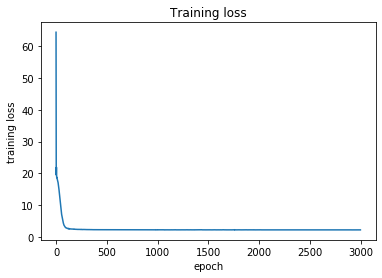

In [9]:
plt.plot(range(n_epochs), hist.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
y_test_pred_al = al_model(X_test)
y_test_pred_al_mean = y_test_pred_al.mean()
y_test_pred_al_stddev = y_test_pred_al.stddev()

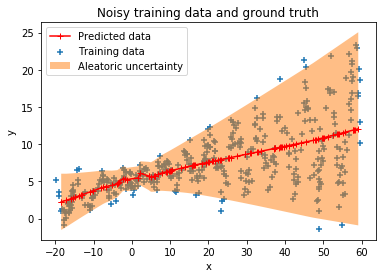

In [10]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test_pred_al_mean, 'r-', marker='+', label='Predicted data')
plt.fill_between(np.squeeze(X_test), 
                 np.squeeze(y_test_pred_al_mean + 2 * y_test_pred_al_stddev),
                 np.squeeze(y_test_pred_al_mean - 2 * y_test_pred_al_stddev),
                 alpha=0.5, label='Aleatoric uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate epistemic uncertainty

In [11]:
n_epochs = 10000
lr = 5e-3

In [12]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return Sequential([tfp.layers.VariableLayer(2 * n, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                           tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                           reinterpreted_batch_ndims=1))
    ])

In [13]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return Sequential([tfp.layers.VariableLayer(n, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                           tfd.Normal(loc=t, scale=1.0), reinterpreted_batch_ndims=1)),
    ])

In [14]:
def build_epistemic_model(train_size, scale=1):
    model_in = Input(shape=(1,))
    x = DenseVariational(8, posterior_mean_field, prior_trainable, kl_weight=1/train_size, activation='relu')(model_in)
#     x = LeakyReLU(0.1)(x)
#     x = DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
#     x = LeakyReLU(0.1)(x)
#     x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
#     x = LeakyReLU(0.1)(x)
    x = DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale))(x)
    model = Model(model_in, model_out)
    return model

ep_model = build_epistemic_model(n_train, scale=10)
ep_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
ep_model.summary()
hist = ep_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_variational (DenseVari (None, 8)                 48        
_________________________________________________________________
dense_variational_1 (DenseVa (None, 1)                 27        
_________________________________________________________________
distribution_lambda_2 (Distr ((None, 1), (None, 1))    0         
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
Train on 400 samples
Epoch 1/10000
400/400 - 0s - loss: 30.9472 - mean_squared_error: 5511.9062
Epoch 2/10000
400/400 - 0s - loss: 13.7837 - mean_squared_error: 2214.5852
Epoch 3/10000
400/400 - 0s - loss: 29.7400 - mean_squared_error: 5395.6235
Epoch 4/10000
4

Epoch 99/10000
400/400 - 0s - loss: 12.2839 - mean_squared_error: 1883.3431
Epoch 100/10000
400/400 - 0s - loss: 5.2159 - mean_squared_error: 522.0601
Epoch 101/10000
400/400 - 0s - loss: 10.6612 - mean_squared_error: 1517.5253
Epoch 102/10000
400/400 - 0s - loss: 5.5051 - mean_squared_error: 558.5492
Epoch 103/10000
400/400 - 0s - loss: 9.1263 - mean_squared_error: 1270.1082
Epoch 104/10000
400/400 - 0s - loss: 3.9843 - mean_squared_error: 253.0966
Epoch 105/10000
400/400 - 0s - loss: 9.7094 - mean_squared_error: 1429.4604
Epoch 106/10000
400/400 - 0s - loss: 6.4631 - mean_squared_error: 780.3605
Epoch 107/10000
400/400 - 0s - loss: 5.2202 - mean_squared_error: 485.5837
Epoch 108/10000
400/400 - 0s - loss: 12.5276 - mean_squared_error: 1880.4489
Epoch 109/10000
400/400 - 0s - loss: 5.1140 - mean_squared_error: 523.1954
Epoch 110/10000
400/400 - 0s - loss: 5.0875 - mean_squared_error: 508.7052
Epoch 111/10000
400/400 - 0s - loss: 4.1285 - mean_squared_error: 276.8676
Epoch 112/10000
40

Epoch 208/10000
400/400 - 0s - loss: 4.7739 - mean_squared_error: 402.4919
Epoch 209/10000
400/400 - 0s - loss: 6.6062 - mean_squared_error: 794.4787
Epoch 210/10000
400/400 - 0s - loss: 6.0420 - mean_squared_error: 679.8862
Epoch 211/10000
400/400 - 0s - loss: 3.8421 - mean_squared_error: 241.9739
Epoch 212/10000
400/400 - 0s - loss: 3.9543 - mean_squared_error: 240.0535
Epoch 213/10000
400/400 - 0s - loss: 4.3494 - mean_squared_error: 330.7351
Epoch 214/10000
400/400 - 0s - loss: 4.8789 - mean_squared_error: 478.8292
Epoch 215/10000
400/400 - 0s - loss: 4.2370 - mean_squared_error: 308.2726
Epoch 216/10000
400/400 - 0s - loss: 3.9745 - mean_squared_error: 248.1087
Epoch 217/10000
400/400 - 0s - loss: 4.0552 - mean_squared_error: 265.6226
Epoch 218/10000
400/400 - 0s - loss: 4.7515 - mean_squared_error: 411.2526
Epoch 219/10000
400/400 - 0s - loss: 3.9902 - mean_squared_error: 259.2353
Epoch 220/10000
400/400 - 0s - loss: 4.9424 - mean_squared_error: 422.7660
Epoch 221/10000
400/400 -

Epoch 318/10000
400/400 - 0s - loss: 4.0035 - mean_squared_error: 238.6881
Epoch 319/10000
400/400 - 0s - loss: 3.8877 - mean_squared_error: 232.4444
Epoch 320/10000
400/400 - 0s - loss: 3.9355 - mean_squared_error: 241.8670
Epoch 321/10000
400/400 - 0s - loss: 4.6536 - mean_squared_error: 360.8892
Epoch 322/10000
400/400 - 0s - loss: 3.8620 - mean_squared_error: 213.0099
Epoch 323/10000
400/400 - 0s - loss: 4.0907 - mean_squared_error: 272.4081
Epoch 324/10000
400/400 - 0s - loss: 4.5525 - mean_squared_error: 372.2232
Epoch 325/10000
400/400 - 0s - loss: 3.5678 - mean_squared_error: 181.1472
Epoch 326/10000
400/400 - 0s - loss: 4.3971 - mean_squared_error: 318.0280
Epoch 327/10000
400/400 - 0s - loss: 4.7594 - mean_squared_error: 399.8638
Epoch 328/10000
400/400 - 0s - loss: 4.5970 - mean_squared_error: 377.9742
Epoch 329/10000
400/400 - 0s - loss: 4.8823 - mean_squared_error: 390.1469
Epoch 330/10000
400/400 - 0s - loss: 3.6833 - mean_squared_error: 185.6021
Epoch 331/10000
400/400 -

Epoch 428/10000
400/400 - 0s - loss: 4.6195 - mean_squared_error: 398.6052
Epoch 429/10000
400/400 - 0s - loss: 6.5983 - mean_squared_error: 726.7335
Epoch 430/10000
400/400 - 0s - loss: 4.5488 - mean_squared_error: 365.7177
Epoch 431/10000
400/400 - 0s - loss: 4.3744 - mean_squared_error: 319.5171
Epoch 432/10000
400/400 - 0s - loss: 4.9154 - mean_squared_error: 410.6818
Epoch 433/10000
400/400 - 0s - loss: 3.6269 - mean_squared_error: 167.9308
Epoch 434/10000
400/400 - 0s - loss: 4.5024 - mean_squared_error: 340.4804
Epoch 435/10000
400/400 - 0s - loss: 3.5432 - mean_squared_error: 148.5699
Epoch 436/10000
400/400 - 0s - loss: 6.2141 - mean_squared_error: 705.9698
Epoch 437/10000
400/400 - 0s - loss: 6.4043 - mean_squared_error: 724.0178
Epoch 438/10000
400/400 - 0s - loss: 4.1028 - mean_squared_error: 276.6346
Epoch 439/10000
400/400 - 0s - loss: 4.2104 - mean_squared_error: 279.5236
Epoch 440/10000
400/400 - 0s - loss: 3.8404 - mean_squared_error: 233.8691
Epoch 441/10000
400/400 -

Epoch 538/10000
400/400 - 0s - loss: 3.5331 - mean_squared_error: 161.1603
Epoch 539/10000
400/400 - 0s - loss: 3.6007 - mean_squared_error: 198.3993
Epoch 540/10000
400/400 - 0s - loss: 4.2475 - mean_squared_error: 298.7758
Epoch 541/10000
400/400 - 0s - loss: 3.7705 - mean_squared_error: 202.9212
Epoch 542/10000
400/400 - 0s - loss: 4.3773 - mean_squared_error: 328.2885
Epoch 543/10000
400/400 - 0s - loss: 3.5097 - mean_squared_error: 169.2885
Epoch 544/10000
400/400 - 0s - loss: 3.6110 - mean_squared_error: 183.0748
Epoch 545/10000
400/400 - 0s - loss: 4.3242 - mean_squared_error: 294.0092
Epoch 546/10000
400/400 - 0s - loss: 3.7547 - mean_squared_error: 205.6992
Epoch 547/10000
400/400 - 0s - loss: 4.0393 - mean_squared_error: 280.2036
Epoch 548/10000
400/400 - 0s - loss: 3.6883 - mean_squared_error: 197.0110
Epoch 549/10000
400/400 - 0s - loss: 4.1745 - mean_squared_error: 283.0428
Epoch 550/10000
400/400 - 0s - loss: 3.5958 - mean_squared_error: 177.4947
Epoch 551/10000
400/400 -

Epoch 648/10000
400/400 - 0s - loss: 3.4822 - mean_squared_error: 155.4275
Epoch 649/10000
400/400 - 0s - loss: 3.4788 - mean_squared_error: 140.3493
Epoch 650/10000
400/400 - 0s - loss: 3.5051 - mean_squared_error: 140.8759
Epoch 651/10000
400/400 - 0s - loss: 3.5086 - mean_squared_error: 152.4252
Epoch 652/10000
400/400 - 0s - loss: 3.5886 - mean_squared_error: 158.0164
Epoch 653/10000
400/400 - 0s - loss: 3.6446 - mean_squared_error: 184.9652
Epoch 654/10000
400/400 - 0s - loss: 3.6026 - mean_squared_error: 174.4592
Epoch 655/10000
400/400 - 0s - loss: 3.5399 - mean_squared_error: 155.8595
Epoch 656/10000
400/400 - 0s - loss: 3.8103 - mean_squared_error: 196.0306
Epoch 657/10000
400/400 - 0s - loss: 3.4907 - mean_squared_error: 150.9277
Epoch 658/10000
400/400 - 0s - loss: 3.4919 - mean_squared_error: 156.0532
Epoch 659/10000
400/400 - 0s - loss: 3.5472 - mean_squared_error: 164.6835
Epoch 660/10000
400/400 - 0s - loss: 4.0341 - mean_squared_error: 269.6537
Epoch 661/10000
400/400 -

Epoch 758/10000
400/400 - 0s - loss: 3.7214 - mean_squared_error: 182.7919
Epoch 759/10000
400/400 - 0s - loss: 3.8204 - mean_squared_error: 198.5587
Epoch 760/10000
400/400 - 0s - loss: 4.7827 - mean_squared_error: 422.7147
Epoch 761/10000
400/400 - 0s - loss: 3.5504 - mean_squared_error: 161.9737
Epoch 762/10000
400/400 - 0s - loss: 3.4781 - mean_squared_error: 152.9660
Epoch 763/10000
400/400 - 0s - loss: 3.4627 - mean_squared_error: 138.0087
Epoch 764/10000
400/400 - 0s - loss: 3.7165 - mean_squared_error: 196.8717
Epoch 765/10000
400/400 - 0s - loss: 3.5388 - mean_squared_error: 172.0026
Epoch 766/10000
400/400 - 0s - loss: 3.8791 - mean_squared_error: 237.3555
Epoch 767/10000
400/400 - 0s - loss: 3.4484 - mean_squared_error: 164.4555
Epoch 768/10000
400/400 - 0s - loss: 3.6218 - mean_squared_error: 174.3430
Epoch 769/10000
400/400 - 0s - loss: 3.4284 - mean_squared_error: 133.5349
Epoch 770/10000
400/400 - 0s - loss: 3.4551 - mean_squared_error: 157.6646
Epoch 771/10000
400/400 -

Epoch 868/10000
400/400 - 0s - loss: 3.4755 - mean_squared_error: 134.0763
Epoch 869/10000
400/400 - 0s - loss: 3.5226 - mean_squared_error: 132.5247
Epoch 870/10000
400/400 - 0s - loss: 3.4778 - mean_squared_error: 136.1164
Epoch 871/10000
400/400 - 0s - loss: 3.4704 - mean_squared_error: 140.4320
Epoch 872/10000
400/400 - 0s - loss: 3.6024 - mean_squared_error: 188.7755
Epoch 873/10000
400/400 - 0s - loss: 3.7146 - mean_squared_error: 211.2425
Epoch 874/10000
400/400 - 0s - loss: 3.4529 - mean_squared_error: 141.1066
Epoch 875/10000
400/400 - 0s - loss: 3.6531 - mean_squared_error: 192.2423
Epoch 876/10000
400/400 - 0s - loss: 3.5004 - mean_squared_error: 163.2580
Epoch 877/10000
400/400 - 0s - loss: 3.4916 - mean_squared_error: 172.2723
Epoch 878/10000
400/400 - 0s - loss: 3.6078 - mean_squared_error: 155.5950
Epoch 879/10000
400/400 - 0s - loss: 3.6997 - mean_squared_error: 211.4302
Epoch 880/10000
400/400 - 0s - loss: 3.5026 - mean_squared_error: 137.4550
Epoch 881/10000
400/400 -

Epoch 978/10000
400/400 - 0s - loss: 3.4114 - mean_squared_error: 131.7721
Epoch 979/10000
400/400 - 0s - loss: 3.4147 - mean_squared_error: 128.6699
Epoch 980/10000
400/400 - 0s - loss: 3.6566 - mean_squared_error: 181.9834
Epoch 981/10000
400/400 - 0s - loss: 3.5703 - mean_squared_error: 162.2270
Epoch 982/10000
400/400 - 0s - loss: 3.4290 - mean_squared_error: 139.8860
Epoch 983/10000
400/400 - 0s - loss: 3.3934 - mean_squared_error: 125.6106
Epoch 984/10000
400/400 - 0s - loss: 3.4079 - mean_squared_error: 133.6818
Epoch 985/10000
400/400 - 0s - loss: 3.9941 - mean_squared_error: 244.3998
Epoch 986/10000
400/400 - 0s - loss: 3.4862 - mean_squared_error: 160.3175
Epoch 987/10000
400/400 - 0s - loss: 3.3877 - mean_squared_error: 133.6315
Epoch 988/10000
400/400 - 0s - loss: 3.5267 - mean_squared_error: 138.7686
Epoch 989/10000
400/400 - 0s - loss: 3.5796 - mean_squared_error: 165.8873
Epoch 990/10000
400/400 - 0s - loss: 3.4274 - mean_squared_error: 149.8523
Epoch 991/10000
400/400 -

Epoch 1087/10000
400/400 - 0s - loss: 3.5424 - mean_squared_error: 168.4017
Epoch 1088/10000
400/400 - 0s - loss: 3.8892 - mean_squared_error: 227.7932
Epoch 1089/10000
400/400 - 0s - loss: 3.6370 - mean_squared_error: 186.7446
Epoch 1090/10000
400/400 - 0s - loss: 3.4196 - mean_squared_error: 140.5576
Epoch 1091/10000
400/400 - 0s - loss: 3.5101 - mean_squared_error: 168.6912
Epoch 1092/10000
400/400 - 0s - loss: 3.3771 - mean_squared_error: 134.8010
Epoch 1093/10000
400/400 - 0s - loss: 3.4145 - mean_squared_error: 132.4541
Epoch 1094/10000
400/400 - 0s - loss: 3.3995 - mean_squared_error: 139.0494
Epoch 1095/10000
400/400 - 0s - loss: 3.3785 - mean_squared_error: 126.9951
Epoch 1096/10000
400/400 - 0s - loss: 3.4148 - mean_squared_error: 140.6647
Epoch 1097/10000
400/400 - 0s - loss: 3.3728 - mean_squared_error: 117.8663
Epoch 1098/10000
400/400 - 0s - loss: 3.3840 - mean_squared_error: 104.4197
Epoch 1099/10000
400/400 - 0s - loss: 3.3727 - mean_squared_error: 122.0961
Epoch 1100/1

Epoch 1195/10000
400/400 - 0s - loss: 3.5223 - mean_squared_error: 156.6537
Epoch 1196/10000
400/400 - 0s - loss: 3.4425 - mean_squared_error: 145.5039
Epoch 1197/10000
400/400 - 0s - loss: 3.4999 - mean_squared_error: 153.2481
Epoch 1198/10000
400/400 - 0s - loss: 3.5117 - mean_squared_error: 141.4421
Epoch 1199/10000
400/400 - 0s - loss: 3.3734 - mean_squared_error: 132.9040
Epoch 1200/10000
400/400 - 0s - loss: 3.5137 - mean_squared_error: 135.1962
Epoch 1201/10000
400/400 - 0s - loss: 3.4778 - mean_squared_error: 144.4242
Epoch 1202/10000
400/400 - 0s - loss: 3.4012 - mean_squared_error: 132.0889
Epoch 1203/10000
400/400 - 0s - loss: 3.4876 - mean_squared_error: 138.9144
Epoch 1204/10000
400/400 - 0s - loss: 3.4036 - mean_squared_error: 141.5963
Epoch 1205/10000
400/400 - 0s - loss: 3.3368 - mean_squared_error: 114.5581
Epoch 1206/10000
400/400 - 0s - loss: 3.4855 - mean_squared_error: 165.4694
Epoch 1207/10000
400/400 - 0s - loss: 3.4130 - mean_squared_error: 139.1512
Epoch 1208/1

Epoch 1303/10000
400/400 - 0s - loss: 3.4247 - mean_squared_error: 135.7601
Epoch 1304/10000
400/400 - 0s - loss: 3.3673 - mean_squared_error: 113.4537
Epoch 1305/10000
400/400 - 0s - loss: 3.5486 - mean_squared_error: 166.4992
Epoch 1306/10000
400/400 - 0s - loss: 3.3512 - mean_squared_error: 125.1884
Epoch 1307/10000
400/400 - 0s - loss: 3.3547 - mean_squared_error: 108.5490
Epoch 1308/10000
400/400 - 0s - loss: 3.4231 - mean_squared_error: 130.0971
Epoch 1309/10000
400/400 - 0s - loss: 3.3687 - mean_squared_error: 126.6151
Epoch 1310/10000
400/400 - 0s - loss: 3.3707 - mean_squared_error: 118.6639
Epoch 1311/10000
400/400 - 0s - loss: 3.3773 - mean_squared_error: 122.8550
Epoch 1312/10000
400/400 - 0s - loss: 3.4158 - mean_squared_error: 141.5668
Epoch 1313/10000
400/400 - 0s - loss: 3.4018 - mean_squared_error: 141.5981
Epoch 1314/10000
400/400 - 0s - loss: 3.5104 - mean_squared_error: 153.5802
Epoch 1315/10000
400/400 - 0s - loss: 3.3514 - mean_squared_error: 115.1720
Epoch 1316/1

Epoch 1411/10000
400/400 - 0s - loss: 3.3539 - mean_squared_error: 116.8221
Epoch 1412/10000
400/400 - 0s - loss: 3.3641 - mean_squared_error: 125.5148
Epoch 1413/10000
400/400 - 0s - loss: 3.4604 - mean_squared_error: 138.2276
Epoch 1414/10000
400/400 - 0s - loss: 3.3557 - mean_squared_error: 116.6951
Epoch 1415/10000
400/400 - 0s - loss: 3.3911 - mean_squared_error: 132.3987
Epoch 1416/10000
400/400 - 0s - loss: 3.4567 - mean_squared_error: 146.0587
Epoch 1417/10000
400/400 - 0s - loss: 3.3400 - mean_squared_error: 128.7863
Epoch 1418/10000
400/400 - 0s - loss: 3.3618 - mean_squared_error: 126.5185
Epoch 1419/10000
400/400 - 0s - loss: 3.4293 - mean_squared_error: 129.0204
Epoch 1420/10000
400/400 - 0s - loss: 3.3526 - mean_squared_error: 123.5420
Epoch 1421/10000
400/400 - 0s - loss: 3.3460 - mean_squared_error: 109.0231
Epoch 1422/10000
400/400 - 0s - loss: 3.3657 - mean_squared_error: 130.2911
Epoch 1423/10000
400/400 - 0s - loss: 3.4100 - mean_squared_error: 139.9314
Epoch 1424/1

Epoch 1519/10000
400/400 - 0s - loss: 3.4020 - mean_squared_error: 127.6673
Epoch 1520/10000
400/400 - 0s - loss: 3.3691 - mean_squared_error: 129.7632
Epoch 1521/10000
400/400 - 0s - loss: 3.3531 - mean_squared_error: 133.5116
Epoch 1522/10000
400/400 - 0s - loss: 3.4055 - mean_squared_error: 132.0055
Epoch 1523/10000
400/400 - 0s - loss: 3.3990 - mean_squared_error: 120.6715
Epoch 1524/10000
400/400 - 0s - loss: 3.3527 - mean_squared_error: 108.6855
Epoch 1525/10000
400/400 - 0s - loss: 3.3692 - mean_squared_error: 122.1910
Epoch 1526/10000
400/400 - 0s - loss: 3.3864 - mean_squared_error: 133.2310
Epoch 1527/10000
400/400 - 0s - loss: 3.4379 - mean_squared_error: 146.1517
Epoch 1528/10000
400/400 - 0s - loss: 3.3957 - mean_squared_error: 136.9631
Epoch 1529/10000
400/400 - 0s - loss: 3.3657 - mean_squared_error: 124.8584
Epoch 1530/10000
400/400 - 0s - loss: 3.3855 - mean_squared_error: 118.3009
Epoch 1531/10000
400/400 - 0s - loss: 3.3723 - mean_squared_error: 128.8609
Epoch 1532/1

Epoch 1627/10000
400/400 - 0s - loss: 3.3531 - mean_squared_error: 125.5846
Epoch 1628/10000
400/400 - 0s - loss: 3.3424 - mean_squared_error: 135.6241
Epoch 1629/10000
400/400 - 0s - loss: 3.3794 - mean_squared_error: 143.5075
Epoch 1630/10000
400/400 - 0s - loss: 3.3599 - mean_squared_error: 128.7107
Epoch 1631/10000
400/400 - 0s - loss: 3.3689 - mean_squared_error: 127.2282
Epoch 1632/10000
400/400 - 0s - loss: 3.3419 - mean_squared_error: 110.2486
Epoch 1633/10000
400/400 - 0s - loss: 3.3275 - mean_squared_error: 115.9867
Epoch 1634/10000
400/400 - 0s - loss: 3.3478 - mean_squared_error: 117.4324
Epoch 1635/10000
400/400 - 0s - loss: 3.3646 - mean_squared_error: 119.5388
Epoch 1636/10000
400/400 - 0s - loss: 3.3480 - mean_squared_error: 121.7879
Epoch 1637/10000
400/400 - 0s - loss: 3.3475 - mean_squared_error: 130.6910
Epoch 1638/10000
400/400 - 0s - loss: 3.3509 - mean_squared_error: 124.5829
Epoch 1639/10000
400/400 - 0s - loss: 3.3634 - mean_squared_error: 112.6207
Epoch 1640/1

Epoch 1735/10000
400/400 - 0s - loss: 3.3804 - mean_squared_error: 132.5022
Epoch 1736/10000
400/400 - 0s - loss: 3.3446 - mean_squared_error: 113.6090
Epoch 1737/10000
400/400 - 0s - loss: 3.3445 - mean_squared_error: 124.7370
Epoch 1738/10000
400/400 - 0s - loss: 3.4230 - mean_squared_error: 125.5546
Epoch 1739/10000
400/400 - 0s - loss: 3.3759 - mean_squared_error: 124.4741
Epoch 1740/10000
400/400 - 0s - loss: 3.3659 - mean_squared_error: 121.8834
Epoch 1741/10000
400/400 - 0s - loss: 3.3935 - mean_squared_error: 137.3287
Epoch 1742/10000
400/400 - 0s - loss: 3.3732 - mean_squared_error: 126.2373
Epoch 1743/10000
400/400 - 0s - loss: 3.3479 - mean_squared_error: 124.5821
Epoch 1744/10000
400/400 - 0s - loss: 3.3520 - mean_squared_error: 105.9599
Epoch 1745/10000
400/400 - 0s - loss: 3.3708 - mean_squared_error: 113.3977
Epoch 1746/10000
400/400 - 0s - loss: 3.3415 - mean_squared_error: 116.0919
Epoch 1747/10000
400/400 - 0s - loss: 3.3589 - mean_squared_error: 123.5926
Epoch 1748/1

Epoch 1843/10000
400/400 - 0s - loss: 3.3971 - mean_squared_error: 131.0620
Epoch 1844/10000
400/400 - 0s - loss: 3.3427 - mean_squared_error: 108.8448
Epoch 1845/10000
400/400 - 0s - loss: 3.3464 - mean_squared_error: 120.1621
Epoch 1846/10000
400/400 - 0s - loss: 3.3868 - mean_squared_error: 128.7395
Epoch 1847/10000
400/400 - 0s - loss: 3.3583 - mean_squared_error: 125.4326
Epoch 1848/10000
400/400 - 0s - loss: 3.3655 - mean_squared_error: 127.4468
Epoch 1849/10000
400/400 - 0s - loss: 3.4120 - mean_squared_error: 124.9521
Epoch 1850/10000
400/400 - 0s - loss: 3.3500 - mean_squared_error: 124.9729
Epoch 1851/10000
400/400 - 0s - loss: 3.3761 - mean_squared_error: 121.9574
Epoch 1852/10000
400/400 - 0s - loss: 3.3456 - mean_squared_error: 125.6956
Epoch 1853/10000
400/400 - 0s - loss: 3.3684 - mean_squared_error: 116.9526
Epoch 1854/10000
400/400 - 0s - loss: 3.3505 - mean_squared_error: 113.5827
Epoch 1855/10000
400/400 - 0s - loss: 3.3494 - mean_squared_error: 116.6785
Epoch 1856/1

Epoch 1951/10000
400/400 - 0s - loss: 3.3536 - mean_squared_error: 102.5975
Epoch 1952/10000
400/400 - 0s - loss: 3.4046 - mean_squared_error: 127.3718
Epoch 1953/10000
400/400 - 0s - loss: 3.4053 - mean_squared_error: 116.4927
Epoch 1954/10000
400/400 - 0s - loss: 3.3473 - mean_squared_error: 127.7726
Epoch 1955/10000
400/400 - 0s - loss: 3.4510 - mean_squared_error: 149.9932
Epoch 1956/10000
400/400 - 0s - loss: 3.3546 - mean_squared_error: 126.8726
Epoch 1957/10000
400/400 - 0s - loss: 3.3666 - mean_squared_error: 121.8717
Epoch 1958/10000
400/400 - 0s - loss: 3.3447 - mean_squared_error: 117.1315
Epoch 1959/10000
400/400 - 0s - loss: 3.3838 - mean_squared_error: 120.2550
Epoch 1960/10000
400/400 - 0s - loss: 3.3455 - mean_squared_error: 114.3053
Epoch 1961/10000
400/400 - 0s - loss: 3.3713 - mean_squared_error: 132.5273
Epoch 1962/10000
400/400 - 0s - loss: 3.3525 - mean_squared_error: 121.8802
Epoch 1963/10000
400/400 - 0s - loss: 3.3460 - mean_squared_error: 135.2059
Epoch 1964/1

Epoch 2059/10000
400/400 - 0s - loss: 3.3846 - mean_squared_error: 138.4620
Epoch 2060/10000
400/400 - 0s - loss: 3.3767 - mean_squared_error: 127.7800
Epoch 2061/10000
400/400 - 0s - loss: 3.3484 - mean_squared_error: 125.2977
Epoch 2062/10000
400/400 - 0s - loss: 3.3798 - mean_squared_error: 133.9809
Epoch 2063/10000
400/400 - 0s - loss: 3.3637 - mean_squared_error: 126.4735
Epoch 2064/10000
400/400 - 0s - loss: 3.3759 - mean_squared_error: 135.0391
Epoch 2065/10000
400/400 - 0s - loss: 3.3461 - mean_squared_error: 121.6171
Epoch 2066/10000
400/400 - 0s - loss: 3.3588 - mean_squared_error: 117.6676
Epoch 2067/10000
400/400 - 0s - loss: 3.3516 - mean_squared_error: 127.0581
Epoch 2068/10000
400/400 - 0s - loss: 3.3614 - mean_squared_error: 115.1854
Epoch 2069/10000
400/400 - 0s - loss: 3.3521 - mean_squared_error: 124.0848
Epoch 2070/10000
400/400 - 0s - loss: 3.3674 - mean_squared_error: 120.3957
Epoch 2071/10000
400/400 - 0s - loss: 3.3612 - mean_squared_error: 128.2917
Epoch 2072/1

Epoch 2167/10000
400/400 - 0s - loss: 3.3439 - mean_squared_error: 131.8965
Epoch 2168/10000
400/400 - 0s - loss: 3.3790 - mean_squared_error: 119.5983
Epoch 2169/10000
400/400 - 0s - loss: 3.3459 - mean_squared_error: 114.6712
Epoch 2170/10000
400/400 - 0s - loss: 3.3487 - mean_squared_error: 132.1232
Epoch 2171/10000
400/400 - 0s - loss: 3.3915 - mean_squared_error: 152.4482
Epoch 2172/10000
400/400 - 0s - loss: 3.3471 - mean_squared_error: 107.0914
Epoch 2173/10000
400/400 - 0s - loss: 3.3662 - mean_squared_error: 126.3411
Epoch 2174/10000
400/400 - 0s - loss: 3.3505 - mean_squared_error: 109.2912
Epoch 2175/10000
400/400 - 0s - loss: 3.3484 - mean_squared_error: 118.1044
Epoch 2176/10000
400/400 - 0s - loss: 3.3604 - mean_squared_error: 99.5248
Epoch 2177/10000
400/400 - 0s - loss: 3.3456 - mean_squared_error: 118.6813
Epoch 2178/10000
400/400 - 0s - loss: 3.3460 - mean_squared_error: 119.4372
Epoch 2179/10000
400/400 - 0s - loss: 3.3664 - mean_squared_error: 108.4900
Epoch 2180/10

Epoch 2275/10000
400/400 - 0s - loss: 3.3547 - mean_squared_error: 113.2328
Epoch 2276/10000
400/400 - 0s - loss: 3.3627 - mean_squared_error: 114.8378
Epoch 2277/10000
400/400 - 0s - loss: 3.3652 - mean_squared_error: 117.9859
Epoch 2278/10000
400/400 - 0s - loss: 3.3482 - mean_squared_error: 107.2256
Epoch 2279/10000
400/400 - 0s - loss: 3.3672 - mean_squared_error: 119.4246
Epoch 2280/10000
400/400 - 0s - loss: 3.3424 - mean_squared_error: 116.8187
Epoch 2281/10000
400/400 - 0s - loss: 3.3592 - mean_squared_error: 117.4505
Epoch 2282/10000
400/400 - 0s - loss: 3.3738 - mean_squared_error: 122.9871
Epoch 2283/10000
400/400 - 0s - loss: 3.3946 - mean_squared_error: 125.7486
Epoch 2284/10000
400/400 - 0s - loss: 3.3574 - mean_squared_error: 107.5412
Epoch 2285/10000
400/400 - 0s - loss: 3.3542 - mean_squared_error: 124.4230
Epoch 2286/10000
400/400 - 0s - loss: 3.3464 - mean_squared_error: 115.8222
Epoch 2287/10000
400/400 - 0s - loss: 3.3446 - mean_squared_error: 123.2679
Epoch 2288/1

Epoch 2383/10000
400/400 - 0s - loss: 3.3578 - mean_squared_error: 122.5175
Epoch 2384/10000
400/400 - 0s - loss: 3.3467 - mean_squared_error: 123.3722
Epoch 2385/10000
400/400 - 0s - loss: 3.3556 - mean_squared_error: 124.4042
Epoch 2386/10000
400/400 - 0s - loss: 3.3488 - mean_squared_error: 108.1322
Epoch 2387/10000
400/400 - 0s - loss: 3.3636 - mean_squared_error: 128.1423
Epoch 2388/10000
400/400 - 0s - loss: 3.3764 - mean_squared_error: 127.1081
Epoch 2389/10000
400/400 - 0s - loss: 3.3455 - mean_squared_error: 126.7630
Epoch 2390/10000
400/400 - 0s - loss: 3.3586 - mean_squared_error: 127.1427
Epoch 2391/10000
400/400 - 0s - loss: 3.3645 - mean_squared_error: 123.4547
Epoch 2392/10000
400/400 - 0s - loss: 3.3561 - mean_squared_error: 125.9084
Epoch 2393/10000
400/400 - 0s - loss: 3.3724 - mean_squared_error: 122.7034
Epoch 2394/10000
400/400 - 0s - loss: 3.3483 - mean_squared_error: 113.1316
Epoch 2395/10000
400/400 - 0s - loss: 3.3567 - mean_squared_error: 114.3556
Epoch 2396/1

Epoch 2491/10000
400/400 - 0s - loss: 3.3569 - mean_squared_error: 107.5973
Epoch 2492/10000
400/400 - 0s - loss: 3.3504 - mean_squared_error: 101.9476
Epoch 2493/10000
400/400 - 0s - loss: 3.3495 - mean_squared_error: 114.8132
Epoch 2494/10000
400/400 - 0s - loss: 3.3500 - mean_squared_error: 124.6351
Epoch 2495/10000
400/400 - 0s - loss: 3.3615 - mean_squared_error: 118.3222
Epoch 2496/10000
400/400 - 0s - loss: 3.3747 - mean_squared_error: 127.9404
Epoch 2497/10000
400/400 - 0s - loss: 3.3578 - mean_squared_error: 112.3217
Epoch 2498/10000
400/400 - 0s - loss: 3.3527 - mean_squared_error: 136.1733
Epoch 2499/10000
400/400 - 0s - loss: 3.3559 - mean_squared_error: 122.6250
Epoch 2500/10000
400/400 - 0s - loss: 3.3522 - mean_squared_error: 101.5796
Epoch 2501/10000
400/400 - 0s - loss: 3.3500 - mean_squared_error: 119.8696
Epoch 2502/10000
400/400 - 0s - loss: 3.3549 - mean_squared_error: 127.4330
Epoch 2503/10000
400/400 - 0s - loss: 3.3582 - mean_squared_error: 112.2997
Epoch 2504/1

Epoch 2599/10000
400/400 - 0s - loss: 3.3686 - mean_squared_error: 130.3113
Epoch 2600/10000
400/400 - 0s - loss: 3.3658 - mean_squared_error: 111.1576
Epoch 2601/10000
400/400 - 0s - loss: 3.3450 - mean_squared_error: 106.8820
Epoch 2602/10000
400/400 - 0s - loss: 3.3452 - mean_squared_error: 121.6130
Epoch 2603/10000
400/400 - 0s - loss: 3.3946 - mean_squared_error: 133.6879
Epoch 2604/10000
400/400 - 0s - loss: 3.3576 - mean_squared_error: 113.1570
Epoch 2605/10000
400/400 - 0s - loss: 3.3515 - mean_squared_error: 108.8052
Epoch 2606/10000
400/400 - 0s - loss: 3.3515 - mean_squared_error: 106.2648
Epoch 2607/10000
400/400 - 0s - loss: 3.3566 - mean_squared_error: 119.3569
Epoch 2608/10000
400/400 - 0s - loss: 3.3433 - mean_squared_error: 101.9028
Epoch 2609/10000
400/400 - 0s - loss: 3.3700 - mean_squared_error: 132.5641
Epoch 2610/10000
400/400 - 0s - loss: 3.3613 - mean_squared_error: 136.3234
Epoch 2611/10000
400/400 - 0s - loss: 3.3579 - mean_squared_error: 119.4911
Epoch 2612/1

Epoch 2707/10000
400/400 - 0s - loss: 3.3468 - mean_squared_error: 118.8921
Epoch 2708/10000
400/400 - 0s - loss: 3.3501 - mean_squared_error: 109.1761
Epoch 2709/10000
400/400 - 0s - loss: 3.3646 - mean_squared_error: 122.1434
Epoch 2710/10000
400/400 - 0s - loss: 3.3470 - mean_squared_error: 118.9161
Epoch 2711/10000
400/400 - 0s - loss: 3.3528 - mean_squared_error: 131.8398
Epoch 2712/10000
400/400 - 0s - loss: 3.3472 - mean_squared_error: 127.3080
Epoch 2713/10000
400/400 - 0s - loss: 3.3533 - mean_squared_error: 124.6736
Epoch 2714/10000
400/400 - 0s - loss: 3.3468 - mean_squared_error: 120.2249
Epoch 2715/10000
400/400 - 0s - loss: 3.3469 - mean_squared_error: 124.2209
Epoch 2716/10000
400/400 - 0s - loss: 3.3958 - mean_squared_error: 121.5281
Epoch 2717/10000
400/400 - 0s - loss: 3.3539 - mean_squared_error: 124.7976
Epoch 2718/10000
400/400 - 0s - loss: 3.3530 - mean_squared_error: 108.6397
Epoch 2719/10000
400/400 - 0s - loss: 3.3452 - mean_squared_error: 114.9535
Epoch 2720/1

Epoch 2815/10000
400/400 - 0s - loss: 3.3539 - mean_squared_error: 111.8604
Epoch 2816/10000
400/400 - 0s - loss: 3.3521 - mean_squared_error: 103.6240
Epoch 2817/10000
400/400 - 0s - loss: 3.3647 - mean_squared_error: 124.3646
Epoch 2818/10000
400/400 - 0s - loss: 3.3575 - mean_squared_error: 116.5529
Epoch 2819/10000
400/400 - 0s - loss: 3.3543 - mean_squared_error: 130.9445
Epoch 2820/10000
400/400 - 0s - loss: 3.3632 - mean_squared_error: 126.8005
Epoch 2821/10000
400/400 - 0s - loss: 3.4003 - mean_squared_error: 124.0219
Epoch 2822/10000
400/400 - 0s - loss: 3.3660 - mean_squared_error: 127.1274
Epoch 2823/10000
400/400 - 0s - loss: 3.3873 - mean_squared_error: 104.6090
Epoch 2824/10000
400/400 - 0s - loss: 3.3556 - mean_squared_error: 105.9863
Epoch 2825/10000
400/400 - 0s - loss: 3.3510 - mean_squared_error: 126.7350
Epoch 2826/10000
400/400 - 0s - loss: 3.3787 - mean_squared_error: 129.7403
Epoch 2827/10000
400/400 - 0s - loss: 3.3467 - mean_squared_error: 93.8765
Epoch 2828/10

Epoch 2923/10000
400/400 - 0s - loss: 3.3579 - mean_squared_error: 114.5986
Epoch 2924/10000
400/400 - 0s - loss: 3.3526 - mean_squared_error: 114.1021
Epoch 2925/10000
400/400 - 0s - loss: 3.3513 - mean_squared_error: 109.3420
Epoch 2926/10000
400/400 - 0s - loss: 3.3915 - mean_squared_error: 119.2487
Epoch 2927/10000
400/400 - 0s - loss: 3.3429 - mean_squared_error: 116.2044
Epoch 2928/10000
400/400 - 0s - loss: 3.3538 - mean_squared_error: 134.6509
Epoch 2929/10000
400/400 - 0s - loss: 3.3530 - mean_squared_error: 117.3007
Epoch 2930/10000
400/400 - 0s - loss: 3.3440 - mean_squared_error: 123.5519
Epoch 2931/10000
400/400 - 0s - loss: 3.3537 - mean_squared_error: 96.6440
Epoch 2932/10000
400/400 - 0s - loss: 3.3550 - mean_squared_error: 118.6070
Epoch 2933/10000
400/400 - 0s - loss: 3.3669 - mean_squared_error: 116.0238
Epoch 2934/10000
400/400 - 0s - loss: 3.3520 - mean_squared_error: 127.5645
Epoch 2935/10000
400/400 - 0s - loss: 3.3622 - mean_squared_error: 115.3954
Epoch 2936/10

Epoch 3031/10000
400/400 - 0s - loss: 3.3506 - mean_squared_error: 119.3555
Epoch 3032/10000
400/400 - 0s - loss: 3.3530 - mean_squared_error: 124.6640
Epoch 3033/10000
400/400 - 0s - loss: 3.3497 - mean_squared_error: 113.6491
Epoch 3034/10000
400/400 - 0s - loss: 3.3435 - mean_squared_error: 126.7166
Epoch 3035/10000
400/400 - 0s - loss: 3.3461 - mean_squared_error: 123.4062
Epoch 3036/10000
400/400 - 0s - loss: 3.3509 - mean_squared_error: 105.0218
Epoch 3037/10000
400/400 - 0s - loss: 3.3434 - mean_squared_error: 113.8614
Epoch 3038/10000
400/400 - 0s - loss: 3.3429 - mean_squared_error: 107.9745
Epoch 3039/10000
400/400 - 0s - loss: 3.3512 - mean_squared_error: 105.9142
Epoch 3040/10000
400/400 - 0s - loss: 3.3420 - mean_squared_error: 129.1510
Epoch 3041/10000
400/400 - 0s - loss: 3.3552 - mean_squared_error: 105.9099
Epoch 3042/10000
400/400 - 0s - loss: 3.3455 - mean_squared_error: 122.7685
Epoch 3043/10000
400/400 - 0s - loss: 3.3459 - mean_squared_error: 111.5426
Epoch 3044/1

Epoch 3139/10000
400/400 - 0s - loss: 3.3471 - mean_squared_error: 107.6520
Epoch 3140/10000
400/400 - 0s - loss: 3.3428 - mean_squared_error: 116.1373
Epoch 3141/10000
400/400 - 0s - loss: 3.3546 - mean_squared_error: 118.3322
Epoch 3142/10000
400/400 - 0s - loss: 3.3448 - mean_squared_error: 123.3973
Epoch 3143/10000
400/400 - 0s - loss: 3.3404 - mean_squared_error: 121.2893
Epoch 3144/10000
400/400 - 0s - loss: 3.3554 - mean_squared_error: 125.4085
Epoch 3145/10000
400/400 - 0s - loss: 3.3451 - mean_squared_error: 110.1361
Epoch 3146/10000
400/400 - 0s - loss: 3.3408 - mean_squared_error: 112.0926
Epoch 3147/10000
400/400 - 0s - loss: 3.3455 - mean_squared_error: 109.3642
Epoch 3148/10000
400/400 - 0s - loss: 3.3511 - mean_squared_error: 110.1633
Epoch 3149/10000
400/400 - 0s - loss: 3.3396 - mean_squared_error: 100.7889
Epoch 3150/10000
400/400 - 0s - loss: 3.3940 - mean_squared_error: 123.6294
Epoch 3151/10000
400/400 - 0s - loss: 3.3503 - mean_squared_error: 98.9179
Epoch 3152/10

Epoch 3247/10000
400/400 - 0s - loss: 3.3678 - mean_squared_error: 115.5292
Epoch 3248/10000
400/400 - 0s - loss: 3.3501 - mean_squared_error: 111.9718
Epoch 3249/10000
400/400 - 0s - loss: 3.3478 - mean_squared_error: 108.9395
Epoch 3250/10000
400/400 - 0s - loss: 3.3486 - mean_squared_error: 114.1799
Epoch 3251/10000
400/400 - 0s - loss: 3.3469 - mean_squared_error: 123.8590
Epoch 3252/10000
400/400 - 0s - loss: 3.3525 - mean_squared_error: 108.8510
Epoch 3253/10000
400/400 - 0s - loss: 3.3504 - mean_squared_error: 114.4402
Epoch 3254/10000
400/400 - 0s - loss: 3.3467 - mean_squared_error: 124.6485
Epoch 3255/10000
400/400 - 0s - loss: 3.3425 - mean_squared_error: 112.5350
Epoch 3256/10000
400/400 - 0s - loss: 3.3486 - mean_squared_error: 116.4775
Epoch 3257/10000
400/400 - 0s - loss: 3.3464 - mean_squared_error: 111.3412
Epoch 3258/10000
400/400 - 0s - loss: 3.3364 - mean_squared_error: 116.6068
Epoch 3259/10000
400/400 - 0s - loss: 3.3460 - mean_squared_error: 103.6241
Epoch 3260/1

Epoch 3355/10000
400/400 - 0s - loss: 3.3434 - mean_squared_error: 122.6239
Epoch 3356/10000
400/400 - 0s - loss: 3.3624 - mean_squared_error: 122.2414
Epoch 3357/10000
400/400 - 0s - loss: 3.3426 - mean_squared_error: 113.6391
Epoch 3358/10000
400/400 - 0s - loss: 3.3652 - mean_squared_error: 132.9266
Epoch 3359/10000
400/400 - 0s - loss: 3.3447 - mean_squared_error: 120.0048
Epoch 3360/10000
400/400 - 0s - loss: 3.3431 - mean_squared_error: 112.4905
Epoch 3361/10000
400/400 - 0s - loss: 3.3426 - mean_squared_error: 108.5051
Epoch 3362/10000
400/400 - 0s - loss: 3.3447 - mean_squared_error: 112.8902
Epoch 3363/10000
400/400 - 0s - loss: 3.3481 - mean_squared_error: 123.4992
Epoch 3364/10000
400/400 - 0s - loss: 3.3492 - mean_squared_error: 121.4994
Epoch 3365/10000
400/400 - 0s - loss: 3.3455 - mean_squared_error: 107.9561
Epoch 3366/10000
400/400 - 0s - loss: 3.3725 - mean_squared_error: 123.8518
Epoch 3367/10000
400/400 - 0s - loss: 3.3450 - mean_squared_error: 115.5271
Epoch 3368/1

Epoch 3463/10000
400/400 - 0s - loss: 3.3545 - mean_squared_error: 113.0793
Epoch 3464/10000
400/400 - 0s - loss: 3.3484 - mean_squared_error: 111.7309
Epoch 3465/10000
400/400 - 0s - loss: 3.3482 - mean_squared_error: 128.1809
Epoch 3466/10000
400/400 - 0s - loss: 3.3417 - mean_squared_error: 107.9157
Epoch 3467/10000
400/400 - 0s - loss: 3.3430 - mean_squared_error: 120.6528
Epoch 3468/10000
400/400 - 0s - loss: 3.3493 - mean_squared_error: 118.2453
Epoch 3469/10000
400/400 - 0s - loss: 3.3571 - mean_squared_error: 109.4950
Epoch 3470/10000
400/400 - 0s - loss: 3.3489 - mean_squared_error: 120.0402
Epoch 3471/10000
400/400 - 0s - loss: 3.3465 - mean_squared_error: 133.7076
Epoch 3472/10000
400/400 - 0s - loss: 3.3489 - mean_squared_error: 105.9913
Epoch 3473/10000
400/400 - 0s - loss: 3.3548 - mean_squared_error: 115.2867
Epoch 3474/10000
400/400 - 0s - loss: 3.3388 - mean_squared_error: 141.3367
Epoch 3475/10000
400/400 - 0s - loss: 3.3489 - mean_squared_error: 112.0824
Epoch 3476/1

Epoch 3571/10000
400/400 - 0s - loss: 3.3458 - mean_squared_error: 118.9204
Epoch 3572/10000
400/400 - 0s - loss: 3.3545 - mean_squared_error: 135.8007
Epoch 3573/10000
400/400 - 0s - loss: 3.3445 - mean_squared_error: 108.9878
Epoch 3574/10000
400/400 - 0s - loss: 3.3414 - mean_squared_error: 102.7055
Epoch 3575/10000
400/400 - 0s - loss: 3.3501 - mean_squared_error: 127.9663
Epoch 3576/10000
400/400 - 0s - loss: 3.3477 - mean_squared_error: 108.7556
Epoch 3577/10000
400/400 - 0s - loss: 3.3409 - mean_squared_error: 115.1474
Epoch 3578/10000
400/400 - 0s - loss: 3.3499 - mean_squared_error: 104.5931
Epoch 3579/10000
400/400 - 0s - loss: 3.3345 - mean_squared_error: 108.1226
Epoch 3580/10000
400/400 - 0s - loss: 3.3470 - mean_squared_error: 116.3378
Epoch 3581/10000
400/400 - 0s - loss: 3.3448 - mean_squared_error: 105.4578
Epoch 3582/10000
400/400 - 0s - loss: 3.3451 - mean_squared_error: 112.6230
Epoch 3583/10000
400/400 - 0s - loss: 3.3659 - mean_squared_error: 122.5713
Epoch 3584/1

Epoch 3679/10000
400/400 - 0s - loss: 3.3481 - mean_squared_error: 118.4098
Epoch 3680/10000
400/400 - 0s - loss: 3.3434 - mean_squared_error: 123.1677
Epoch 3681/10000
400/400 - 0s - loss: 3.3325 - mean_squared_error: 117.8632
Epoch 3682/10000
400/400 - 0s - loss: 3.3560 - mean_squared_error: 108.9689
Epoch 3683/10000
400/400 - 0s - loss: 3.3556 - mean_squared_error: 118.6060
Epoch 3684/10000
400/400 - 0s - loss: 3.3490 - mean_squared_error: 121.6837
Epoch 3685/10000
400/400 - 0s - loss: 3.3549 - mean_squared_error: 122.5105
Epoch 3686/10000
400/400 - 0s - loss: 3.3321 - mean_squared_error: 104.9004
Epoch 3687/10000
400/400 - 0s - loss: 3.3441 - mean_squared_error: 102.8547
Epoch 3688/10000
400/400 - 0s - loss: 3.3453 - mean_squared_error: 122.4691
Epoch 3689/10000
400/400 - 0s - loss: 3.3551 - mean_squared_error: 119.7143
Epoch 3690/10000
400/400 - 0s - loss: 3.3446 - mean_squared_error: 125.7107
Epoch 3691/10000
400/400 - 0s - loss: 3.3824 - mean_squared_error: 131.4274
Epoch 3692/1

Epoch 3787/10000
400/400 - 0s - loss: 3.3484 - mean_squared_error: 120.4048
Epoch 3788/10000
400/400 - 0s - loss: 3.3421 - mean_squared_error: 109.9635
Epoch 3789/10000
400/400 - 0s - loss: 3.3371 - mean_squared_error: 120.3915
Epoch 3790/10000
400/400 - 0s - loss: 3.3396 - mean_squared_error: 108.3514
Epoch 3791/10000
400/400 - 0s - loss: 3.3436 - mean_squared_error: 114.5593
Epoch 3792/10000
400/400 - 0s - loss: 3.3392 - mean_squared_error: 127.4616
Epoch 3793/10000
400/400 - 0s - loss: 3.3446 - mean_squared_error: 117.8099
Epoch 3794/10000
400/400 - 0s - loss: 3.3481 - mean_squared_error: 105.4635
Epoch 3795/10000
400/400 - 0s - loss: 3.3422 - mean_squared_error: 117.5794
Epoch 3796/10000
400/400 - 0s - loss: 3.3395 - mean_squared_error: 95.0028
Epoch 3797/10000
400/400 - 0s - loss: 3.3474 - mean_squared_error: 134.9595
Epoch 3798/10000
400/400 - 0s - loss: 3.3483 - mean_squared_error: 122.4538
Epoch 3799/10000
400/400 - 0s - loss: 3.3437 - mean_squared_error: 129.7098
Epoch 3800/10

Epoch 3895/10000
400/400 - 0s - loss: 3.3274 - mean_squared_error: 123.8034
Epoch 3896/10000
400/400 - 0s - loss: 3.3427 - mean_squared_error: 124.0425
Epoch 3897/10000
400/400 - 0s - loss: 3.3484 - mean_squared_error: 122.0037
Epoch 3898/10000
400/400 - 0s - loss: 3.3627 - mean_squared_error: 115.3876
Epoch 3899/10000
400/400 - 0s - loss: 3.3555 - mean_squared_error: 126.3808
Epoch 3900/10000
400/400 - 0s - loss: 3.3413 - mean_squared_error: 111.2713
Epoch 3901/10000
400/400 - 0s - loss: 3.3601 - mean_squared_error: 124.0492
Epoch 3902/10000
400/400 - 0s - loss: 3.3413 - mean_squared_error: 101.8850
Epoch 3903/10000
400/400 - 0s - loss: 3.3403 - mean_squared_error: 120.4816
Epoch 3904/10000
400/400 - 0s - loss: 3.3393 - mean_squared_error: 113.7833
Epoch 3905/10000
400/400 - 0s - loss: 3.3470 - mean_squared_error: 116.7813
Epoch 3906/10000
400/400 - 0s - loss: 3.3402 - mean_squared_error: 116.5174
Epoch 3907/10000
400/400 - 0s - loss: 3.3394 - mean_squared_error: 120.9957
Epoch 3908/1

Epoch 4003/10000
400/400 - 0s - loss: 3.3430 - mean_squared_error: 98.6643
Epoch 4004/10000
400/400 - 0s - loss: 3.3433 - mean_squared_error: 109.9106
Epoch 4005/10000
400/400 - 0s - loss: 3.3597 - mean_squared_error: 120.5679
Epoch 4006/10000
400/400 - 0s - loss: 3.3409 - mean_squared_error: 101.4764
Epoch 4007/10000
400/400 - 0s - loss: 3.3370 - mean_squared_error: 117.8947
Epoch 4008/10000
400/400 - 0s - loss: 3.3481 - mean_squared_error: 116.0469
Epoch 4009/10000
400/400 - 0s - loss: 3.3361 - mean_squared_error: 122.7145
Epoch 4010/10000
400/400 - 0s - loss: 3.3440 - mean_squared_error: 112.4544
Epoch 4011/10000
400/400 - 0s - loss: 3.3487 - mean_squared_error: 118.3249
Epoch 4012/10000
400/400 - 0s - loss: 3.3732 - mean_squared_error: 125.1401
Epoch 4013/10000
400/400 - 0s - loss: 3.3462 - mean_squared_error: 107.4368
Epoch 4014/10000
400/400 - 0s - loss: 3.3436 - mean_squared_error: 109.9914
Epoch 4015/10000
400/400 - 0s - loss: 3.3427 - mean_squared_error: 102.7500
Epoch 4016/10

Epoch 4111/10000
400/400 - 0s - loss: 3.3466 - mean_squared_error: 118.9291
Epoch 4112/10000
400/400 - 0s - loss: 3.3463 - mean_squared_error: 113.7247
Epoch 4113/10000
400/400 - 0s - loss: 3.3552 - mean_squared_error: 124.0096
Epoch 4114/10000
400/400 - 0s - loss: 3.3442 - mean_squared_error: 124.6292
Epoch 4115/10000
400/400 - 0s - loss: 3.3407 - mean_squared_error: 121.0658
Epoch 4116/10000
400/400 - 0s - loss: 3.3457 - mean_squared_error: 125.2714
Epoch 4117/10000
400/400 - 0s - loss: 3.3387 - mean_squared_error: 113.7563
Epoch 4118/10000
400/400 - 0s - loss: 3.3435 - mean_squared_error: 131.0570
Epoch 4119/10000
400/400 - 0s - loss: 3.3489 - mean_squared_error: 123.5418
Epoch 4120/10000
400/400 - 0s - loss: 3.3457 - mean_squared_error: 130.0215
Epoch 4121/10000
400/400 - 0s - loss: 3.3440 - mean_squared_error: 131.2118
Epoch 4122/10000
400/400 - 0s - loss: 3.3539 - mean_squared_error: 125.6137
Epoch 4123/10000
400/400 - 0s - loss: 3.3458 - mean_squared_error: 123.3336
Epoch 4124/1

Epoch 4219/10000
400/400 - 0s - loss: 3.3455 - mean_squared_error: 92.5176
Epoch 4220/10000
400/400 - 0s - loss: 3.3396 - mean_squared_error: 121.8599
Epoch 4221/10000
400/400 - 0s - loss: 3.3349 - mean_squared_error: 114.4829
Epoch 4222/10000
400/400 - 0s - loss: 3.3360 - mean_squared_error: 116.9981
Epoch 4223/10000
400/400 - 0s - loss: 3.3413 - mean_squared_error: 112.1011
Epoch 4224/10000
400/400 - 0s - loss: 3.3430 - mean_squared_error: 115.2335
Epoch 4225/10000
400/400 - 0s - loss: 3.3431 - mean_squared_error: 114.9051
Epoch 4226/10000
400/400 - 0s - loss: 3.3389 - mean_squared_error: 121.8404
Epoch 4227/10000
400/400 - 0s - loss: 3.3482 - mean_squared_error: 140.6674
Epoch 4228/10000
400/400 - 0s - loss: 3.3421 - mean_squared_error: 113.9284
Epoch 4229/10000
400/400 - 0s - loss: 3.3385 - mean_squared_error: 107.4611
Epoch 4230/10000
400/400 - 0s - loss: 3.3401 - mean_squared_error: 107.3871
Epoch 4231/10000
400/400 - 0s - loss: 3.3407 - mean_squared_error: 122.7688
Epoch 4232/10

Epoch 4327/10000
400/400 - 0s - loss: 3.3396 - mean_squared_error: 133.0795
Epoch 4328/10000
400/400 - 0s - loss: 3.3354 - mean_squared_error: 120.9343
Epoch 4329/10000
400/400 - 0s - loss: 3.3371 - mean_squared_error: 114.4360
Epoch 4330/10000
400/400 - 0s - loss: 3.3372 - mean_squared_error: 121.3990
Epoch 4331/10000
400/400 - 0s - loss: 3.3450 - mean_squared_error: 121.2420
Epoch 4332/10000
400/400 - 0s - loss: 3.3381 - mean_squared_error: 116.7422
Epoch 4333/10000
400/400 - 0s - loss: 3.3388 - mean_squared_error: 119.7187
Epoch 4334/10000
400/400 - 0s - loss: 3.3498 - mean_squared_error: 105.5956
Epoch 4335/10000
400/400 - 0s - loss: 3.3394 - mean_squared_error: 126.1990
Epoch 4336/10000
400/400 - 0s - loss: 3.3328 - mean_squared_error: 117.9727
Epoch 4337/10000
400/400 - 0s - loss: 3.3518 - mean_squared_error: 123.0409
Epoch 4338/10000
400/400 - 0s - loss: 3.3420 - mean_squared_error: 118.0256
Epoch 4339/10000
400/400 - 0s - loss: 3.3362 - mean_squared_error: 115.1420
Epoch 4340/1

Epoch 4435/10000
400/400 - 0s - loss: 3.3674 - mean_squared_error: 121.8636
Epoch 4436/10000
400/400 - 0s - loss: 3.3341 - mean_squared_error: 122.0318
Epoch 4437/10000
400/400 - 0s - loss: 3.3490 - mean_squared_error: 118.8751
Epoch 4438/10000
400/400 - 0s - loss: 3.3350 - mean_squared_error: 122.2773
Epoch 4439/10000
400/400 - 0s - loss: 3.3408 - mean_squared_error: 106.9320
Epoch 4440/10000
400/400 - 0s - loss: 3.3354 - mean_squared_error: 125.6920
Epoch 4441/10000
400/400 - 0s - loss: 3.3378 - mean_squared_error: 119.8600
Epoch 4442/10000
400/400 - 0s - loss: 3.3372 - mean_squared_error: 126.2569
Epoch 4443/10000
400/400 - 0s - loss: 3.3375 - mean_squared_error: 123.6019
Epoch 4444/10000
400/400 - 0s - loss: 3.3376 - mean_squared_error: 123.3078
Epoch 4445/10000
400/400 - 0s - loss: 3.3408 - mean_squared_error: 110.1397
Epoch 4446/10000
400/400 - 0s - loss: 3.3422 - mean_squared_error: 128.1652
Epoch 4447/10000
400/400 - 0s - loss: 3.3464 - mean_squared_error: 117.7658
Epoch 4448/1

Epoch 4543/10000
400/400 - 0s - loss: 3.3344 - mean_squared_error: 129.1441
Epoch 4544/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 119.1704
Epoch 4545/10000
400/400 - 0s - loss: 3.3321 - mean_squared_error: 113.0711
Epoch 4546/10000
400/400 - 0s - loss: 3.3375 - mean_squared_error: 111.6889
Epoch 4547/10000
400/400 - 0s - loss: 3.3346 - mean_squared_error: 119.5682
Epoch 4548/10000
400/400 - 0s - loss: 3.3379 - mean_squared_error: 109.0886
Epoch 4549/10000
400/400 - 0s - loss: 3.3584 - mean_squared_error: 121.3400
Epoch 4550/10000
400/400 - 0s - loss: 3.3564 - mean_squared_error: 117.0722
Epoch 4551/10000
400/400 - 0s - loss: 3.3534 - mean_squared_error: 108.3121
Epoch 4552/10000
400/400 - 0s - loss: 3.3352 - mean_squared_error: 116.8302
Epoch 4553/10000
400/400 - 0s - loss: 3.3374 - mean_squared_error: 102.4670
Epoch 4554/10000
400/400 - 0s - loss: 3.3344 - mean_squared_error: 113.5189
Epoch 4555/10000
400/400 - 0s - loss: 3.3349 - mean_squared_error: 112.4267
Epoch 4556/1

Epoch 4651/10000
400/400 - 0s - loss: 3.3358 - mean_squared_error: 101.5991
Epoch 4652/10000
400/400 - 0s - loss: 3.3354 - mean_squared_error: 113.8606
Epoch 4653/10000
400/400 - 0s - loss: 3.3307 - mean_squared_error: 119.2772
Epoch 4654/10000
400/400 - 0s - loss: 3.3363 - mean_squared_error: 128.9749
Epoch 4655/10000
400/400 - 0s - loss: 3.3356 - mean_squared_error: 89.1929
Epoch 4656/10000
400/400 - 0s - loss: 3.3350 - mean_squared_error: 122.1850
Epoch 4657/10000
400/400 - 0s - loss: 3.3313 - mean_squared_error: 118.9772
Epoch 4658/10000
400/400 - 0s - loss: 3.3328 - mean_squared_error: 110.9829
Epoch 4659/10000
400/400 - 0s - loss: 3.3396 - mean_squared_error: 112.9223
Epoch 4660/10000
400/400 - 0s - loss: 3.3330 - mean_squared_error: 130.2391
Epoch 4661/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 112.4047
Epoch 4662/10000
400/400 - 0s - loss: 3.3405 - mean_squared_error: 123.5898
Epoch 4663/10000
400/400 - 0s - loss: 3.3357 - mean_squared_error: 107.1175
Epoch 4664/10

Epoch 4759/10000
400/400 - 0s - loss: 3.3318 - mean_squared_error: 102.9462
Epoch 4760/10000
400/400 - 0s - loss: 3.3330 - mean_squared_error: 113.9820
Epoch 4761/10000
400/400 - 0s - loss: 3.3297 - mean_squared_error: 112.3563
Epoch 4762/10000
400/400 - 0s - loss: 3.3307 - mean_squared_error: 122.7510
Epoch 4763/10000
400/400 - 0s - loss: 3.3904 - mean_squared_error: 135.4348
Epoch 4764/10000
400/400 - 0s - loss: 3.3406 - mean_squared_error: 131.9975
Epoch 4765/10000
400/400 - 0s - loss: 3.3221 - mean_squared_error: 110.1631
Epoch 4766/10000
400/400 - 0s - loss: 3.3364 - mean_squared_error: 133.7060
Epoch 4767/10000
400/400 - 0s - loss: 3.3286 - mean_squared_error: 120.7787
Epoch 4768/10000
400/400 - 0s - loss: 3.3308 - mean_squared_error: 131.3808
Epoch 4769/10000
400/400 - 0s - loss: 3.3252 - mean_squared_error: 118.2972
Epoch 4770/10000
400/400 - 0s - loss: 3.3304 - mean_squared_error: 112.8355
Epoch 4771/10000
400/400 - 0s - loss: 3.3351 - mean_squared_error: 136.3155
Epoch 4772/1

Epoch 4867/10000
400/400 - 0s - loss: 3.3307 - mean_squared_error: 107.5580
Epoch 4868/10000
400/400 - 0s - loss: 3.3283 - mean_squared_error: 102.0483
Epoch 4869/10000
400/400 - 0s - loss: 3.3290 - mean_squared_error: 111.8837
Epoch 4870/10000
400/400 - 0s - loss: 3.3303 - mean_squared_error: 131.7594
Epoch 4871/10000
400/400 - 0s - loss: 3.3440 - mean_squared_error: 110.8318
Epoch 4872/10000
400/400 - 0s - loss: 3.3258 - mean_squared_error: 113.0465
Epoch 4873/10000
400/400 - 0s - loss: 3.3387 - mean_squared_error: 115.7626
Epoch 4874/10000
400/400 - 0s - loss: 3.3295 - mean_squared_error: 104.1807
Epoch 4875/10000
400/400 - 0s - loss: 3.3386 - mean_squared_error: 116.1179
Epoch 4876/10000
400/400 - 0s - loss: 3.3304 - mean_squared_error: 104.5693
Epoch 4877/10000
400/400 - 0s - loss: 3.3251 - mean_squared_error: 95.3296
Epoch 4878/10000
400/400 - 0s - loss: 3.3241 - mean_squared_error: 115.4083
Epoch 4879/10000
400/400 - 0s - loss: 3.3311 - mean_squared_error: 118.1720
Epoch 4880/10

Epoch 4975/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 122.3128
Epoch 4976/10000
400/400 - 0s - loss: 3.3213 - mean_squared_error: 117.6462
Epoch 4977/10000
400/400 - 0s - loss: 3.3391 - mean_squared_error: 111.5786
Epoch 4978/10000
400/400 - 0s - loss: 3.3222 - mean_squared_error: 118.1383
Epoch 4979/10000
400/400 - 0s - loss: 3.3219 - mean_squared_error: 102.8452
Epoch 4980/10000
400/400 - 0s - loss: 3.3361 - mean_squared_error: 106.4179
Epoch 4981/10000
400/400 - 0s - loss: 3.3302 - mean_squared_error: 135.7034
Epoch 4982/10000
400/400 - 0s - loss: 3.3268 - mean_squared_error: 111.3610
Epoch 4983/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 111.0360
Epoch 4984/10000
400/400 - 0s - loss: 3.3298 - mean_squared_error: 111.5851
Epoch 4985/10000
400/400 - 0s - loss: 3.3333 - mean_squared_error: 120.0501
Epoch 4986/10000
400/400 - 0s - loss: 3.3289 - mean_squared_error: 111.5851
Epoch 4987/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 114.4151
Epoch 4988/1

Epoch 5083/10000
400/400 - 0s - loss: 3.3481 - mean_squared_error: 106.1510
Epoch 5084/10000
400/400 - 0s - loss: 3.3261 - mean_squared_error: 112.4185
Epoch 5085/10000
400/400 - 0s - loss: 3.3478 - mean_squared_error: 131.3234
Epoch 5086/10000
400/400 - 0s - loss: 3.3289 - mean_squared_error: 117.8512
Epoch 5087/10000
400/400 - 0s - loss: 3.3412 - mean_squared_error: 124.6920
Epoch 5088/10000
400/400 - 0s - loss: 3.3393 - mean_squared_error: 112.3704
Epoch 5089/10000
400/400 - 0s - loss: 3.3301 - mean_squared_error: 120.0114
Epoch 5090/10000
400/400 - 0s - loss: 3.3316 - mean_squared_error: 107.7005
Epoch 5091/10000
400/400 - 0s - loss: 3.3302 - mean_squared_error: 114.0543
Epoch 5092/10000
400/400 - 0s - loss: 3.3343 - mean_squared_error: 112.3970
Epoch 5093/10000
400/400 - 0s - loss: 3.3319 - mean_squared_error: 125.5014
Epoch 5094/10000
400/400 - 0s - loss: 3.3323 - mean_squared_error: 117.6626
Epoch 5095/10000
400/400 - 0s - loss: 3.3328 - mean_squared_error: 113.8572
Epoch 5096/1

Epoch 5191/10000
400/400 - 0s - loss: 3.3308 - mean_squared_error: 115.6323
Epoch 5192/10000
400/400 - 0s - loss: 3.3282 - mean_squared_error: 104.3529
Epoch 5193/10000
400/400 - 0s - loss: 3.3409 - mean_squared_error: 113.0195
Epoch 5194/10000
400/400 - 0s - loss: 3.3281 - mean_squared_error: 117.7358
Epoch 5195/10000
400/400 - 0s - loss: 3.3293 - mean_squared_error: 100.1592
Epoch 5196/10000
400/400 - 0s - loss: 3.3213 - mean_squared_error: 109.4251
Epoch 5197/10000
400/400 - 0s - loss: 3.3230 - mean_squared_error: 113.3207
Epoch 5198/10000
400/400 - 0s - loss: 3.3307 - mean_squared_error: 101.1877
Epoch 5199/10000
400/400 - 0s - loss: 3.3321 - mean_squared_error: 109.1256
Epoch 5200/10000
400/400 - 0s - loss: 3.3250 - mean_squared_error: 118.1234
Epoch 5201/10000
400/400 - 0s - loss: 3.3292 - mean_squared_error: 120.6309
Epoch 5202/10000
400/400 - 0s - loss: 3.3283 - mean_squared_error: 113.4086
Epoch 5203/10000
400/400 - 0s - loss: 3.3278 - mean_squared_error: 113.4712
Epoch 5204/1

Epoch 5299/10000
400/400 - 0s - loss: 3.3321 - mean_squared_error: 120.4748
Epoch 5300/10000
400/400 - 0s - loss: 3.3376 - mean_squared_error: 113.0731
Epoch 5301/10000
400/400 - 0s - loss: 3.3264 - mean_squared_error: 108.7669
Epoch 5302/10000
400/400 - 0s - loss: 3.3307 - mean_squared_error: 119.0729
Epoch 5303/10000
400/400 - 0s - loss: 3.3285 - mean_squared_error: 118.4547
Epoch 5304/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 124.8138
Epoch 5305/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 128.9845
Epoch 5306/10000
400/400 - 0s - loss: 3.3312 - mean_squared_error: 108.5969
Epoch 5307/10000
400/400 - 0s - loss: 3.3285 - mean_squared_error: 103.5397
Epoch 5308/10000
400/400 - 0s - loss: 3.3291 - mean_squared_error: 108.5392
Epoch 5309/10000
400/400 - 0s - loss: 3.3284 - mean_squared_error: 110.7793
Epoch 5310/10000
400/400 - 0s - loss: 3.3334 - mean_squared_error: 116.7165
Epoch 5311/10000
400/400 - 0s - loss: 3.3207 - mean_squared_error: 120.4772
Epoch 5312/1

Epoch 5407/10000
400/400 - 0s - loss: 3.3268 - mean_squared_error: 109.0113
Epoch 5408/10000
400/400 - 0s - loss: 3.3268 - mean_squared_error: 123.7597
Epoch 5409/10000
400/400 - 0s - loss: 3.3330 - mean_squared_error: 106.5438
Epoch 5410/10000
400/400 - 0s - loss: 3.3273 - mean_squared_error: 122.2771
Epoch 5411/10000
400/400 - 0s - loss: 3.3259 - mean_squared_error: 110.3162
Epoch 5412/10000
400/400 - 0s - loss: 3.3290 - mean_squared_error: 119.7176
Epoch 5413/10000
400/400 - 0s - loss: 3.3204 - mean_squared_error: 112.8130
Epoch 5414/10000
400/400 - 0s - loss: 3.3288 - mean_squared_error: 115.2861
Epoch 5415/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 118.3092
Epoch 5416/10000
400/400 - 0s - loss: 3.3240 - mean_squared_error: 118.4375
Epoch 5417/10000
400/400 - 0s - loss: 3.3241 - mean_squared_error: 114.8863
Epoch 5418/10000
400/400 - 0s - loss: 3.3208 - mean_squared_error: 119.3489
Epoch 5419/10000
400/400 - 0s - loss: 3.3356 - mean_squared_error: 122.4542
Epoch 5420/1

Epoch 5515/10000
400/400 - 0s - loss: 3.3292 - mean_squared_error: 122.7492
Epoch 5516/10000
400/400 - 0s - loss: 3.3377 - mean_squared_error: 119.4346
Epoch 5517/10000
400/400 - 0s - loss: 3.3284 - mean_squared_error: 103.8997
Epoch 5518/10000
400/400 - 0s - loss: 3.3304 - mean_squared_error: 105.6759
Epoch 5519/10000
400/400 - 0s - loss: 3.3334 - mean_squared_error: 106.7712
Epoch 5520/10000
400/400 - 0s - loss: 3.3297 - mean_squared_error: 117.2118
Epoch 5521/10000
400/400 - 0s - loss: 3.3273 - mean_squared_error: 109.1050
Epoch 5522/10000
400/400 - 0s - loss: 3.3275 - mean_squared_error: 109.7189
Epoch 5523/10000
400/400 - 0s - loss: 3.3300 - mean_squared_error: 115.6368
Epoch 5524/10000
400/400 - 0s - loss: 3.3320 - mean_squared_error: 111.8317
Epoch 5525/10000
400/400 - 0s - loss: 3.3245 - mean_squared_error: 94.6519
Epoch 5526/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 119.2937
Epoch 5527/10000
400/400 - 0s - loss: 3.3279 - mean_squared_error: 120.0020
Epoch 5528/10

Epoch 5623/10000
400/400 - 0s - loss: 3.3300 - mean_squared_error: 116.1095
Epoch 5624/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 119.7603
Epoch 5625/10000
400/400 - 0s - loss: 3.3273 - mean_squared_error: 108.4432
Epoch 5626/10000
400/400 - 0s - loss: 3.3301 - mean_squared_error: 129.5015
Epoch 5627/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 128.0345
Epoch 5628/10000
400/400 - 0s - loss: 3.3241 - mean_squared_error: 140.2888
Epoch 5629/10000
400/400 - 0s - loss: 3.3262 - mean_squared_error: 115.0090
Epoch 5630/10000
400/400 - 0s - loss: 3.3316 - mean_squared_error: 122.2075
Epoch 5631/10000
400/400 - 0s - loss: 3.3265 - mean_squared_error: 114.2854
Epoch 5632/10000
400/400 - 0s - loss: 3.3320 - mean_squared_error: 111.0252
Epoch 5633/10000
400/400 - 0s - loss: 3.3287 - mean_squared_error: 114.8104
Epoch 5634/10000
400/400 - 0s - loss: 3.3290 - mean_squared_error: 110.3122
Epoch 5635/10000
400/400 - 0s - loss: 3.3236 - mean_squared_error: 120.7576
Epoch 5636/1

Epoch 5731/10000
400/400 - 0s - loss: 3.3322 - mean_squared_error: 117.4729
Epoch 5732/10000
400/400 - 0s - loss: 3.3293 - mean_squared_error: 121.5458
Epoch 5733/10000
400/400 - 0s - loss: 3.3322 - mean_squared_error: 123.0749
Epoch 5734/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 115.8755
Epoch 5735/10000
400/400 - 0s - loss: 3.3315 - mean_squared_error: 127.1635
Epoch 5736/10000
400/400 - 0s - loss: 3.3335 - mean_squared_error: 109.7913
Epoch 5737/10000
400/400 - 0s - loss: 3.3254 - mean_squared_error: 123.3862
Epoch 5738/10000
400/400 - 0s - loss: 3.3290 - mean_squared_error: 138.1887
Epoch 5739/10000
400/400 - 0s - loss: 3.3297 - mean_squared_error: 105.8078
Epoch 5740/10000
400/400 - 0s - loss: 3.3285 - mean_squared_error: 106.5291
Epoch 5741/10000
400/400 - 0s - loss: 3.3250 - mean_squared_error: 111.7937
Epoch 5742/10000
400/400 - 0s - loss: 3.3298 - mean_squared_error: 109.9738
Epoch 5743/10000
400/400 - 0s - loss: 3.3229 - mean_squared_error: 106.3175
Epoch 5744/1

Epoch 5839/10000
400/400 - 0s - loss: 3.3296 - mean_squared_error: 102.1340
Epoch 5840/10000
400/400 - 0s - loss: 3.3279 - mean_squared_error: 125.2237
Epoch 5841/10000
400/400 - 0s - loss: 3.3232 - mean_squared_error: 115.8848
Epoch 5842/10000
400/400 - 0s - loss: 3.3308 - mean_squared_error: 107.6858
Epoch 5843/10000
400/400 - 0s - loss: 3.3238 - mean_squared_error: 108.6308
Epoch 5844/10000
400/400 - 0s - loss: 3.3245 - mean_squared_error: 104.6077
Epoch 5845/10000
400/400 - 0s - loss: 3.3298 - mean_squared_error: 115.5504
Epoch 5846/10000
400/400 - 0s - loss: 3.3335 - mean_squared_error: 117.8920
Epoch 5847/10000
400/400 - 0s - loss: 3.3303 - mean_squared_error: 119.0198
Epoch 5848/10000
400/400 - 0s - loss: 3.3222 - mean_squared_error: 118.6997
Epoch 5849/10000
400/400 - 0s - loss: 3.3850 - mean_squared_error: 121.4593
Epoch 5850/10000
400/400 - 0s - loss: 3.3226 - mean_squared_error: 130.5827
Epoch 5851/10000
400/400 - 0s - loss: 3.3335 - mean_squared_error: 117.6658
Epoch 5852/1

Epoch 5947/10000
400/400 - 0s - loss: 3.3254 - mean_squared_error: 114.9160
Epoch 5948/10000
400/400 - 0s - loss: 3.3281 - mean_squared_error: 119.8737
Epoch 5949/10000
400/400 - 0s - loss: 3.3252 - mean_squared_error: 113.5337
Epoch 5950/10000
400/400 - 0s - loss: 3.3283 - mean_squared_error: 109.6133
Epoch 5951/10000
400/400 - 0s - loss: 3.3242 - mean_squared_error: 128.3429
Epoch 5952/10000
400/400 - 0s - loss: 3.3448 - mean_squared_error: 119.9489
Epoch 5953/10000
400/400 - 0s - loss: 3.3470 - mean_squared_error: 107.5503
Epoch 5954/10000
400/400 - 0s - loss: 3.3270 - mean_squared_error: 116.1963
Epoch 5955/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 113.8133
Epoch 5956/10000
400/400 - 0s - loss: 3.3255 - mean_squared_error: 112.8750
Epoch 5957/10000
400/400 - 0s - loss: 3.3244 - mean_squared_error: 118.9015
Epoch 5958/10000
400/400 - 0s - loss: 3.3318 - mean_squared_error: 128.3393
Epoch 5959/10000
400/400 - 0s - loss: 3.3285 - mean_squared_error: 116.9044
Epoch 5960/1

Epoch 6055/10000
400/400 - 0s - loss: 3.3275 - mean_squared_error: 109.4404
Epoch 6056/10000
400/400 - 0s - loss: 3.3312 - mean_squared_error: 110.4759
Epoch 6057/10000
400/400 - 0s - loss: 3.3232 - mean_squared_error: 118.0408
Epoch 6058/10000
400/400 - 0s - loss: 3.3265 - mean_squared_error: 115.5013
Epoch 6059/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 116.8941
Epoch 6060/10000
400/400 - 0s - loss: 3.3263 - mean_squared_error: 116.7214
Epoch 6061/10000
400/400 - 0s - loss: 3.3220 - mean_squared_error: 110.4768
Epoch 6062/10000
400/400 - 0s - loss: 3.3284 - mean_squared_error: 112.4164
Epoch 6063/10000
400/400 - 0s - loss: 3.3320 - mean_squared_error: 105.9444
Epoch 6064/10000
400/400 - 0s - loss: 3.3278 - mean_squared_error: 122.1263
Epoch 6065/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 118.8580
Epoch 6066/10000
400/400 - 0s - loss: 3.3244 - mean_squared_error: 105.8616
Epoch 6067/10000
400/400 - 0s - loss: 3.3321 - mean_squared_error: 113.1285
Epoch 6068/1

Epoch 6163/10000
400/400 - 0s - loss: 3.3225 - mean_squared_error: 121.6795
Epoch 6164/10000
400/400 - 0s - loss: 3.3359 - mean_squared_error: 115.7759
Epoch 6165/10000
400/400 - 0s - loss: 3.3299 - mean_squared_error: 114.1300
Epoch 6166/10000
400/400 - 0s - loss: 3.3227 - mean_squared_error: 106.7254
Epoch 6167/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 118.1488
Epoch 6168/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 120.4234
Epoch 6169/10000
400/400 - 0s - loss: 3.3292 - mean_squared_error: 127.9030
Epoch 6170/10000
400/400 - 0s - loss: 3.3256 - mean_squared_error: 108.9404
Epoch 6171/10000
400/400 - 0s - loss: 3.3212 - mean_squared_error: 120.0940
Epoch 6172/10000
400/400 - 0s - loss: 3.3343 - mean_squared_error: 95.8874
Epoch 6173/10000
400/400 - 0s - loss: 3.3234 - mean_squared_error: 117.0209
Epoch 6174/10000
400/400 - 0s - loss: 3.3269 - mean_squared_error: 114.3553
Epoch 6175/10000
400/400 - 0s - loss: 3.3249 - mean_squared_error: 101.3287
Epoch 6176/10

Epoch 6271/10000
400/400 - 0s - loss: 3.3248 - mean_squared_error: 116.3848
Epoch 6272/10000
400/400 - 0s - loss: 3.3273 - mean_squared_error: 104.4958
Epoch 6273/10000
400/400 - 0s - loss: 3.3301 - mean_squared_error: 108.4320
Epoch 6274/10000
400/400 - 0s - loss: 3.3259 - mean_squared_error: 122.6184
Epoch 6275/10000
400/400 - 0s - loss: 3.3236 - mean_squared_error: 105.9054
Epoch 6276/10000
400/400 - 0s - loss: 3.3204 - mean_squared_error: 116.4376
Epoch 6277/10000
400/400 - 0s - loss: 3.3210 - mean_squared_error: 129.5060
Epoch 6278/10000
400/400 - 0s - loss: 3.3262 - mean_squared_error: 107.1189
Epoch 6279/10000
400/400 - 0s - loss: 3.3248 - mean_squared_error: 122.7870
Epoch 6280/10000
400/400 - 0s - loss: 3.3344 - mean_squared_error: 111.1396
Epoch 6281/10000
400/400 - 0s - loss: 3.3267 - mean_squared_error: 109.3887
Epoch 6282/10000
400/400 - 0s - loss: 3.3335 - mean_squared_error: 123.7322
Epoch 6283/10000
400/400 - 0s - loss: 3.3302 - mean_squared_error: 124.8845
Epoch 6284/1

Epoch 6379/10000
400/400 - 0s - loss: 3.3273 - mean_squared_error: 99.6293
Epoch 6380/10000
400/400 - 0s - loss: 3.3241 - mean_squared_error: 115.7350
Epoch 6381/10000
400/400 - 0s - loss: 3.3212 - mean_squared_error: 133.1530
Epoch 6382/10000
400/400 - 0s - loss: 3.3344 - mean_squared_error: 115.9800
Epoch 6383/10000
400/400 - 0s - loss: 3.3353 - mean_squared_error: 98.3340
Epoch 6384/10000
400/400 - 0s - loss: 3.3237 - mean_squared_error: 116.9592
Epoch 6385/10000
400/400 - 0s - loss: 3.3217 - mean_squared_error: 95.3494
Epoch 6386/10000
400/400 - 0s - loss: 3.3279 - mean_squared_error: 105.6040
Epoch 6387/10000
400/400 - 0s - loss: 3.3172 - mean_squared_error: 99.2135
Epoch 6388/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 131.9228
Epoch 6389/10000
400/400 - 0s - loss: 3.3266 - mean_squared_error: 120.0733
Epoch 6390/10000
400/400 - 0s - loss: 3.3252 - mean_squared_error: 109.3240
Epoch 6391/10000
400/400 - 0s - loss: 3.3220 - mean_squared_error: 106.6142
Epoch 6392/10000

Epoch 6487/10000
400/400 - 0s - loss: 3.3263 - mean_squared_error: 102.8733
Epoch 6488/10000
400/400 - 0s - loss: 3.3265 - mean_squared_error: 111.5109
Epoch 6489/10000
400/400 - 0s - loss: 3.3240 - mean_squared_error: 106.9847
Epoch 6490/10000
400/400 - 0s - loss: 3.3270 - mean_squared_error: 113.1828
Epoch 6491/10000
400/400 - 0s - loss: 3.3286 - mean_squared_error: 127.7754
Epoch 6492/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 116.0360
Epoch 6493/10000
400/400 - 0s - loss: 3.3240 - mean_squared_error: 122.4215
Epoch 6494/10000
400/400 - 0s - loss: 3.3207 - mean_squared_error: 120.2132
Epoch 6495/10000
400/400 - 0s - loss: 3.3269 - mean_squared_error: 106.8212
Epoch 6496/10000
400/400 - 0s - loss: 3.3284 - mean_squared_error: 109.5047
Epoch 6497/10000
400/400 - 0s - loss: 3.3274 - mean_squared_error: 107.6794
Epoch 6498/10000
400/400 - 0s - loss: 3.3211 - mean_squared_error: 119.3419
Epoch 6499/10000
400/400 - 0s - loss: 3.3266 - mean_squared_error: 108.3971
Epoch 6500/1

Epoch 6595/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 115.9028
Epoch 6596/10000
400/400 - 0s - loss: 3.3287 - mean_squared_error: 96.1961
Epoch 6597/10000
400/400 - 0s - loss: 3.3762 - mean_squared_error: 127.0535
Epoch 6598/10000
400/400 - 0s - loss: 3.3296 - mean_squared_error: 123.3821
Epoch 6599/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 116.8793
Epoch 6600/10000
400/400 - 0s - loss: 3.3311 - mean_squared_error: 110.6218
Epoch 6601/10000
400/400 - 0s - loss: 3.3258 - mean_squared_error: 118.2239
Epoch 6602/10000
400/400 - 0s - loss: 3.3228 - mean_squared_error: 117.2972
Epoch 6603/10000
400/400 - 0s - loss: 3.3207 - mean_squared_error: 100.2462
Epoch 6604/10000
400/400 - 0s - loss: 3.3194 - mean_squared_error: 111.3242
Epoch 6605/10000
400/400 - 0s - loss: 3.3284 - mean_squared_error: 111.1558
Epoch 6606/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 128.4111
Epoch 6607/10000
400/400 - 0s - loss: 3.3648 - mean_squared_error: 130.4910
Epoch 6608/10

Epoch 6703/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 113.3961
Epoch 6704/10000
400/400 - 0s - loss: 3.3298 - mean_squared_error: 111.3104
Epoch 6705/10000
400/400 - 0s - loss: 3.3245 - mean_squared_error: 113.7283
Epoch 6706/10000
400/400 - 0s - loss: 3.3265 - mean_squared_error: 111.2993
Epoch 6707/10000
400/400 - 0s - loss: 3.3341 - mean_squared_error: 123.7863
Epoch 6708/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 106.3812
Epoch 6709/10000
400/400 - 0s - loss: 3.3273 - mean_squared_error: 114.0642
Epoch 6710/10000
400/400 - 0s - loss: 3.3341 - mean_squared_error: 123.1472
Epoch 6711/10000
400/400 - 0s - loss: 3.3288 - mean_squared_error: 103.9123
Epoch 6712/10000
400/400 - 0s - loss: 3.4110 - mean_squared_error: 132.7680
Epoch 6713/10000
400/400 - 0s - loss: 3.3267 - mean_squared_error: 114.5821
Epoch 6714/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 112.9228
Epoch 6715/10000
400/400 - 0s - loss: 3.3272 - mean_squared_error: 109.2932
Epoch 6716/1

Epoch 6811/10000
400/400 - 0s - loss: 3.3330 - mean_squared_error: 103.6665
Epoch 6812/10000
400/400 - 0s - loss: 3.3224 - mean_squared_error: 120.5362
Epoch 6813/10000
400/400 - 0s - loss: 3.3244 - mean_squared_error: 117.6987
Epoch 6814/10000
400/400 - 0s - loss: 3.3268 - mean_squared_error: 125.9612
Epoch 6815/10000
400/400 - 0s - loss: 3.3386 - mean_squared_error: 117.3499
Epoch 6816/10000
400/400 - 0s - loss: 3.3265 - mean_squared_error: 112.7356
Epoch 6817/10000
400/400 - 0s - loss: 3.3283 - mean_squared_error: 98.4260
Epoch 6818/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 106.8542
Epoch 6819/10000
400/400 - 0s - loss: 3.3262 - mean_squared_error: 116.7429
Epoch 6820/10000
400/400 - 0s - loss: 3.3270 - mean_squared_error: 118.2382
Epoch 6821/10000
400/400 - 0s - loss: 3.3298 - mean_squared_error: 112.9047
Epoch 6822/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 107.6458
Epoch 6823/10000
400/400 - 0s - loss: 3.3268 - mean_squared_error: 116.5627
Epoch 6824/10

Epoch 6919/10000
400/400 - 0s - loss: 3.3234 - mean_squared_error: 106.0705
Epoch 6920/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 117.2881
Epoch 6921/10000
400/400 - 0s - loss: 3.3228 - mean_squared_error: 119.5122
Epoch 6922/10000
400/400 - 0s - loss: 3.3301 - mean_squared_error: 106.6844
Epoch 6923/10000
400/400 - 0s - loss: 3.3267 - mean_squared_error: 117.6748
Epoch 6924/10000
400/400 - 0s - loss: 3.3267 - mean_squared_error: 117.1263
Epoch 6925/10000
400/400 - 0s - loss: 3.3238 - mean_squared_error: 118.4435
Epoch 6926/10000
400/400 - 0s - loss: 3.3264 - mean_squared_error: 116.2947
Epoch 6927/10000
400/400 - 0s - loss: 3.3222 - mean_squared_error: 118.0775
Epoch 6928/10000
400/400 - 0s - loss: 3.3225 - mean_squared_error: 118.7461
Epoch 6929/10000
400/400 - 0s - loss: 3.3412 - mean_squared_error: 104.9964
Epoch 6930/10000
400/400 - 0s - loss: 3.3269 - mean_squared_error: 110.5071
Epoch 6931/10000
400/400 - 0s - loss: 3.3256 - mean_squared_error: 105.1966
Epoch 6932/1

Epoch 7027/10000
400/400 - 0s - loss: 3.3238 - mean_squared_error: 124.2940
Epoch 7028/10000
400/400 - 0s - loss: 3.3206 - mean_squared_error: 112.7624
Epoch 7029/10000
400/400 - 0s - loss: 3.3232 - mean_squared_error: 122.4589
Epoch 7030/10000
400/400 - 0s - loss: 3.3246 - mean_squared_error: 126.2942
Epoch 7031/10000
400/400 - 0s - loss: 3.3241 - mean_squared_error: 112.1352
Epoch 7032/10000
400/400 - 0s - loss: 3.3304 - mean_squared_error: 117.6140
Epoch 7033/10000
400/400 - 0s - loss: 3.3285 - mean_squared_error: 101.7229
Epoch 7034/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 118.8658
Epoch 7035/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 120.8016
Epoch 7036/10000
400/400 - 0s - loss: 3.3356 - mean_squared_error: 120.2019
Epoch 7037/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 106.7495
Epoch 7038/10000
400/400 - 0s - loss: 3.3268 - mean_squared_error: 115.4767
Epoch 7039/10000
400/400 - 0s - loss: 3.3234 - mean_squared_error: 104.4539
Epoch 7040/1

Epoch 7135/10000
400/400 - 0s - loss: 3.3290 - mean_squared_error: 119.1311
Epoch 7136/10000
400/400 - 0s - loss: 3.3597 - mean_squared_error: 115.3278
Epoch 7137/10000
400/400 - 0s - loss: 3.3322 - mean_squared_error: 124.3492
Epoch 7138/10000
400/400 - 0s - loss: 3.3255 - mean_squared_error: 110.5302
Epoch 7139/10000
400/400 - 0s - loss: 3.3242 - mean_squared_error: 104.6101
Epoch 7140/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 110.2707
Epoch 7141/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 119.9245
Epoch 7142/10000
400/400 - 0s - loss: 3.3248 - mean_squared_error: 113.9930
Epoch 7143/10000
400/400 - 0s - loss: 3.3229 - mean_squared_error: 113.8781
Epoch 7144/10000
400/400 - 0s - loss: 3.3177 - mean_squared_error: 112.6205
Epoch 7145/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 109.4095
Epoch 7146/10000
400/400 - 0s - loss: 3.3248 - mean_squared_error: 116.4904
Epoch 7147/10000
400/400 - 0s - loss: 3.3285 - mean_squared_error: 105.2196
Epoch 7148/1

Epoch 7243/10000
400/400 - 0s - loss: 3.3227 - mean_squared_error: 122.7673
Epoch 7244/10000
400/400 - 0s - loss: 3.3267 - mean_squared_error: 102.7069
Epoch 7245/10000
400/400 - 0s - loss: 3.3275 - mean_squared_error: 108.0666
Epoch 7246/10000
400/400 - 0s - loss: 3.3242 - mean_squared_error: 111.2550
Epoch 7247/10000
400/400 - 0s - loss: 3.3213 - mean_squared_error: 117.1895
Epoch 7248/10000
400/400 - 0s - loss: 3.3229 - mean_squared_error: 97.5642
Epoch 7249/10000
400/400 - 0s - loss: 3.3261 - mean_squared_error: 116.6855
Epoch 7250/10000
400/400 - 0s - loss: 3.3234 - mean_squared_error: 104.0293
Epoch 7251/10000
400/400 - 0s - loss: 3.3264 - mean_squared_error: 110.0981
Epoch 7252/10000
400/400 - 0s - loss: 3.3225 - mean_squared_error: 101.4231
Epoch 7253/10000
400/400 - 0s - loss: 3.3266 - mean_squared_error: 124.5691
Epoch 7254/10000
400/400 - 0s - loss: 3.3308 - mean_squared_error: 118.8273
Epoch 7255/10000
400/400 - 0s - loss: 3.3264 - mean_squared_error: 118.9981
Epoch 7256/10

Epoch 7351/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 106.7615
Epoch 7352/10000
400/400 - 0s - loss: 3.3233 - mean_squared_error: 113.6474
Epoch 7353/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 118.1233
Epoch 7354/10000
400/400 - 0s - loss: 3.3232 - mean_squared_error: 111.2100
Epoch 7355/10000
400/400 - 0s - loss: 3.3283 - mean_squared_error: 117.1157
Epoch 7356/10000
400/400 - 0s - loss: 3.3242 - mean_squared_error: 121.1609
Epoch 7357/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 125.2969
Epoch 7358/10000
400/400 - 0s - loss: 3.3297 - mean_squared_error: 123.3847
Epoch 7359/10000
400/400 - 0s - loss: 3.3287 - mean_squared_error: 116.0943
Epoch 7360/10000
400/400 - 0s - loss: 3.3226 - mean_squared_error: 117.9913
Epoch 7361/10000
400/400 - 0s - loss: 3.3230 - mean_squared_error: 113.6313
Epoch 7362/10000
400/400 - 0s - loss: 3.3250 - mean_squared_error: 119.7620
Epoch 7363/10000
400/400 - 0s - loss: 3.3239 - mean_squared_error: 105.2066
Epoch 7364/1

Epoch 7459/10000
400/400 - 0s - loss: 3.3256 - mean_squared_error: 113.8245
Epoch 7460/10000
400/400 - 0s - loss: 3.3281 - mean_squared_error: 109.8894
Epoch 7461/10000
400/400 - 0s - loss: 3.3289 - mean_squared_error: 113.5077
Epoch 7462/10000
400/400 - 0s - loss: 3.3281 - mean_squared_error: 118.3947
Epoch 7463/10000
400/400 - 0s - loss: 3.3216 - mean_squared_error: 128.0168
Epoch 7464/10000
400/400 - 0s - loss: 3.3231 - mean_squared_error: 110.0381
Epoch 7465/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 108.0592
Epoch 7466/10000
400/400 - 0s - loss: 3.3194 - mean_squared_error: 111.1426
Epoch 7467/10000
400/400 - 0s - loss: 3.3263 - mean_squared_error: 115.6113
Epoch 7468/10000
400/400 - 0s - loss: 3.3219 - mean_squared_error: 121.3251
Epoch 7469/10000
400/400 - 0s - loss: 3.3301 - mean_squared_error: 114.5088
Epoch 7470/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 127.3951
Epoch 7471/10000
400/400 - 0s - loss: 3.3298 - mean_squared_error: 101.2795
Epoch 7472/1

Epoch 7567/10000
400/400 - 0s - loss: 3.3203 - mean_squared_error: 111.9719
Epoch 7568/10000
400/400 - 0s - loss: 3.3218 - mean_squared_error: 109.1632
Epoch 7569/10000
400/400 - 0s - loss: 3.3329 - mean_squared_error: 121.9904
Epoch 7570/10000
400/400 - 0s - loss: 3.3282 - mean_squared_error: 113.2953
Epoch 7571/10000
400/400 - 0s - loss: 3.3189 - mean_squared_error: 133.7308
Epoch 7572/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 116.8745
Epoch 7573/10000
400/400 - 0s - loss: 3.3186 - mean_squared_error: 115.6277
Epoch 7574/10000
400/400 - 0s - loss: 3.3284 - mean_squared_error: 115.0524
Epoch 7575/10000
400/400 - 0s - loss: 3.3219 - mean_squared_error: 113.0024
Epoch 7576/10000
400/400 - 0s - loss: 3.3271 - mean_squared_error: 104.9340
Epoch 7577/10000
400/400 - 0s - loss: 3.3274 - mean_squared_error: 109.3284
Epoch 7578/10000
400/400 - 0s - loss: 3.3194 - mean_squared_error: 105.6795
Epoch 7579/10000
400/400 - 0s - loss: 3.3210 - mean_squared_error: 104.5385
Epoch 7580/1

Epoch 7675/10000
400/400 - 0s - loss: 3.3306 - mean_squared_error: 110.3357
Epoch 7676/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 117.2587
Epoch 7677/10000
400/400 - 0s - loss: 3.3189 - mean_squared_error: 106.6823
Epoch 7678/10000
400/400 - 0s - loss: 3.3239 - mean_squared_error: 113.8570
Epoch 7679/10000
400/400 - 0s - loss: 3.3246 - mean_squared_error: 118.9025
Epoch 7680/10000
400/400 - 0s - loss: 3.3211 - mean_squared_error: 105.1156
Epoch 7681/10000
400/400 - 0s - loss: 3.3245 - mean_squared_error: 110.7311
Epoch 7682/10000
400/400 - 0s - loss: 3.3321 - mean_squared_error: 118.5683
Epoch 7683/10000
400/400 - 0s - loss: 3.3227 - mean_squared_error: 118.2952
Epoch 7684/10000
400/400 - 0s - loss: 3.3201 - mean_squared_error: 129.5581
Epoch 7685/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 106.0855
Epoch 7686/10000
400/400 - 0s - loss: 3.3258 - mean_squared_error: 113.7287
Epoch 7687/10000
400/400 - 0s - loss: 3.3266 - mean_squared_error: 110.0838
Epoch 7688/1

Epoch 7783/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 115.0957
Epoch 7784/10000
400/400 - 0s - loss: 3.3198 - mean_squared_error: 102.1751
Epoch 7785/10000
400/400 - 0s - loss: 3.3272 - mean_squared_error: 112.9162
Epoch 7786/10000
400/400 - 0s - loss: 3.3195 - mean_squared_error: 97.0455
Epoch 7787/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 110.3138
Epoch 7788/10000
400/400 - 0s - loss: 3.3244 - mean_squared_error: 128.0974
Epoch 7789/10000
400/400 - 0s - loss: 3.3248 - mean_squared_error: 106.2081
Epoch 7790/10000
400/400 - 0s - loss: 3.3369 - mean_squared_error: 125.7847
Epoch 7791/10000
400/400 - 0s - loss: 3.3241 - mean_squared_error: 123.6152
Epoch 7792/10000
400/400 - 0s - loss: 3.3264 - mean_squared_error: 116.0300
Epoch 7793/10000
400/400 - 0s - loss: 3.3289 - mean_squared_error: 108.1618
Epoch 7794/10000
400/400 - 0s - loss: 3.3233 - mean_squared_error: 105.0417
Epoch 7795/10000
400/400 - 0s - loss: 3.3211 - mean_squared_error: 121.2430
Epoch 7796/10

Epoch 7891/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 101.7182
Epoch 7892/10000
400/400 - 0s - loss: 3.3234 - mean_squared_error: 116.4487
Epoch 7893/10000
400/400 - 0s - loss: 3.3222 - mean_squared_error: 99.2156
Epoch 7894/10000
400/400 - 0s - loss: 3.3275 - mean_squared_error: 124.2350
Epoch 7895/10000
400/400 - 0s - loss: 3.3269 - mean_squared_error: 118.5650
Epoch 7896/10000
400/400 - 0s - loss: 3.3213 - mean_squared_error: 100.8096
Epoch 7897/10000
400/400 - 0s - loss: 3.3239 - mean_squared_error: 105.9526
Epoch 7898/10000
400/400 - 0s - loss: 3.3212 - mean_squared_error: 105.6086
Epoch 7899/10000
400/400 - 0s - loss: 3.3229 - mean_squared_error: 108.3329
Epoch 7900/10000
400/400 - 0s - loss: 3.3234 - mean_squared_error: 105.6419
Epoch 7901/10000
400/400 - 0s - loss: 3.3204 - mean_squared_error: 119.8588
Epoch 7902/10000
400/400 - 0s - loss: 3.3255 - mean_squared_error: 100.6505
Epoch 7903/10000
400/400 - 0s - loss: 3.3279 - mean_squared_error: 117.4761
Epoch 7904/10

Epoch 7999/10000
400/400 - 0s - loss: 3.3259 - mean_squared_error: 106.2027
Epoch 8000/10000
400/400 - 0s - loss: 3.3349 - mean_squared_error: 105.9815
Epoch 8001/10000
400/400 - 0s - loss: 3.3246 - mean_squared_error: 101.4153
Epoch 8002/10000
400/400 - 0s - loss: 3.3156 - mean_squared_error: 104.3612
Epoch 8003/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 104.5828
Epoch 8004/10000
400/400 - 0s - loss: 3.3262 - mean_squared_error: 114.5074
Epoch 8005/10000
400/400 - 0s - loss: 3.3215 - mean_squared_error: 114.1754
Epoch 8006/10000
400/400 - 0s - loss: 3.3249 - mean_squared_error: 116.1463
Epoch 8007/10000
400/400 - 0s - loss: 3.3251 - mean_squared_error: 116.3380
Epoch 8008/10000
400/400 - 0s - loss: 3.3141 - mean_squared_error: 113.1951
Epoch 8009/10000
400/400 - 0s - loss: 3.3246 - mean_squared_error: 119.3825
Epoch 8010/10000
400/400 - 0s - loss: 3.3204 - mean_squared_error: 118.2173
Epoch 8011/10000
400/400 - 0s - loss: 3.3224 - mean_squared_error: 104.7574
Epoch 8012/1

Epoch 8107/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 111.4694
Epoch 8108/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 111.9308
Epoch 8109/10000
400/400 - 0s - loss: 3.3291 - mean_squared_error: 122.9499
Epoch 8110/10000
400/400 - 0s - loss: 3.3238 - mean_squared_error: 100.3023
Epoch 8111/10000
400/400 - 0s - loss: 3.3320 - mean_squared_error: 113.0759
Epoch 8112/10000
400/400 - 0s - loss: 3.3294 - mean_squared_error: 104.2745
Epoch 8113/10000
400/400 - 0s - loss: 3.3271 - mean_squared_error: 106.5479
Epoch 8114/10000
400/400 - 0s - loss: 3.3192 - mean_squared_error: 130.6681
Epoch 8115/10000
400/400 - 0s - loss: 3.3206 - mean_squared_error: 104.1492
Epoch 8116/10000
400/400 - 0s - loss: 3.3208 - mean_squared_error: 116.3230
Epoch 8117/10000
400/400 - 0s - loss: 3.3229 - mean_squared_error: 120.2532
Epoch 8118/10000
400/400 - 0s - loss: 3.3252 - mean_squared_error: 124.0518
Epoch 8119/10000
400/400 - 0s - loss: 3.3218 - mean_squared_error: 119.6618
Epoch 8120/1

Epoch 8215/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 111.0297
Epoch 8216/10000
400/400 - 0s - loss: 3.3315 - mean_squared_error: 105.4644
Epoch 8217/10000
400/400 - 0s - loss: 3.3212 - mean_squared_error: 102.5025
Epoch 8218/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 113.0254
Epoch 8219/10000
400/400 - 0s - loss: 3.3254 - mean_squared_error: 109.7512
Epoch 8220/10000
400/400 - 0s - loss: 3.3258 - mean_squared_error: 118.4216
Epoch 8221/10000
400/400 - 0s - loss: 3.3227 - mean_squared_error: 109.2943
Epoch 8222/10000
400/400 - 0s - loss: 3.3290 - mean_squared_error: 112.7907
Epoch 8223/10000
400/400 - 0s - loss: 3.3172 - mean_squared_error: 122.8249
Epoch 8224/10000
400/400 - 0s - loss: 3.3193 - mean_squared_error: 114.7399
Epoch 8225/10000
400/400 - 0s - loss: 3.3216 - mean_squared_error: 117.3460
Epoch 8226/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 99.6342
Epoch 8227/10000
400/400 - 0s - loss: 3.3193 - mean_squared_error: 109.9375
Epoch 8228/10

Epoch 8323/10000
400/400 - 0s - loss: 3.3258 - mean_squared_error: 115.7581
Epoch 8324/10000
400/400 - 0s - loss: 3.3226 - mean_squared_error: 108.5254
Epoch 8325/10000
400/400 - 0s - loss: 3.3196 - mean_squared_error: 101.0648
Epoch 8326/10000
400/400 - 0s - loss: 3.3226 - mean_squared_error: 130.2761
Epoch 8327/10000
400/400 - 0s - loss: 3.3217 - mean_squared_error: 122.4167
Epoch 8328/10000
400/400 - 0s - loss: 3.3261 - mean_squared_error: 120.0609
Epoch 8329/10000
400/400 - 0s - loss: 3.3210 - mean_squared_error: 123.5017
Epoch 8330/10000
400/400 - 0s - loss: 3.3230 - mean_squared_error: 116.4855
Epoch 8331/10000
400/400 - 0s - loss: 3.3213 - mean_squared_error: 107.9624
Epoch 8332/10000
400/400 - 0s - loss: 3.3401 - mean_squared_error: 105.4167
Epoch 8333/10000
400/400 - 0s - loss: 3.3209 - mean_squared_error: 102.5250
Epoch 8334/10000
400/400 - 0s - loss: 3.3541 - mean_squared_error: 115.5418
Epoch 8335/10000
400/400 - 0s - loss: 3.3351 - mean_squared_error: 112.6356
Epoch 8336/1

Epoch 8431/10000
400/400 - 0s - loss: 3.3161 - mean_squared_error: 119.6179
Epoch 8432/10000
400/400 - 0s - loss: 3.3234 - mean_squared_error: 109.2440
Epoch 8433/10000
400/400 - 0s - loss: 3.3211 - mean_squared_error: 116.2170
Epoch 8434/10000
400/400 - 0s - loss: 3.3242 - mean_squared_error: 106.4503
Epoch 8435/10000
400/400 - 0s - loss: 3.3225 - mean_squared_error: 99.7897
Epoch 8436/10000
400/400 - 0s - loss: 3.5585 - mean_squared_error: 162.1675
Epoch 8437/10000
400/400 - 0s - loss: 3.3187 - mean_squared_error: 109.9127
Epoch 8438/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 104.5976
Epoch 8439/10000
400/400 - 0s - loss: 3.3222 - mean_squared_error: 126.6138
Epoch 8440/10000
400/400 - 0s - loss: 3.3275 - mean_squared_error: 100.8556
Epoch 8441/10000
400/400 - 0s - loss: 3.3240 - mean_squared_error: 111.7991
Epoch 8442/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 122.3056
Epoch 8443/10000
400/400 - 0s - loss: 3.3244 - mean_squared_error: 108.2566
Epoch 8444/10

Epoch 8539/10000
400/400 - 0s - loss: 3.3218 - mean_squared_error: 104.4872
Epoch 8540/10000
400/400 - 0s - loss: 3.3253 - mean_squared_error: 119.5802
Epoch 8541/10000
400/400 - 0s - loss: 3.3301 - mean_squared_error: 108.5303
Epoch 8542/10000
400/400 - 0s - loss: 3.3220 - mean_squared_error: 123.8443
Epoch 8543/10000
400/400 - 0s - loss: 3.3245 - mean_squared_error: 123.5932
Epoch 8544/10000
400/400 - 0s - loss: 3.3202 - mean_squared_error: 110.5665
Epoch 8545/10000
400/400 - 0s - loss: 3.3219 - mean_squared_error: 116.6482
Epoch 8546/10000
400/400 - 0s - loss: 3.3233 - mean_squared_error: 105.5095
Epoch 8547/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 124.3404
Epoch 8548/10000
400/400 - 0s - loss: 3.3240 - mean_squared_error: 112.4359
Epoch 8549/10000
400/400 - 0s - loss: 3.3238 - mean_squared_error: 114.4735
Epoch 8550/10000
400/400 - 0s - loss: 3.3299 - mean_squared_error: 108.1431
Epoch 8551/10000
400/400 - 0s - loss: 3.3268 - mean_squared_error: 108.8447
Epoch 8552/1

Epoch 8647/10000
400/400 - 0s - loss: 3.3249 - mean_squared_error: 109.0205
Epoch 8648/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 109.5045
Epoch 8649/10000
400/400 - 0s - loss: 3.3145 - mean_squared_error: 113.9320
Epoch 8650/10000
400/400 - 0s - loss: 3.3214 - mean_squared_error: 113.4058
Epoch 8651/10000
400/400 - 0s - loss: 3.3275 - mean_squared_error: 109.2809
Epoch 8652/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 113.4531
Epoch 8653/10000
400/400 - 0s - loss: 3.3216 - mean_squared_error: 110.9821
Epoch 8654/10000
400/400 - 0s - loss: 3.3250 - mean_squared_error: 109.0772
Epoch 8655/10000
400/400 - 0s - loss: 3.3251 - mean_squared_error: 113.3150
Epoch 8656/10000
400/400 - 0s - loss: 3.3248 - mean_squared_error: 132.4510
Epoch 8657/10000
400/400 - 0s - loss: 3.3274 - mean_squared_error: 120.8879
Epoch 8658/10000
400/400 - 0s - loss: 3.3237 - mean_squared_error: 100.5182
Epoch 8659/10000
400/400 - 0s - loss: 3.3210 - mean_squared_error: 107.4540
Epoch 8660/1

Epoch 8755/10000
400/400 - 0s - loss: 3.3195 - mean_squared_error: 107.3184
Epoch 8756/10000
400/400 - 0s - loss: 3.3261 - mean_squared_error: 118.5019
Epoch 8757/10000
400/400 - 0s - loss: 3.3280 - mean_squared_error: 110.6318
Epoch 8758/10000
400/400 - 0s - loss: 3.3203 - mean_squared_error: 116.5769
Epoch 8759/10000
400/400 - 0s - loss: 3.3293 - mean_squared_error: 121.5091
Epoch 8760/10000
400/400 - 0s - loss: 3.3182 - mean_squared_error: 110.5328
Epoch 8761/10000
400/400 - 0s - loss: 3.3239 - mean_squared_error: 104.0623
Epoch 8762/10000
400/400 - 0s - loss: 3.3250 - mean_squared_error: 112.0596
Epoch 8763/10000
400/400 - 0s - loss: 3.3200 - mean_squared_error: 118.4479
Epoch 8764/10000
400/400 - 0s - loss: 3.3245 - mean_squared_error: 118.9442
Epoch 8765/10000
400/400 - 0s - loss: 3.3195 - mean_squared_error: 120.2189
Epoch 8766/10000
400/400 - 0s - loss: 3.3208 - mean_squared_error: 116.4778
Epoch 8767/10000
400/400 - 0s - loss: 3.3211 - mean_squared_error: 119.0746
Epoch 8768/1

Epoch 8863/10000
400/400 - 0s - loss: 3.3208 - mean_squared_error: 110.0094
Epoch 8864/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 105.4756
Epoch 8865/10000
400/400 - 0s - loss: 3.3259 - mean_squared_error: 107.4259
Epoch 8866/10000
400/400 - 0s - loss: 3.3285 - mean_squared_error: 120.7688
Epoch 8867/10000
400/400 - 0s - loss: 3.3228 - mean_squared_error: 106.3790
Epoch 8868/10000
400/400 - 0s - loss: 3.3148 - mean_squared_error: 120.6702
Epoch 8869/10000
400/400 - 0s - loss: 3.3302 - mean_squared_error: 118.3271
Epoch 8870/10000
400/400 - 0s - loss: 3.3206 - mean_squared_error: 115.1241
Epoch 8871/10000
400/400 - 0s - loss: 3.3205 - mean_squared_error: 122.8173
Epoch 8872/10000
400/400 - 0s - loss: 3.3343 - mean_squared_error: 113.9537
Epoch 8873/10000
400/400 - 0s - loss: 3.3183 - mean_squared_error: 128.1452
Epoch 8874/10000
400/400 - 0s - loss: 3.3208 - mean_squared_error: 118.0985
Epoch 8875/10000
400/400 - 0s - loss: 3.3233 - mean_squared_error: 94.4712
Epoch 8876/10

Epoch 8971/10000
400/400 - 0s - loss: 3.3284 - mean_squared_error: 114.9337
Epoch 8972/10000
400/400 - 0s - loss: 3.3217 - mean_squared_error: 101.2709
Epoch 8973/10000
400/400 - 0s - loss: 3.3230 - mean_squared_error: 109.8697
Epoch 8974/10000
400/400 - 0s - loss: 3.3228 - mean_squared_error: 113.6332
Epoch 8975/10000
400/400 - 0s - loss: 3.3252 - mean_squared_error: 110.8877
Epoch 8976/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 113.5359
Epoch 8977/10000
400/400 - 0s - loss: 3.3264 - mean_squared_error: 112.6271
Epoch 8978/10000
400/400 - 0s - loss: 3.3206 - mean_squared_error: 107.8714
Epoch 8979/10000
400/400 - 0s - loss: 3.3237 - mean_squared_error: 108.8354
Epoch 8980/10000
400/400 - 0s - loss: 3.3274 - mean_squared_error: 120.2914
Epoch 8981/10000
400/400 - 0s - loss: 3.3306 - mean_squared_error: 109.9521
Epoch 8982/10000
400/400 - 0s - loss: 3.3144 - mean_squared_error: 122.8699
Epoch 8983/10000
400/400 - 0s - loss: 3.3277 - mean_squared_error: 114.9578
Epoch 8984/1

Epoch 9079/10000
400/400 - 0s - loss: 3.3226 - mean_squared_error: 114.8333
Epoch 9080/10000
400/400 - 0s - loss: 3.3202 - mean_squared_error: 115.3064
Epoch 9081/10000
400/400 - 0s - loss: 3.3240 - mean_squared_error: 118.0253
Epoch 9082/10000
400/400 - 0s - loss: 3.3239 - mean_squared_error: 109.9748
Epoch 9083/10000
400/400 - 0s - loss: 3.3205 - mean_squared_error: 112.2859
Epoch 9084/10000
400/400 - 0s - loss: 3.3202 - mean_squared_error: 105.6207
Epoch 9085/10000
400/400 - 0s - loss: 3.3222 - mean_squared_error: 107.7439
Epoch 9086/10000
400/400 - 0s - loss: 3.3322 - mean_squared_error: 123.7928
Epoch 9087/10000
400/400 - 0s - loss: 3.3208 - mean_squared_error: 119.2159
Epoch 9088/10000
400/400 - 0s - loss: 3.3282 - mean_squared_error: 117.2199
Epoch 9089/10000
400/400 - 0s - loss: 3.3213 - mean_squared_error: 109.4909
Epoch 9090/10000
400/400 - 0s - loss: 3.3263 - mean_squared_error: 113.6871
Epoch 9091/10000
400/400 - 0s - loss: 3.3219 - mean_squared_error: 99.4573
Epoch 9092/10

Epoch 9187/10000
400/400 - 0s - loss: 3.3265 - mean_squared_error: 107.0185
Epoch 9188/10000
400/400 - 0s - loss: 3.3265 - mean_squared_error: 127.1705
Epoch 9189/10000
400/400 - 0s - loss: 3.3245 - mean_squared_error: 122.5746
Epoch 9190/10000
400/400 - 0s - loss: 3.3217 - mean_squared_error: 112.0248
Epoch 9191/10000
400/400 - 0s - loss: 3.3250 - mean_squared_error: 123.8043
Epoch 9192/10000
400/400 - 0s - loss: 3.3180 - mean_squared_error: 114.2562
Epoch 9193/10000
400/400 - 0s - loss: 3.3266 - mean_squared_error: 101.1137
Epoch 9194/10000
400/400 - 0s - loss: 3.3260 - mean_squared_error: 119.2334
Epoch 9195/10000
400/400 - 0s - loss: 3.3235 - mean_squared_error: 113.5478
Epoch 9196/10000
400/400 - 0s - loss: 3.3187 - mean_squared_error: 124.0581
Epoch 9197/10000
400/400 - 0s - loss: 3.3270 - mean_squared_error: 108.0207
Epoch 9198/10000
400/400 - 0s - loss: 3.3232 - mean_squared_error: 113.4956
Epoch 9199/10000
400/400 - 0s - loss: 3.3195 - mean_squared_error: 119.8102
Epoch 9200/1

Epoch 9295/10000
400/400 - 0s - loss: 3.3259 - mean_squared_error: 111.5835
Epoch 9296/10000
400/400 - 0s - loss: 3.3297 - mean_squared_error: 110.2808
Epoch 9297/10000
400/400 - 0s - loss: 3.3218 - mean_squared_error: 113.8534
Epoch 9298/10000
400/400 - 0s - loss: 3.3226 - mean_squared_error: 118.3827
Epoch 9299/10000
400/400 - 0s - loss: 3.3249 - mean_squared_error: 113.5093
Epoch 9300/10000
400/400 - 0s - loss: 3.3282 - mean_squared_error: 108.7847
Epoch 9301/10000
400/400 - 0s - loss: 3.3217 - mean_squared_error: 104.6733
Epoch 9302/10000
400/400 - 0s - loss: 3.3204 - mean_squared_error: 99.3214
Epoch 9303/10000
400/400 - 0s - loss: 3.3214 - mean_squared_error: 104.3931
Epoch 9304/10000
400/400 - 0s - loss: 3.3157 - mean_squared_error: 112.0088
Epoch 9305/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 111.3193
Epoch 9306/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 114.5440
Epoch 9307/10000
400/400 - 0s - loss: 3.3202 - mean_squared_error: 129.1752
Epoch 9308/10

Epoch 9403/10000
400/400 - 0s - loss: 3.3263 - mean_squared_error: 114.4549
Epoch 9404/10000
400/400 - 0s - loss: 3.3191 - mean_squared_error: 114.4085
Epoch 9405/10000
400/400 - 0s - loss: 3.3176 - mean_squared_error: 116.4741
Epoch 9406/10000
400/400 - 0s - loss: 3.3279 - mean_squared_error: 112.9825
Epoch 9407/10000
400/400 - 0s - loss: 3.3220 - mean_squared_error: 109.4323
Epoch 9408/10000
400/400 - 0s - loss: 3.3177 - mean_squared_error: 113.7851
Epoch 9409/10000
400/400 - 0s - loss: 3.3229 - mean_squared_error: 110.4405
Epoch 9410/10000
400/400 - 0s - loss: 3.3228 - mean_squared_error: 110.8144
Epoch 9411/10000
400/400 - 0s - loss: 3.3474 - mean_squared_error: 119.8173
Epoch 9412/10000
400/400 - 0s - loss: 3.3190 - mean_squared_error: 103.5510
Epoch 9413/10000
400/400 - 0s - loss: 3.3219 - mean_squared_error: 122.3698
Epoch 9414/10000
400/400 - 0s - loss: 3.3241 - mean_squared_error: 111.6292
Epoch 9415/10000
400/400 - 0s - loss: 3.3201 - mean_squared_error: 117.2873
Epoch 9416/1

Epoch 9511/10000
400/400 - 0s - loss: 3.3278 - mean_squared_error: 112.3652
Epoch 9512/10000
400/400 - 0s - loss: 3.3229 - mean_squared_error: 103.0083
Epoch 9513/10000
400/400 - 0s - loss: 3.3311 - mean_squared_error: 100.4974
Epoch 9514/10000
400/400 - 0s - loss: 3.3266 - mean_squared_error: 109.0073
Epoch 9515/10000
400/400 - 0s - loss: 3.3176 - mean_squared_error: 115.4771
Epoch 9516/10000
400/400 - 0s - loss: 3.3228 - mean_squared_error: 117.9219
Epoch 9517/10000
400/400 - 0s - loss: 3.3227 - mean_squared_error: 123.2738
Epoch 9518/10000
400/400 - 0s - loss: 3.3287 - mean_squared_error: 123.6779
Epoch 9519/10000
400/400 - 0s - loss: 3.3236 - mean_squared_error: 114.6834
Epoch 9520/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 100.9813
Epoch 9521/10000
400/400 - 0s - loss: 3.3221 - mean_squared_error: 117.3270
Epoch 9522/10000
400/400 - 0s - loss: 3.3234 - mean_squared_error: 114.0364
Epoch 9523/10000
400/400 - 0s - loss: 3.3236 - mean_squared_error: 100.4575
Epoch 9524/1

Epoch 9619/10000
400/400 - 0s - loss: 3.3154 - mean_squared_error: 118.3849
Epoch 9620/10000
400/400 - 0s - loss: 3.3229 - mean_squared_error: 113.5798
Epoch 9621/10000
400/400 - 0s - loss: 3.3265 - mean_squared_error: 124.5555
Epoch 9622/10000
400/400 - 0s - loss: 3.3164 - mean_squared_error: 106.7180
Epoch 9623/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 113.4926
Epoch 9624/10000
400/400 - 0s - loss: 3.3246 - mean_squared_error: 105.7739
Epoch 9625/10000
400/400 - 0s - loss: 3.3200 - mean_squared_error: 116.0603
Epoch 9626/10000
400/400 - 0s - loss: 3.3201 - mean_squared_error: 121.9745
Epoch 9627/10000
400/400 - 0s - loss: 3.3220 - mean_squared_error: 96.9249
Epoch 9628/10000
400/400 - 0s - loss: 3.3239 - mean_squared_error: 118.5286
Epoch 9629/10000
400/400 - 0s - loss: 3.3210 - mean_squared_error: 115.9234
Epoch 9630/10000
400/400 - 0s - loss: 3.3188 - mean_squared_error: 103.7181
Epoch 9631/10000
400/400 - 0s - loss: 3.3209 - mean_squared_error: 119.9105
Epoch 9632/10

Epoch 9727/10000
400/400 - 0s - loss: 3.3203 - mean_squared_error: 124.8010
Epoch 9728/10000
400/400 - 0s - loss: 3.3196 - mean_squared_error: 111.4597
Epoch 9729/10000
400/400 - 0s - loss: 3.3212 - mean_squared_error: 102.6535
Epoch 9730/10000
400/400 - 0s - loss: 3.3185 - mean_squared_error: 111.5381
Epoch 9731/10000
400/400 - 0s - loss: 3.3185 - mean_squared_error: 113.9743
Epoch 9732/10000
400/400 - 0s - loss: 3.3259 - mean_squared_error: 108.9720
Epoch 9733/10000
400/400 - 0s - loss: 3.3215 - mean_squared_error: 112.9886
Epoch 9734/10000
400/400 - 0s - loss: 3.3223 - mean_squared_error: 117.4851
Epoch 9735/10000
400/400 - 0s - loss: 3.3222 - mean_squared_error: 122.7213
Epoch 9736/10000
400/400 - 0s - loss: 3.3196 - mean_squared_error: 115.1196
Epoch 9737/10000
400/400 - 0s - loss: 3.3198 - mean_squared_error: 109.0729
Epoch 9738/10000
400/400 - 0s - loss: 3.3241 - mean_squared_error: 119.0106
Epoch 9739/10000
400/400 - 0s - loss: 3.3254 - mean_squared_error: 111.1607
Epoch 9740/1

Epoch 9835/10000
400/400 - 0s - loss: 3.3145 - mean_squared_error: 114.3664
Epoch 9836/10000
400/400 - 0s - loss: 3.3212 - mean_squared_error: 119.6166
Epoch 9837/10000
400/400 - 0s - loss: 3.3206 - mean_squared_error: 119.3348
Epoch 9838/10000
400/400 - 0s - loss: 3.3240 - mean_squared_error: 108.1638
Epoch 9839/10000
400/400 - 0s - loss: 3.3221 - mean_squared_error: 107.2966
Epoch 9840/10000
400/400 - 0s - loss: 3.3217 - mean_squared_error: 105.8094
Epoch 9841/10000
400/400 - 0s - loss: 3.3203 - mean_squared_error: 115.6784
Epoch 9842/10000
400/400 - 0s - loss: 3.3201 - mean_squared_error: 117.9943
Epoch 9843/10000
400/400 - 0s - loss: 3.3187 - mean_squared_error: 123.6111
Epoch 9844/10000
400/400 - 0s - loss: 3.3252 - mean_squared_error: 107.1705
Epoch 9845/10000
400/400 - 0s - loss: 3.3243 - mean_squared_error: 121.3351
Epoch 9846/10000
400/400 - 0s - loss: 3.3259 - mean_squared_error: 109.4845
Epoch 9847/10000
400/400 - 0s - loss: 3.3217 - mean_squared_error: 107.6772
Epoch 9848/1

Epoch 9943/10000
400/400 - 0s - loss: 3.3366 - mean_squared_error: 127.5157
Epoch 9944/10000
400/400 - 0s - loss: 3.3199 - mean_squared_error: 101.0804
Epoch 9945/10000
400/400 - 0s - loss: 3.3247 - mean_squared_error: 120.6176
Epoch 9946/10000
400/400 - 0s - loss: 3.3545 - mean_squared_error: 108.3584
Epoch 9947/10000
400/400 - 0s - loss: 3.3176 - mean_squared_error: 122.8413
Epoch 9948/10000
400/400 - 0s - loss: 3.3195 - mean_squared_error: 108.4344
Epoch 9949/10000
400/400 - 0s - loss: 3.3323 - mean_squared_error: 119.4151
Epoch 9950/10000
400/400 - 0s - loss: 3.3242 - mean_squared_error: 117.5955
Epoch 9951/10000
400/400 - 0s - loss: 3.3187 - mean_squared_error: 104.4130
Epoch 9952/10000
400/400 - 0s - loss: 3.3199 - mean_squared_error: 114.0854
Epoch 9953/10000
400/400 - 0s - loss: 3.3228 - mean_squared_error: 115.4336
Epoch 9954/10000
400/400 - 0s - loss: 3.3210 - mean_squared_error: 113.5926
Epoch 9955/10000
400/400 - 0s - loss: 3.3214 - mean_squared_error: 105.7999
Epoch 9956/1

In [15]:
# Show all layer names and weight shapes
print({l.name: {w.name: w.numpy().shape for w in l.weights} for l in ep_model.layers})

{'input_3': {}, 'dense_variational': {'dense_variational/constant:0': (16,)}, 'dense_variational_1': {'dense_variational_1/constant:0': (9,)}, 'distribution_lambda_2': {}}


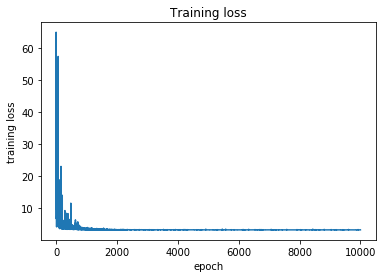

In [16]:
plt.plot(range(n_epochs), hist.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
n_test = 10
y_test_pred_ep_list = [ep_model(X_test) for _ in range(n_test)]

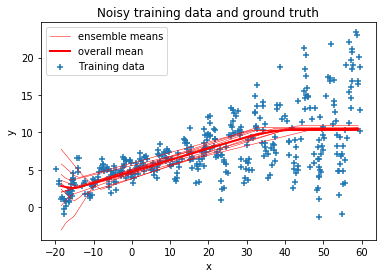

In [17]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
avg_mean = np.zeros_like(X_test)
for i, y in enumerate(y_test_pred_ep_list):
    y_mean = y.mean()
    plt.plot(X_test, y_mean, 'r-', label='ensemble means' if i == 0 else None, linewidth=0.5)
    avg_mean += y_mean
plt.plot(X_test, avg_mean/n_test, 'r-', label='overall mean', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate aleatoric + epistemic uncertainty

In [18]:
def build_aleatoric_epistemic_model(train_size):
    model_in = Input(shape=(1,))
    x = DenseVariational(8, posterior_mean_field, prior_trainable, kl_weight=1/train_size, activation='relu')(model_in)
#     x = LeakyReLU(0.1)(x)
#     x = DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
#     x = LeakyReLU(0.1)(x)
#     x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
#     x = LeakyReLU(0.1)(x)
    x = DenseVariational(1+1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],
                                                        scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])))(x)
    model = Model(model_in, model_out)
    return model

ae_model = build_aleatoric_epistemic_model(n_train)
ae_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
ae_model.summary()
hist = ae_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_variational_2 (DenseVa (None, 8)                 48        
_________________________________________________________________
dense_variational_3 (DenseVa (None, 2)                 54        
_________________________________________________________________
distribution_lambda_3 (Distr ((None, 1), (None, 1))    0         
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________
Train on 400 samples
Epoch 1/10000
400/400 - 0s - loss: 2194.1167 - mean_squared_error: 2488.9617
Epoch 2/10000
400/400 - 0s - loss: 30259179.3676 - mean_squared_error: 34134.5391
Epoch 3/10000
400/400 - 0s - loss: 304425.6254 - mean_squared_error: 6518.0117


Epoch 95/10000
400/400 - 0s - loss: 3289.3189 - mean_squared_error: 3221.5881
Epoch 96/10000
400/400 - 0s - loss: 1335.7315 - mean_squared_error: 1758.8282
Epoch 97/10000
400/400 - 0s - loss: 1302.4950 - mean_squared_error: 2611.8655
Epoch 98/10000
400/400 - 0s - loss: 4572.5536 - mean_squared_error: 5317.0059
Epoch 99/10000
400/400 - 0s - loss: 9947.2546 - mean_squared_error: 6605.9136
Epoch 100/10000
400/400 - 0s - loss: 1736.7349 - mean_squared_error: 4429.5498
Epoch 101/10000
400/400 - 0s - loss: 568.3839 - mean_squared_error: 751.0406
Epoch 102/10000
400/400 - 0s - loss: 3291.7324 - mean_squared_error: 2907.0076
Epoch 103/10000
400/400 - 0s - loss: 1714.1382 - mean_squared_error: 1750.1820
Epoch 104/10000
400/400 - 0s - loss: 3368.2834 - mean_squared_error: 1475.6545
Epoch 105/10000
400/400 - 0s - loss: 3021.7583 - mean_squared_error: 3493.1406
Epoch 106/10000
400/400 - 0s - loss: 116541.3236 - mean_squared_error: 3483.7424
Epoch 107/10000
400/400 - 0s - loss: 735.2688 - mean_squa

Epoch 199/10000
400/400 - 0s - loss: 407.6762 - mean_squared_error: 660.9890
Epoch 200/10000
400/400 - 0s - loss: 847.3524 - mean_squared_error: 1523.2725
Epoch 201/10000
400/400 - 0s - loss: 1146.4352 - mean_squared_error: 3989.8367
Epoch 202/10000
400/400 - 0s - loss: 1340.6743 - mean_squared_error: 818.5820
Epoch 203/10000
400/400 - 0s - loss: 1114.2388 - mean_squared_error: 2031.6899
Epoch 204/10000
400/400 - 0s - loss: 12317.3428 - mean_squared_error: 5160.4644
Epoch 205/10000
400/400 - 0s - loss: 658.1762 - mean_squared_error: 1978.6364
Epoch 206/10000
400/400 - 0s - loss: 1328.4195 - mean_squared_error: 1691.4669
Epoch 207/10000
400/400 - 0s - loss: 255.0933 - mean_squared_error: 222.8265
Epoch 208/10000
400/400 - 0s - loss: 1757.6152 - mean_squared_error: 2194.0349
Epoch 209/10000
400/400 - 0s - loss: 3081.2920 - mean_squared_error: 1627.6324
Epoch 210/10000
400/400 - 0s - loss: 1090.9732 - mean_squared_error: 831.2720
Epoch 211/10000
400/400 - 0s - loss: 3004.7780 - mean_squar

Epoch 304/10000
400/400 - 0s - loss: 1995.9953 - mean_squared_error: 3394.4175
Epoch 305/10000
400/400 - 0s - loss: 1512.8375 - mean_squared_error: 1312.5674
Epoch 306/10000
400/400 - 0s - loss: 4240.7976 - mean_squared_error: 2477.6726
Epoch 307/10000
400/400 - 0s - loss: 2765.4410 - mean_squared_error: 3314.2922
Epoch 308/10000
400/400 - 0s - loss: 31194.2037 - mean_squared_error: 7853.6860
Epoch 309/10000
400/400 - 0s - loss: 22804.2777 - mean_squared_error: 5752.4980
Epoch 310/10000
400/400 - 0s - loss: 3103.0503 - mean_squared_error: 2444.9312
Epoch 311/10000
400/400 - 0s - loss: 4335.5904 - mean_squared_error: 1751.3506
Epoch 312/10000
400/400 - 0s - loss: 1367.3132 - mean_squared_error: 1650.4371
Epoch 313/10000
400/400 - 0s - loss: 1478.7723 - mean_squared_error: 2844.3757
Epoch 314/10000
400/400 - 0s - loss: 4262.6431 - mean_squared_error: 1301.4780
Epoch 315/10000
400/400 - 0s - loss: 1496.5857 - mean_squared_error: 2929.2693
Epoch 316/10000
400/400 - 0s - loss: 1540.6501 - m

Epoch 409/10000
400/400 - 0s - loss: 5438.7562 - mean_squared_error: 4098.0229
Epoch 410/10000
400/400 - 0s - loss: 358.4242 - mean_squared_error: 297.8511
Epoch 411/10000
400/400 - 0s - loss: 1284.1979 - mean_squared_error: 1620.1316
Epoch 412/10000
400/400 - 0s - loss: 627.1288 - mean_squared_error: 1035.8621
Epoch 413/10000
400/400 - 0s - loss: 1812.9105 - mean_squared_error: 1917.6093
Epoch 414/10000
400/400 - 0s - loss: 2743.3108 - mean_squared_error: 2705.5554
Epoch 415/10000
400/400 - 0s - loss: 8015.5883 - mean_squared_error: 2075.5908
Epoch 416/10000
400/400 - 0s - loss: 2032.4247 - mean_squared_error: 1606.0039
Epoch 417/10000
400/400 - 0s - loss: 375.3078 - mean_squared_error: 731.2834
Epoch 418/10000
400/400 - 0s - loss: 1775.4347 - mean_squared_error: 1945.8032
Epoch 419/10000
400/400 - 0s - loss: 1350.9461 - mean_squared_error: 2401.2866
Epoch 420/10000
400/400 - 0s - loss: 2590.3342 - mean_squared_error: 3085.9561
Epoch 421/10000
400/400 - 0s - loss: 939.9263 - mean_squa

Epoch 514/10000
400/400 - 0s - loss: 3206.6813 - mean_squared_error: 9518.6064
Epoch 515/10000
400/400 - 0s - loss: 1768.9111 - mean_squared_error: 1382.7115
Epoch 516/10000
400/400 - 0s - loss: 884.6329 - mean_squared_error: 1761.3729
Epoch 517/10000
400/400 - 0s - loss: 270707.3247 - mean_squared_error: 4215.6826
Epoch 518/10000
400/400 - 0s - loss: 339.5008 - mean_squared_error: 764.7955
Epoch 519/10000
400/400 - 0s - loss: 143065.5913 - mean_squared_error: 1671.3973
Epoch 520/10000
400/400 - 0s - loss: 1828.3322 - mean_squared_error: 1363.3586
Epoch 521/10000
400/400 - 0s - loss: 40503.5003 - mean_squared_error: 6516.2217
Epoch 522/10000
400/400 - 0s - loss: 503.0376 - mean_squared_error: 839.5374
Epoch 523/10000
400/400 - 0s - loss: 662.6689 - mean_squared_error: 885.4986
Epoch 524/10000
400/400 - 0s - loss: 391.8295 - mean_squared_error: 732.6008
Epoch 525/10000
400/400 - 0s - loss: 3844.9504 - mean_squared_error: 2652.3127
Epoch 526/10000
400/400 - 0s - loss: 3122.6506 - mean_sq

Epoch 619/10000
400/400 - 0s - loss: 713.1365 - mean_squared_error: 864.6602
Epoch 620/10000
400/400 - 0s - loss: 3717.4315 - mean_squared_error: 15343.8125
Epoch 621/10000
400/400 - 0s - loss: 458.8464 - mean_squared_error: 472.5679
Epoch 622/10000
400/400 - 0s - loss: 506.4886 - mean_squared_error: 922.7493
Epoch 623/10000
400/400 - 0s - loss: 2484.3427 - mean_squared_error: 2617.3779
Epoch 624/10000
400/400 - 0s - loss: 1347.7359 - mean_squared_error: 1348.8214
Epoch 625/10000
400/400 - 0s - loss: 545.4515 - mean_squared_error: 2978.9902
Epoch 626/10000
400/400 - 0s - loss: 1349.3345 - mean_squared_error: 3903.1382
Epoch 627/10000
400/400 - 0s - loss: 4547.2716 - mean_squared_error: 5751.2974
Epoch 628/10000
400/400 - 0s - loss: 48526.9467 - mean_squared_error: 7026.0845
Epoch 629/10000
400/400 - 0s - loss: 11069.2433 - mean_squared_error: 4900.4717
Epoch 630/10000
400/400 - 0s - loss: 1203.1283 - mean_squared_error: 3704.8005
Epoch 631/10000
400/400 - 0s - loss: 1091.3536 - mean_sq

Epoch 724/10000
400/400 - 0s - loss: 659.6345 - mean_squared_error: 1406.0374
Epoch 725/10000
400/400 - 0s - loss: 2667.5988 - mean_squared_error: 6318.9663
Epoch 726/10000
400/400 - 0s - loss: 203.3471 - mean_squared_error: 262.2799
Epoch 727/10000
400/400 - 0s - loss: 5332.0896 - mean_squared_error: 2579.1982
Epoch 728/10000
400/400 - 0s - loss: 2428.7743 - mean_squared_error: 10036.8066
Epoch 729/10000
400/400 - 0s - loss: 970.3020 - mean_squared_error: 6225.2227
Epoch 730/10000
400/400 - 0s - loss: 898.1965 - mean_squared_error: 1352.7130
Epoch 731/10000
400/400 - 0s - loss: 1366.1169 - mean_squared_error: 576.1033
Epoch 732/10000
400/400 - 0s - loss: 15625.9388 - mean_squared_error: 3115.6956
Epoch 733/10000
400/400 - 0s - loss: 794.4471 - mean_squared_error: 853.7541
Epoch 734/10000
400/400 - 0s - loss: 1421.5999 - mean_squared_error: 1373.7959
Epoch 735/10000
400/400 - 0s - loss: 2193.8036 - mean_squared_error: 5144.8496
Epoch 736/10000
400/400 - 0s - loss: 3390.1142 - mean_squa

Epoch 829/10000
400/400 - 0s - loss: 2040.1267 - mean_squared_error: 2956.1885
Epoch 830/10000
400/400 - 0s - loss: 1069.3373 - mean_squared_error: 4385.4639
Epoch 831/10000
400/400 - 0s - loss: 1183.2904 - mean_squared_error: 1019.5510
Epoch 832/10000
400/400 - 0s - loss: 5570.3628 - mean_squared_error: 2859.2163
Epoch 833/10000
400/400 - 0s - loss: 3034.2046 - mean_squared_error: 2128.0728
Epoch 834/10000
400/400 - 0s - loss: 2824.4824 - mean_squared_error: 1770.0359
Epoch 835/10000
400/400 - 0s - loss: 860.8214 - mean_squared_error: 1207.1399
Epoch 836/10000
400/400 - 0s - loss: 1072.8099 - mean_squared_error: 1996.3979
Epoch 837/10000
400/400 - 0s - loss: 226.2310 - mean_squared_error: 313.0471
Epoch 838/10000
400/400 - 0s - loss: 1095.6962 - mean_squared_error: 1954.7048
Epoch 839/10000
400/400 - 0s - loss: 748.4480 - mean_squared_error: 887.6649
Epoch 840/10000
400/400 - 0s - loss: 1417.0525 - mean_squared_error: 668.3704
Epoch 841/10000
400/400 - 0s - loss: 5119.7526 - mean_squa

Epoch 934/10000
400/400 - 0s - loss: 1075.1142 - mean_squared_error: 1276.8430
Epoch 935/10000
400/400 - 0s - loss: 3992.5830 - mean_squared_error: 1950.1382
Epoch 936/10000
400/400 - 0s - loss: 5300.9658 - mean_squared_error: 3291.3738
Epoch 937/10000
400/400 - 0s - loss: 475.3967 - mean_squared_error: 633.5060
Epoch 938/10000
400/400 - 0s - loss: 1989.5347 - mean_squared_error: 3335.9075
Epoch 939/10000
400/400 - 0s - loss: 962.4674 - mean_squared_error: 720.8702
Epoch 940/10000
400/400 - 0s - loss: 1109.2782 - mean_squared_error: 3001.8938
Epoch 941/10000
400/400 - 0s - loss: 246.5125 - mean_squared_error: 297.6770
Epoch 942/10000
400/400 - 0s - loss: 1225.2323 - mean_squared_error: 1419.8778
Epoch 943/10000
400/400 - 0s - loss: 422.7979 - mean_squared_error: 826.3126
Epoch 944/10000
400/400 - 0s - loss: 964.4429 - mean_squared_error: 1804.4230
Epoch 945/10000
400/400 - 0s - loss: 734.5828 - mean_squared_error: 1236.5554
Epoch 946/10000
400/400 - 0s - loss: 1194.2695 - mean_squared_

Epoch 1039/10000
400/400 - 0s - loss: 557.5952 - mean_squared_error: 1350.9744
Epoch 1040/10000
400/400 - 0s - loss: 2992.9775 - mean_squared_error: 1291.1243
Epoch 1041/10000
400/400 - 0s - loss: 697.0812 - mean_squared_error: 1803.4293
Epoch 1042/10000
400/400 - 0s - loss: 418.5762 - mean_squared_error: 851.6233
Epoch 1043/10000
400/400 - 0s - loss: 1191.3388 - mean_squared_error: 1038.1974
Epoch 1044/10000
400/400 - 0s - loss: 1179.7989 - mean_squared_error: 800.1445
Epoch 1045/10000
400/400 - 0s - loss: 191.5228 - mean_squared_error: 378.6980
Epoch 1046/10000
400/400 - 0s - loss: 554.4367 - mean_squared_error: 1654.6830
Epoch 1047/10000
400/400 - 0s - loss: 724.1579 - mean_squared_error: 675.3736
Epoch 1048/10000
400/400 - 0s - loss: 1127.3035 - mean_squared_error: 956.9620
Epoch 1049/10000
400/400 - 0s - loss: 2976.1430 - mean_squared_error: 3885.7900
Epoch 1050/10000
400/400 - 0s - loss: 967.9204 - mean_squared_error: 2563.1716
Epoch 1051/10000
400/400 - 0s - loss: 196.2208 - mea

Epoch 1143/10000
400/400 - 0s - loss: 439.9514 - mean_squared_error: 606.0545
Epoch 1144/10000
400/400 - 0s - loss: 2527.3433 - mean_squared_error: 3017.7429
Epoch 1145/10000
400/400 - 0s - loss: 1200.8462 - mean_squared_error: 1254.0858
Epoch 1146/10000
400/400 - 0s - loss: 760.9157 - mean_squared_error: 3653.5176
Epoch 1147/10000
400/400 - 0s - loss: 684.8786 - mean_squared_error: 1237.2626
Epoch 1148/10000
400/400 - 0s - loss: 2146.5019 - mean_squared_error: 2729.4773
Epoch 1149/10000
400/400 - 0s - loss: 2388.6052 - mean_squared_error: 3358.2493
Epoch 1150/10000
400/400 - 0s - loss: 1258.8509 - mean_squared_error: 1604.7651
Epoch 1151/10000
400/400 - 0s - loss: 5732.3704 - mean_squared_error: 1085.8788
Epoch 1152/10000
400/400 - 0s - loss: 2092.6428 - mean_squared_error: 2876.0356
Epoch 1153/10000
400/400 - 0s - loss: 1215.1370 - mean_squared_error: 738.5048
Epoch 1154/10000
400/400 - 0s - loss: 1516.2554 - mean_squared_error: 2170.5740
Epoch 1155/10000
400/400 - 0s - loss: 209.167

Epoch 1247/10000
400/400 - 0s - loss: 315.0290 - mean_squared_error: 209.5276
Epoch 1248/10000
400/400 - 0s - loss: 340.8555 - mean_squared_error: 690.4645
Epoch 1249/10000
400/400 - 0s - loss: 424.3761 - mean_squared_error: 942.8964
Epoch 1250/10000
400/400 - 0s - loss: 153.4548 - mean_squared_error: 141.9713
Epoch 1251/10000
400/400 - 0s - loss: 695.4661 - mean_squared_error: 1114.9192
Epoch 1252/10000
400/400 - 0s - loss: 391.1842 - mean_squared_error: 346.4169
Epoch 1253/10000
400/400 - 0s - loss: 1534.3045 - mean_squared_error: 1915.1626
Epoch 1254/10000
400/400 - 0s - loss: 1802.0979 - mean_squared_error: 1675.6383
Epoch 1255/10000
400/400 - 0s - loss: 228.0224 - mean_squared_error: 315.0527
Epoch 1256/10000
400/400 - 0s - loss: 224.4818 - mean_squared_error: 375.8063
Epoch 1257/10000
400/400 - 0s - loss: 4318.3846 - mean_squared_error: 4726.2583
Epoch 1258/10000
400/400 - 0s - loss: 2019.8427 - mean_squared_error: 4340.5674
Epoch 1259/10000
400/400 - 0s - loss: 424.7587 - mean_s

Epoch 1351/10000
400/400 - 0s - loss: 558.4539 - mean_squared_error: 1224.9862
Epoch 1352/10000
400/400 - 0s - loss: 250.5738 - mean_squared_error: 404.0315
Epoch 1353/10000
400/400 - 0s - loss: 1526.0764 - mean_squared_error: 1640.5381
Epoch 1354/10000
400/400 - 0s - loss: 964.7592 - mean_squared_error: 658.9807
Epoch 1355/10000
400/400 - 0s - loss: 830.3094 - mean_squared_error: 1429.7594
Epoch 1356/10000
400/400 - 0s - loss: 1832.9269 - mean_squared_error: 3685.4321
Epoch 1357/10000
400/400 - 0s - loss: 1129.6393 - mean_squared_error: 482.4399
Epoch 1358/10000
400/400 - 0s - loss: 554.7971 - mean_squared_error: 1157.0082
Epoch 1359/10000
400/400 - 0s - loss: 332.5995 - mean_squared_error: 547.4417
Epoch 1360/10000
400/400 - 0s - loss: 374.4433 - mean_squared_error: 382.3756
Epoch 1361/10000
400/400 - 0s - loss: 439.0211 - mean_squared_error: 880.5767
Epoch 1362/10000
400/400 - 0s - loss: 990.8905 - mean_squared_error: 1224.7550
Epoch 1363/10000
400/400 - 0s - loss: 218.4846 - mean_s

Epoch 1455/10000
400/400 - 0s - loss: 534.8697 - mean_squared_error: 1393.1808
Epoch 1456/10000
400/400 - 0s - loss: 590.0665 - mean_squared_error: 1255.4264
Epoch 1457/10000
400/400 - 0s - loss: 187.2113 - mean_squared_error: 433.4386
Epoch 1458/10000
400/400 - 0s - loss: 1375.3924 - mean_squared_error: 1878.9078
Epoch 1459/10000
400/400 - 0s - loss: 189.4995 - mean_squared_error: 588.9487
Epoch 1460/10000
400/400 - 0s - loss: 1521.4586 - mean_squared_error: 2228.6526
Epoch 1461/10000
400/400 - 0s - loss: 278.0541 - mean_squared_error: 928.8456
Epoch 1462/10000
400/400 - 0s - loss: 1082.4823 - mean_squared_error: 1492.5704
Epoch 1463/10000
400/400 - 0s - loss: 490.3558 - mean_squared_error: 994.9025
Epoch 1464/10000
400/400 - 0s - loss: 1914.0053 - mean_squared_error: 3719.7490
Epoch 1465/10000
400/400 - 0s - loss: 182.6136 - mean_squared_error: 438.1249
Epoch 1466/10000
400/400 - 0s - loss: 420.8134 - mean_squared_error: 588.9998
Epoch 1467/10000
400/400 - 0s - loss: 1730.2573 - mean

Epoch 1559/10000
400/400 - 0s - loss: 735.7194 - mean_squared_error: 2196.1028
Epoch 1560/10000
400/400 - 0s - loss: 224.6194 - mean_squared_error: 246.4191
Epoch 1561/10000
400/400 - 0s - loss: 883.8594 - mean_squared_error: 1233.3678
Epoch 1562/10000
400/400 - 0s - loss: 2212.6923 - mean_squared_error: 712.3408
Epoch 1563/10000
400/400 - 0s - loss: 3008.1133 - mean_squared_error: 1563.3610
Epoch 1564/10000
400/400 - 0s - loss: 413.8133 - mean_squared_error: 1091.5358
Epoch 1565/10000
400/400 - 0s - loss: 409.5118 - mean_squared_error: 888.5664
Epoch 1566/10000
400/400 - 0s - loss: 470.9588 - mean_squared_error: 651.1902
Epoch 1567/10000
400/400 - 0s - loss: 752.4043 - mean_squared_error: 1527.1223
Epoch 1568/10000
400/400 - 0s - loss: 292.0040 - mean_squared_error: 270.5113
Epoch 1569/10000
400/400 - 0s - loss: 597.5521 - mean_squared_error: 1196.7108
Epoch 1570/10000
400/400 - 0s - loss: 327.9923 - mean_squared_error: 1005.3022
Epoch 1571/10000
400/400 - 0s - loss: 1714.4148 - mean_

Epoch 1663/10000
400/400 - 0s - loss: 1053.1375 - mean_squared_error: 1522.2203
Epoch 1664/10000
400/400 - 0s - loss: 928.5407 - mean_squared_error: 1325.1395
Epoch 1665/10000
400/400 - 0s - loss: 527.9191 - mean_squared_error: 2503.7000
Epoch 1666/10000
400/400 - 0s - loss: 1729.3691 - mean_squared_error: 2717.5225
Epoch 1667/10000
400/400 - 0s - loss: 337.3914 - mean_squared_error: 1487.0312
Epoch 1668/10000
400/400 - 0s - loss: 262.9419 - mean_squared_error: 314.2271
Epoch 1669/10000
400/400 - 0s - loss: 78.2117 - mean_squared_error: 115.9060
Epoch 1670/10000
400/400 - 0s - loss: 564.9643 - mean_squared_error: 1261.4387
Epoch 1671/10000
400/400 - 0s - loss: 695.3491 - mean_squared_error: 2832.3093
Epoch 1672/10000
400/400 - 0s - loss: 467.4007 - mean_squared_error: 400.4006
Epoch 1673/10000
400/400 - 0s - loss: 2559.6397 - mean_squared_error: 4298.3569
Epoch 1674/10000
400/400 - 0s - loss: 197.7806 - mean_squared_error: 531.5148
Epoch 1675/10000
400/400 - 0s - loss: 851.5505 - mean_

Epoch 1767/10000
400/400 - 0s - loss: 310.9843 - mean_squared_error: 767.7171
Epoch 1768/10000
400/400 - 0s - loss: 1858.1785 - mean_squared_error: 968.2095
Epoch 1769/10000
400/400 - 0s - loss: 343.9014 - mean_squared_error: 501.1117
Epoch 1770/10000
400/400 - 0s - loss: 73.3009 - mean_squared_error: 105.9263
Epoch 1771/10000
400/400 - 0s - loss: 1165.0027 - mean_squared_error: 868.0701
Epoch 1772/10000
400/400 - 0s - loss: 591.3141 - mean_squared_error: 1398.7672
Epoch 1773/10000
400/400 - 0s - loss: 302.1292 - mean_squared_error: 649.3893
Epoch 1774/10000
400/400 - 0s - loss: 448.6595 - mean_squared_error: 1336.9951
Epoch 1775/10000
400/400 - 0s - loss: 1249.1662 - mean_squared_error: 1462.0032
Epoch 1776/10000
400/400 - 0s - loss: 1219.1839 - mean_squared_error: 1687.8280
Epoch 1777/10000
400/400 - 0s - loss: 264.5354 - mean_squared_error: 234.6249
Epoch 1778/10000
400/400 - 0s - loss: 423.1778 - mean_squared_error: 1432.5826
Epoch 1779/10000
400/400 - 0s - loss: 153590.6933 - mean

Epoch 1871/10000
400/400 - 0s - loss: 540.3784 - mean_squared_error: 1781.5458
Epoch 1872/10000
400/400 - 0s - loss: 2092.7618 - mean_squared_error: 1517.5680
Epoch 1873/10000
400/400 - 0s - loss: 480.4449 - mean_squared_error: 1517.6155
Epoch 1874/10000
400/400 - 0s - loss: 430.2189 - mean_squared_error: 891.8794
Epoch 1875/10000
400/400 - 0s - loss: 128.9393 - mean_squared_error: 177.5755
Epoch 1876/10000
400/400 - 0s - loss: 672.7258 - mean_squared_error: 654.3643
Epoch 1877/10000
400/400 - 0s - loss: 209.0064 - mean_squared_error: 232.8503
Epoch 1878/10000
400/400 - 0s - loss: 250.4854 - mean_squared_error: 929.8354
Epoch 1879/10000
400/400 - 0s - loss: 524.8141 - mean_squared_error: 1332.0286
Epoch 1880/10000
400/400 - 0s - loss: 492.0326 - mean_squared_error: 1152.8236
Epoch 1881/10000
400/400 - 0s - loss: 1554.8486 - mean_squared_error: 2077.9248
Epoch 1882/10000
400/400 - 0s - loss: 257.6788 - mean_squared_error: 980.5635
Epoch 1883/10000
400/400 - 0s - loss: 206.7766 - mean_sq

Epoch 1976/10000
400/400 - 0s - loss: 467.7698 - mean_squared_error: 1066.3116
Epoch 1977/10000
400/400 - 0s - loss: 869.7615 - mean_squared_error: 1654.1918
Epoch 1978/10000
400/400 - 0s - loss: 1204.0817 - mean_squared_error: 1148.1073
Epoch 1979/10000
400/400 - 0s - loss: 97.7963 - mean_squared_error: 307.4221
Epoch 1980/10000
400/400 - 0s - loss: 399.8915 - mean_squared_error: 707.3211
Epoch 1981/10000
400/400 - 0s - loss: 494.2427 - mean_squared_error: 2270.2844
Epoch 1982/10000
400/400 - 0s - loss: 450.7815 - mean_squared_error: 547.3803
Epoch 1983/10000
400/400 - 0s - loss: 219.3403 - mean_squared_error: 406.3394
Epoch 1984/10000
400/400 - 0s - loss: 3371.8968 - mean_squared_error: 2624.5662
Epoch 1985/10000
400/400 - 0s - loss: 372.6671 - mean_squared_error: 689.8050
Epoch 1986/10000
400/400 - 0s - loss: 335.6561 - mean_squared_error: 697.6752
Epoch 1987/10000
400/400 - 0s - loss: 161.5542 - mean_squared_error: 444.3209
Epoch 1988/10000
400/400 - 0s - loss: 253.7436 - mean_squa

Epoch 2081/10000
400/400 - 0s - loss: 227.9162 - mean_squared_error: 655.8359
Epoch 2082/10000
400/400 - 0s - loss: 90.7312 - mean_squared_error: 144.4227
Epoch 2083/10000
400/400 - 0s - loss: 240.7142 - mean_squared_error: 623.7962
Epoch 2084/10000
400/400 - 0s - loss: 272.5186 - mean_squared_error: 839.0831
Epoch 2085/10000
400/400 - 0s - loss: 169.0593 - mean_squared_error: 438.7136
Epoch 2086/10000
400/400 - 0s - loss: 521.5182 - mean_squared_error: 1347.4822
Epoch 2087/10000
400/400 - 0s - loss: 402.4450 - mean_squared_error: 636.9291
Epoch 2088/10000
400/400 - 0s - loss: 166.2239 - mean_squared_error: 421.5817
Epoch 2089/10000
400/400 - 0s - loss: 526.0400 - mean_squared_error: 490.2615
Epoch 2090/10000
400/400 - 0s - loss: 632.6666 - mean_squared_error: 783.6451
Epoch 2091/10000
400/400 - 0s - loss: 463.2728 - mean_squared_error: 1120.3561
Epoch 2092/10000
400/400 - 0s - loss: 513.2108 - mean_squared_error: 3251.5254
Epoch 2093/10000
400/400 - 0s - loss: 246.2569 - mean_squared_

Epoch 2186/10000
400/400 - 0s - loss: 657.6940 - mean_squared_error: 1723.9856
Epoch 2187/10000
400/400 - 0s - loss: 1027.3875 - mean_squared_error: 1559.2504
Epoch 2188/10000
400/400 - 0s - loss: 222.7757 - mean_squared_error: 1048.4506
Epoch 2189/10000
400/400 - 0s - loss: 580.6243 - mean_squared_error: 668.9034
Epoch 2190/10000
400/400 - 0s - loss: 169.8290 - mean_squared_error: 322.4192
Epoch 2191/10000
400/400 - 0s - loss: 1849.1958 - mean_squared_error: 1591.2407
Epoch 2192/10000
400/400 - 0s - loss: 786.1858 - mean_squared_error: 1768.2812
Epoch 2193/10000
400/400 - 0s - loss: 501.5352 - mean_squared_error: 933.6183
Epoch 2194/10000
400/400 - 0s - loss: 283.0210 - mean_squared_error: 592.1940
Epoch 2195/10000
400/400 - 0s - loss: 970.7294 - mean_squared_error: 2481.1584
Epoch 2196/10000
400/400 - 0s - loss: 236.7996 - mean_squared_error: 938.0073
Epoch 2197/10000
400/400 - 0s - loss: 562.5173 - mean_squared_error: 1594.7178
Epoch 2198/10000
400/400 - 0s - loss: 465.1052 - mean_s

Epoch 2291/10000
400/400 - 0s - loss: 304.9919 - mean_squared_error: 982.4775
Epoch 2292/10000
400/400 - 0s - loss: 324.2808 - mean_squared_error: 336.8471
Epoch 2293/10000
400/400 - 0s - loss: 484.6881 - mean_squared_error: 357.9801
Epoch 2294/10000
400/400 - 0s - loss: 264.4490 - mean_squared_error: 592.2648
Epoch 2295/10000
400/400 - 0s - loss: 455.3705 - mean_squared_error: 957.6526
Epoch 2296/10000
400/400 - 0s - loss: 312.3801 - mean_squared_error: 458.6839
Epoch 2297/10000
400/400 - 0s - loss: 822.3783 - mean_squared_error: 2999.3513
Epoch 2298/10000
400/400 - 0s - loss: 178.0962 - mean_squared_error: 259.2420
Epoch 2299/10000
400/400 - 0s - loss: 179.6588 - mean_squared_error: 945.8195
Epoch 2300/10000
400/400 - 0s - loss: 466.0739 - mean_squared_error: 1730.3383
Epoch 2301/10000
400/400 - 0s - loss: 780.7992 - mean_squared_error: 2257.8301
Epoch 2302/10000
400/400 - 0s - loss: 200.4622 - mean_squared_error: 246.9164
Epoch 2303/10000
400/400 - 0s - loss: 120.7945 - mean_squared

Epoch 2396/10000
400/400 - 0s - loss: 360.7324 - mean_squared_error: 1973.3514
Epoch 2397/10000
400/400 - 0s - loss: 328.6664 - mean_squared_error: 1356.5602
Epoch 2398/10000
400/400 - 0s - loss: 300.2295 - mean_squared_error: 818.1259
Epoch 2399/10000
400/400 - 0s - loss: 248.7919 - mean_squared_error: 1297.0350
Epoch 2400/10000
400/400 - 0s - loss: 224.8620 - mean_squared_error: 817.1381
Epoch 2401/10000
400/400 - 0s - loss: 436.1999 - mean_squared_error: 744.5356
Epoch 2402/10000
400/400 - 0s - loss: 414.3234 - mean_squared_error: 849.4460
Epoch 2403/10000
400/400 - 0s - loss: 578.3748 - mean_squared_error: 1175.2496
Epoch 2404/10000
400/400 - 0s - loss: 78.1045 - mean_squared_error: 413.6259
Epoch 2405/10000
400/400 - 0s - loss: 167.4367 - mean_squared_error: 2067.9807
Epoch 2406/10000
400/400 - 0s - loss: 63.3782 - mean_squared_error: 208.5995
Epoch 2407/10000
400/400 - 0s - loss: 187.9628 - mean_squared_error: 424.1057
Epoch 2408/10000
400/400 - 0s - loss: 85.2345 - mean_squared_

Epoch 2501/10000
400/400 - 0s - loss: 508.0324 - mean_squared_error: 3723.5679
Epoch 2502/10000
400/400 - 0s - loss: 202.0986 - mean_squared_error: 2666.1616
Epoch 2503/10000
400/400 - 0s - loss: 435.3867 - mean_squared_error: 1768.2532
Epoch 2504/10000
400/400 - 0s - loss: 153.3293 - mean_squared_error: 936.7455
Epoch 2505/10000
400/400 - 0s - loss: 503.3002 - mean_squared_error: 2685.3948
Epoch 2506/10000
400/400 - 0s - loss: 450.3591 - mean_squared_error: 831.6167
Epoch 2507/10000
400/400 - 0s - loss: 572.6726 - mean_squared_error: 765.6721
Epoch 2508/10000
400/400 - 0s - loss: 971.0757 - mean_squared_error: 4227.1802
Epoch 2509/10000
400/400 - 0s - loss: 93.0449 - mean_squared_error: 365.2625
Epoch 2510/10000
400/400 - 0s - loss: 1969.3450 - mean_squared_error: 395.9285
Epoch 2511/10000
400/400 - 0s - loss: 191.9685 - mean_squared_error: 628.0961
Epoch 2512/10000
400/400 - 0s - loss: 126.5593 - mean_squared_error: 170.2365
Epoch 2513/10000
400/400 - 0s - loss: 2951.8447 - mean_squa

Epoch 2606/10000
400/400 - 0s - loss: 26.0207 - mean_squared_error: 70.9549
Epoch 2607/10000
400/400 - 0s - loss: 146.6736 - mean_squared_error: 543.4130
Epoch 2608/10000
400/400 - 0s - loss: 2881.4644 - mean_squared_error: 2153.4412
Epoch 2609/10000
400/400 - 0s - loss: 205.4840 - mean_squared_error: 496.8030
Epoch 2610/10000
400/400 - 0s - loss: 77161.4147 - mean_squared_error: 1253.7476
Epoch 2611/10000
400/400 - 0s - loss: 134.2222 - mean_squared_error: 306.9682
Epoch 2612/10000
400/400 - 0s - loss: 924.8229 - mean_squared_error: 2775.5884
Epoch 2613/10000
400/400 - 0s - loss: 216.0875 - mean_squared_error: 529.5168
Epoch 2614/10000
400/400 - 0s - loss: 166.9725 - mean_squared_error: 384.3562
Epoch 2615/10000
400/400 - 0s - loss: 168.8547 - mean_squared_error: 756.0701
Epoch 2616/10000
400/400 - 0s - loss: 809.2327 - mean_squared_error: 1279.5406
Epoch 2617/10000
400/400 - 0s - loss: 203.4109 - mean_squared_error: 1106.0043
Epoch 2618/10000
400/400 - 0s - loss: 346.8159 - mean_squa

Epoch 2711/10000
400/400 - 0s - loss: 220.9405 - mean_squared_error: 440.1801
Epoch 2712/10000
400/400 - 0s - loss: 75.2621 - mean_squared_error: 189.1556
Epoch 2713/10000
400/400 - 0s - loss: 143.9774 - mean_squared_error: 418.1243
Epoch 2714/10000
400/400 - 0s - loss: 277.5234 - mean_squared_error: 429.8378
Epoch 2715/10000
400/400 - 0s - loss: 989.1407 - mean_squared_error: 1273.9017
Epoch 2716/10000
400/400 - 0s - loss: 110.4184 - mean_squared_error: 223.2175
Epoch 2717/10000
400/400 - 0s - loss: 99.9767 - mean_squared_error: 173.8188
Epoch 2718/10000
400/400 - 0s - loss: 193.1337 - mean_squared_error: 785.7856
Epoch 2719/10000
400/400 - 0s - loss: 130.6670 - mean_squared_error: 542.8026
Epoch 2720/10000
400/400 - 0s - loss: 57.0756 - mean_squared_error: 153.5291
Epoch 2721/10000
400/400 - 0s - loss: 837.0759 - mean_squared_error: 1022.5868
Epoch 2722/10000
400/400 - 0s - loss: 660.4266 - mean_squared_error: 1840.4269
Epoch 2723/10000
400/400 - 0s - loss: 69.4695 - mean_squared_err

400/400 - 0s - loss: 55.7102 - mean_squared_error: 112.8820
Epoch 2817/10000
400/400 - 0s - loss: 51.4242 - mean_squared_error: 89.5525
Epoch 2818/10000
400/400 - 0s - loss: 396.1631 - mean_squared_error: 1818.6881
Epoch 2819/10000
400/400 - 0s - loss: 248.7111 - mean_squared_error: 1227.2461
Epoch 2820/10000
400/400 - 0s - loss: 174.3092 - mean_squared_error: 817.6050
Epoch 2821/10000
400/400 - 0s - loss: 126.1552 - mean_squared_error: 292.0609
Epoch 2822/10000
400/400 - 0s - loss: 58.6126 - mean_squared_error: 108.0100
Epoch 2823/10000
400/400 - 0s - loss: 473.8461 - mean_squared_error: 829.8478
Epoch 2824/10000
400/400 - 0s - loss: 973.1193 - mean_squared_error: 1109.2421
Epoch 2825/10000
400/400 - 0s - loss: 93.1713 - mean_squared_error: 290.3987
Epoch 2826/10000
400/400 - 0s - loss: 178.6870 - mean_squared_error: 480.3291
Epoch 2827/10000
400/400 - 0s - loss: 225.3696 - mean_squared_error: 661.5214
Epoch 2828/10000
400/400 - 0s - loss: 311.4541 - mean_squared_error: 990.6559
Epoch

Epoch 2922/10000
400/400 - 0s - loss: 87.9165 - mean_squared_error: 393.7831
Epoch 2923/10000
400/400 - 0s - loss: 131.0076 - mean_squared_error: 196.1358
Epoch 2924/10000
400/400 - 0s - loss: 68.4501 - mean_squared_error: 403.0400
Epoch 2925/10000
400/400 - 0s - loss: 104.6841 - mean_squared_error: 99.6803
Epoch 2926/10000
400/400 - 0s - loss: 89.9941 - mean_squared_error: 250.7471
Epoch 2927/10000
400/400 - 0s - loss: 1068.1933 - mean_squared_error: 682.4169
Epoch 2928/10000
400/400 - 0s - loss: 66.2180 - mean_squared_error: 98.2887
Epoch 2929/10000
400/400 - 0s - loss: 204.6588 - mean_squared_error: 1002.3690
Epoch 2930/10000
400/400 - 0s - loss: 108.0270 - mean_squared_error: 557.1078
Epoch 2931/10000
400/400 - 0s - loss: 202.2206 - mean_squared_error: 596.8333
Epoch 2932/10000
400/400 - 0s - loss: 319.4221 - mean_squared_error: 1756.1506
Epoch 2933/10000
400/400 - 0s - loss: 44.2966 - mean_squared_error: 100.2023
Epoch 2934/10000
400/400 - 0s - loss: 119.3927 - mean_squared_error:

Epoch 3028/10000
400/400 - 0s - loss: 517.3472 - mean_squared_error: 949.0093
Epoch 3029/10000
400/400 - 0s - loss: 285.9172 - mean_squared_error: 1301.0221
Epoch 3030/10000
400/400 - 0s - loss: 68.3523 - mean_squared_error: 492.8217
Epoch 3031/10000
400/400 - 0s - loss: 270.3786 - mean_squared_error: 2243.2659
Epoch 3032/10000
400/400 - 0s - loss: 113.3102 - mean_squared_error: 419.3461
Epoch 3033/10000
400/400 - 0s - loss: 128.0502 - mean_squared_error: 366.4205
Epoch 3034/10000
400/400 - 0s - loss: 158.4154 - mean_squared_error: 433.2540
Epoch 3035/10000
400/400 - 0s - loss: 249.1010 - mean_squared_error: 544.4357
Epoch 3036/10000
400/400 - 0s - loss: 226.4065 - mean_squared_error: 467.0988
Epoch 3037/10000
400/400 - 0s - loss: 173.8000 - mean_squared_error: 1288.1542
Epoch 3038/10000
400/400 - 0s - loss: 78.9059 - mean_squared_error: 325.0457
Epoch 3039/10000
400/400 - 0s - loss: 376.6667 - mean_squared_error: 756.1913
Epoch 3040/10000
400/400 - 0s - loss: 80.5053 - mean_squared_er

Epoch 3134/10000
400/400 - 0s - loss: 43.4722 - mean_squared_error: 167.3513
Epoch 3135/10000
400/400 - 0s - loss: 143.7545 - mean_squared_error: 602.8485
Epoch 3136/10000
400/400 - 0s - loss: 67.5719 - mean_squared_error: 276.6282
Epoch 3137/10000
400/400 - 0s - loss: 60.5300 - mean_squared_error: 262.4893
Epoch 3138/10000
400/400 - 0s - loss: 85.9664 - mean_squared_error: 200.6224
Epoch 3139/10000
400/400 - 0s - loss: 1535.2401 - mean_squared_error: 600.8372
Epoch 3140/10000
400/400 - 0s - loss: 85.7800 - mean_squared_error: 554.8229
Epoch 3141/10000
400/400 - 0s - loss: 235.4295 - mean_squared_error: 1205.5288
Epoch 3142/10000
400/400 - 0s - loss: 271.6277 - mean_squared_error: 2592.4014
Epoch 3143/10000
400/400 - 0s - loss: 136.3096 - mean_squared_error: 416.0466
Epoch 3144/10000
400/400 - 0s - loss: 282.5766 - mean_squared_error: 2156.8921
Epoch 3145/10000
400/400 - 0s - loss: 41.4582 - mean_squared_error: 157.4697
Epoch 3146/10000
400/400 - 0s - loss: 458.3280 - mean_squared_erro

Epoch 3240/10000
400/400 - 0s - loss: 54.9833 - mean_squared_error: 114.7204
Epoch 3241/10000
400/400 - 0s - loss: 267.8114 - mean_squared_error: 539.5891
Epoch 3242/10000
400/400 - 0s - loss: 47.1384 - mean_squared_error: 235.6795
Epoch 3243/10000
400/400 - 0s - loss: 191.3885 - mean_squared_error: 640.4825
Epoch 3244/10000
400/400 - 0s - loss: 79.4720 - mean_squared_error: 258.5706
Epoch 3245/10000
400/400 - 0s - loss: 114.3528 - mean_squared_error: 749.5985
Epoch 3246/10000
400/400 - 0s - loss: 36.4231 - mean_squared_error: 101.2152
Epoch 3247/10000
400/400 - 0s - loss: 75.6938 - mean_squared_error: 204.3683
Epoch 3248/10000
400/400 - 0s - loss: 108.0946 - mean_squared_error: 500.2298
Epoch 3249/10000
400/400 - 0s - loss: 98.8587 - mean_squared_error: 266.3324
Epoch 3250/10000
400/400 - 0s - loss: 90.7955 - mean_squared_error: 285.3251
Epoch 3251/10000
400/400 - 0s - loss: 97.0839 - mean_squared_error: 492.7238
Epoch 3252/10000
400/400 - 0s - loss: 40.7592 - mean_squared_error: 113.

Epoch 3346/10000
400/400 - 0s - loss: 28.2076 - mean_squared_error: 127.4459
Epoch 3347/10000
400/400 - 0s - loss: 123.0014 - mean_squared_error: 545.4131
Epoch 3348/10000
400/400 - 0s - loss: 34.4842 - mean_squared_error: 133.5598
Epoch 3349/10000
400/400 - 0s - loss: 147.8675 - mean_squared_error: 480.7801
Epoch 3350/10000
400/400 - 0s - loss: 48.7299 - mean_squared_error: 328.0353
Epoch 3351/10000
400/400 - 0s - loss: 67.9072 - mean_squared_error: 291.7617
Epoch 3352/10000
400/400 - 0s - loss: 46.3369 - mean_squared_error: 272.6482
Epoch 3353/10000
400/400 - 0s - loss: 54.0988 - mean_squared_error: 147.7096
Epoch 3354/10000
400/400 - 0s - loss: 70.1322 - mean_squared_error: 145.5652
Epoch 3355/10000
400/400 - 0s - loss: 169.9672 - mean_squared_error: 690.0527
Epoch 3356/10000
400/400 - 0s - loss: 32.3768 - mean_squared_error: 182.4113
Epoch 3357/10000
400/400 - 0s - loss: 140.0205 - mean_squared_error: 451.2635
Epoch 3358/10000
400/400 - 0s - loss: 16.9866 - mean_squared_error: 83.1

Epoch 3452/10000
400/400 - 0s - loss: 73.5635 - mean_squared_error: 123.6786
Epoch 3453/10000
400/400 - 0s - loss: 19.0126 - mean_squared_error: 126.7884
Epoch 3454/10000
400/400 - 0s - loss: 91.1640 - mean_squared_error: 424.1862
Epoch 3455/10000
400/400 - 0s - loss: 314.5195 - mean_squared_error: 675.2435
Epoch 3456/10000
400/400 - 0s - loss: 44.8357 - mean_squared_error: 229.7268
Epoch 3457/10000
400/400 - 0s - loss: 90.1311 - mean_squared_error: 103.6799
Epoch 3458/10000
400/400 - 0s - loss: 40.4290 - mean_squared_error: 89.9771
Epoch 3459/10000
400/400 - 0s - loss: 55.4133 - mean_squared_error: 105.8397
Epoch 3460/10000
400/400 - 0s - loss: 16.1474 - mean_squared_error: 63.6818
Epoch 3461/10000
400/400 - 0s - loss: 180.3687 - mean_squared_error: 287.7543
Epoch 3462/10000
400/400 - 0s - loss: 103.0327 - mean_squared_error: 326.3497
Epoch 3463/10000
400/400 - 0s - loss: 81.5997 - mean_squared_error: 264.1475
Epoch 3464/10000
400/400 - 0s - loss: 167.0873 - mean_squared_error: 419.87

Epoch 3559/10000
400/400 - 0s - loss: 53.3822 - mean_squared_error: 436.9181
Epoch 3560/10000
400/400 - 0s - loss: 97.0450 - mean_squared_error: 249.4302
Epoch 3561/10000
400/400 - 0s - loss: 59.0639 - mean_squared_error: 186.6147
Epoch 3562/10000
400/400 - 0s - loss: 73.0346 - mean_squared_error: 115.7729
Epoch 3563/10000
400/400 - 0s - loss: 115.5244 - mean_squared_error: 438.5829
Epoch 3564/10000
400/400 - 0s - loss: 68.6650 - mean_squared_error: 318.3458
Epoch 3565/10000
400/400 - 0s - loss: 53.9585 - mean_squared_error: 138.0070
Epoch 3566/10000
400/400 - 0s - loss: 66.3479 - mean_squared_error: 142.4691
Epoch 3567/10000
400/400 - 0s - loss: 171.3291 - mean_squared_error: 1148.9553
Epoch 3568/10000
400/400 - 0s - loss: 89.0524 - mean_squared_error: 632.2953
Epoch 3569/10000
400/400 - 0s - loss: 57.6236 - mean_squared_error: 182.1748
Epoch 3570/10000
400/400 - 0s - loss: 42.1670 - mean_squared_error: 151.7374
Epoch 3571/10000
400/400 - 0s - loss: 29.6264 - mean_squared_error: 43.60

Epoch 3666/10000
400/400 - 0s - loss: 392.1513 - mean_squared_error: 958.6104
Epoch 3667/10000
400/400 - 0s - loss: 35.2305 - mean_squared_error: 332.1582
Epoch 3668/10000
400/400 - 0s - loss: 77.2440 - mean_squared_error: 176.2598
Epoch 3669/10000
400/400 - 0s - loss: 54.0796 - mean_squared_error: 136.1544
Epoch 3670/10000
400/400 - 0s - loss: 117.3591 - mean_squared_error: 343.9829
Epoch 3671/10000
400/400 - 0s - loss: 63.5865 - mean_squared_error: 187.5386
Epoch 3672/10000
400/400 - 0s - loss: 41.8290 - mean_squared_error: 111.4091
Epoch 3673/10000
400/400 - 0s - loss: 58.2111 - mean_squared_error: 72.9306
Epoch 3674/10000
400/400 - 0s - loss: 323.3384 - mean_squared_error: 923.8867
Epoch 3675/10000
400/400 - 0s - loss: 163.0451 - mean_squared_error: 622.0687
Epoch 3676/10000
400/400 - 0s - loss: 46.4873 - mean_squared_error: 246.9395
Epoch 3677/10000
400/400 - 0s - loss: 77.6649 - mean_squared_error: 307.8399
Epoch 3678/10000
400/400 - 0s - loss: 104.9686 - mean_squared_error: 1150

400/400 - 0s - loss: 198.4389 - mean_squared_error: 273.0600
Epoch 3773/10000
400/400 - 0s - loss: 53.0709 - mean_squared_error: 145.0551
Epoch 3774/10000
400/400 - 0s - loss: 63.8780 - mean_squared_error: 129.8789
Epoch 3775/10000
400/400 - 0s - loss: 56.1752 - mean_squared_error: 239.1568
Epoch 3776/10000
400/400 - 0s - loss: 47.4834 - mean_squared_error: 844.3484
Epoch 3777/10000
400/400 - 0s - loss: 58.1173 - mean_squared_error: 249.9783
Epoch 3778/10000
400/400 - 0s - loss: 64.4318 - mean_squared_error: 234.9599
Epoch 3779/10000
400/400 - 0s - loss: 56.6014 - mean_squared_error: 411.3203
Epoch 3780/10000
400/400 - 0s - loss: 28.8116 - mean_squared_error: 350.4388
Epoch 3781/10000
400/400 - 0s - loss: 52.5084 - mean_squared_error: 301.6631
Epoch 3782/10000
400/400 - 0s - loss: 39.9171 - mean_squared_error: 493.8853
Epoch 3783/10000
400/400 - 0s - loss: 35.9432 - mean_squared_error: 400.8163
Epoch 3784/10000
400/400 - 0s - loss: 77.6152 - mean_squared_error: 217.2317
Epoch 3785/1000

Epoch 3879/10000
400/400 - 0s - loss: 56.0669 - mean_squared_error: 257.0334
Epoch 3880/10000
400/400 - 0s - loss: 69.9824 - mean_squared_error: 261.6880
Epoch 3881/10000
400/400 - 0s - loss: 36.2178 - mean_squared_error: 231.0611
Epoch 3882/10000
400/400 - 0s - loss: 37.4302 - mean_squared_error: 249.9765
Epoch 3883/10000
400/400 - 0s - loss: 37.3751 - mean_squared_error: 194.1456
Epoch 3884/10000
400/400 - 0s - loss: 39.4389 - mean_squared_error: 148.8267
Epoch 3885/10000
400/400 - 0s - loss: 276.2725 - mean_squared_error: 277.7252
Epoch 3886/10000
400/400 - 0s - loss: 36.2021 - mean_squared_error: 108.5264
Epoch 3887/10000
400/400 - 0s - loss: 61.4572 - mean_squared_error: 415.9796
Epoch 3888/10000
400/400 - 0s - loss: 96.0683 - mean_squared_error: 955.2322
Epoch 3889/10000
400/400 - 0s - loss: 145.2293 - mean_squared_error: 327.6934
Epoch 3890/10000
400/400 - 0s - loss: 72.2190 - mean_squared_error: 234.0060
Epoch 3891/10000
400/400 - 0s - loss: 17.9371 - mean_squared_error: 97.488

Epoch 3986/10000
400/400 - 0s - loss: 46.7748 - mean_squared_error: 816.2040
Epoch 3987/10000
400/400 - 0s - loss: 31.5732 - mean_squared_error: 67.9936
Epoch 3988/10000
400/400 - 0s - loss: 18.1541 - mean_squared_error: 99.6091
Epoch 3989/10000
400/400 - 0s - loss: 17.7610 - mean_squared_error: 77.3947
Epoch 3990/10000
400/400 - 0s - loss: 99.5020 - mean_squared_error: 400.8134
Epoch 3991/10000
400/400 - 0s - loss: 44.5344 - mean_squared_error: 308.8079
Epoch 3992/10000
400/400 - 0s - loss: 18.0099 - mean_squared_error: 33.5875
Epoch 3993/10000
400/400 - 0s - loss: 24.4954 - mean_squared_error: 90.1129
Epoch 3994/10000
400/400 - 0s - loss: 19.3884 - mean_squared_error: 187.2058
Epoch 3995/10000
400/400 - 0s - loss: 16.7440 - mean_squared_error: 179.2319
Epoch 3996/10000
400/400 - 0s - loss: 298.5152 - mean_squared_error: 577.9505
Epoch 3997/10000
400/400 - 0s - loss: 42.0123 - mean_squared_error: 169.8240
Epoch 3998/10000
400/400 - 0s - loss: 33.8188 - mean_squared_error: 115.3183
Epo

Epoch 4093/10000
400/400 - 0s - loss: 23.0991 - mean_squared_error: 47.3814
Epoch 4094/10000
400/400 - 0s - loss: 41.9686 - mean_squared_error: 88.5218
Epoch 4095/10000
400/400 - 0s - loss: 59.8566 - mean_squared_error: 299.4258
Epoch 4096/10000
400/400 - 0s - loss: 24.7389 - mean_squared_error: 130.6923
Epoch 4097/10000
400/400 - 0s - loss: 35.8304 - mean_squared_error: 173.3222
Epoch 4098/10000
400/400 - 0s - loss: 29.9040 - mean_squared_error: 383.6181
Epoch 4099/10000
400/400 - 0s - loss: 20.3393 - mean_squared_error: 128.9212
Epoch 4100/10000
400/400 - 0s - loss: 137.6770 - mean_squared_error: 518.7175
Epoch 4101/10000
400/400 - 0s - loss: 58.2682 - mean_squared_error: 230.6104
Epoch 4102/10000
400/400 - 0s - loss: 43.7689 - mean_squared_error: 67.2106
Epoch 4103/10000
400/400 - 0s - loss: 36.5044 - mean_squared_error: 121.5898
Epoch 4104/10000
400/400 - 0s - loss: 17.6729 - mean_squared_error: 168.1901
Epoch 4105/10000
400/400 - 0s - loss: 25.8142 - mean_squared_error: 53.7128
Ep

Epoch 4200/10000
400/400 - 0s - loss: 65.7887 - mean_squared_error: 1126.2808
Epoch 4201/10000
400/400 - 0s - loss: 64.7182 - mean_squared_error: 207.8306
Epoch 4202/10000
400/400 - 0s - loss: 26.0571 - mean_squared_error: 114.5657
Epoch 4203/10000
400/400 - 0s - loss: 10.6080 - mean_squared_error: 71.2895
Epoch 4204/10000
400/400 - 0s - loss: 65.1119 - mean_squared_error: 374.7152
Epoch 4205/10000
400/400 - 0s - loss: 31.9657 - mean_squared_error: 197.5526
Epoch 4206/10000
400/400 - 0s - loss: 30.3049 - mean_squared_error: 78.6775
Epoch 4207/10000
400/400 - 0s - loss: 29.2760 - mean_squared_error: 107.0358
Epoch 4208/10000
400/400 - 0s - loss: 72.8223 - mean_squared_error: 154.4592
Epoch 4209/10000
400/400 - 0s - loss: 18.2895 - mean_squared_error: 54.8104
Epoch 4210/10000
400/400 - 0s - loss: 50.9793 - mean_squared_error: 342.0921
Epoch 4211/10000
400/400 - 0s - loss: 19.4516 - mean_squared_error: 152.7965
Epoch 4212/10000
400/400 - 0s - loss: 35.2182 - mean_squared_error: 88.6750
Ep

Epoch 4307/10000
400/400 - 0s - loss: 13.3760 - mean_squared_error: 54.3430
Epoch 4308/10000
400/400 - 0s - loss: 54.4398 - mean_squared_error: 316.7682
Epoch 4309/10000
400/400 - 0s - loss: 11.9933 - mean_squared_error: 58.0451
Epoch 4310/10000
400/400 - 0s - loss: 47.1805 - mean_squared_error: 411.1768
Epoch 4311/10000
400/400 - 0s - loss: 19.8844 - mean_squared_error: 109.7117
Epoch 4312/10000
400/400 - 0s - loss: 29.0648 - mean_squared_error: 199.8170
Epoch 4313/10000
400/400 - 0s - loss: 22.7429 - mean_squared_error: 133.8713
Epoch 4314/10000
400/400 - 0s - loss: 10.3905 - mean_squared_error: 57.5476
Epoch 4315/10000
400/400 - 0s - loss: 41.4985 - mean_squared_error: 128.9517
Epoch 4316/10000
400/400 - 0s - loss: 115.8244 - mean_squared_error: 454.5585
Epoch 4317/10000
400/400 - 0s - loss: 66.7276 - mean_squared_error: 256.1233
Epoch 4318/10000
400/400 - 0s - loss: 30.6145 - mean_squared_error: 122.8028
Epoch 4319/10000
400/400 - 0s - loss: 53.2760 - mean_squared_error: 155.5899
E

Epoch 4414/10000
400/400 - 0s - loss: 31.5121 - mean_squared_error: 183.4327
Epoch 4415/10000
400/400 - 0s - loss: 35.2107 - mean_squared_error: 131.9474
Epoch 4416/10000
400/400 - 0s - loss: 20.9621 - mean_squared_error: 89.2896
Epoch 4417/10000
400/400 - 0s - loss: 38.3196 - mean_squared_error: 400.3696
Epoch 4418/10000
400/400 - 0s - loss: 25.1098 - mean_squared_error: 48.1082
Epoch 4419/10000
400/400 - 0s - loss: 18.9041 - mean_squared_error: 78.9396
Epoch 4420/10000
400/400 - 0s - loss: 129.2651 - mean_squared_error: 1100.9398
Epoch 4421/10000
400/400 - 0s - loss: 15.8838 - mean_squared_error: 130.3056
Epoch 4422/10000
400/400 - 0s - loss: 21.7367 - mean_squared_error: 386.1918
Epoch 4423/10000
400/400 - 0s - loss: 87.9387 - mean_squared_error: 176.3979
Epoch 4424/10000
400/400 - 0s - loss: 27.5519 - mean_squared_error: 60.6178
Epoch 4425/10000
400/400 - 0s - loss: 30.1645 - mean_squared_error: 186.0324
Epoch 4426/10000
400/400 - 0s - loss: 63.7167 - mean_squared_error: 235.1174
E

Epoch 4521/10000
400/400 - 0s - loss: 29.4934 - mean_squared_error: 231.1979
Epoch 4522/10000
400/400 - 0s - loss: 40.3733 - mean_squared_error: 172.6097
Epoch 4523/10000
400/400 - 0s - loss: 21.5180 - mean_squared_error: 120.5016
Epoch 4524/10000
400/400 - 0s - loss: 15.8648 - mean_squared_error: 164.3515
Epoch 4525/10000
400/400 - 0s - loss: 14.0190 - mean_squared_error: 55.9711
Epoch 4526/10000
400/400 - 0s - loss: 25.7080 - mean_squared_error: 324.5392
Epoch 4527/10000
400/400 - 0s - loss: 46.2259 - mean_squared_error: 194.5114
Epoch 4528/10000
400/400 - 0s - loss: 31.2181 - mean_squared_error: 91.8448
Epoch 4529/10000
400/400 - 0s - loss: 73.4120 - mean_squared_error: 151.8674
Epoch 4530/10000
400/400 - 0s - loss: 33.1019 - mean_squared_error: 372.5334
Epoch 4531/10000
400/400 - 0s - loss: 10.2656 - mean_squared_error: 74.4663
Epoch 4532/10000
400/400 - 0s - loss: 23.4093 - mean_squared_error: 73.8911
Epoch 4533/10000
400/400 - 0s - loss: 14.3726 - mean_squared_error: 142.5699
Epo

400/400 - 0s - loss: 7.7575 - mean_squared_error: 64.6721
Epoch 4629/10000
400/400 - 0s - loss: 12.4440 - mean_squared_error: 62.5634
Epoch 4630/10000
400/400 - 0s - loss: 16.1172 - mean_squared_error: 49.4049
Epoch 4631/10000
400/400 - 0s - loss: 13.1379 - mean_squared_error: 167.7658
Epoch 4632/10000
400/400 - 0s - loss: 20.7755 - mean_squared_error: 103.9032
Epoch 4633/10000
400/400 - 0s - loss: 85.6179 - mean_squared_error: 324.5739
Epoch 4634/10000
400/400 - 0s - loss: 8.7411 - mean_squared_error: 34.3175
Epoch 4635/10000
400/400 - 0s - loss: 44.5632 - mean_squared_error: 274.4419
Epoch 4636/10000
400/400 - 0s - loss: 10.2014 - mean_squared_error: 74.3910
Epoch 4637/10000
400/400 - 0s - loss: 24.2773 - mean_squared_error: 409.8324
Epoch 4638/10000
400/400 - 0s - loss: 14.7748 - mean_squared_error: 91.7141
Epoch 4639/10000
400/400 - 0s - loss: 28.5978 - mean_squared_error: 124.0409
Epoch 4640/10000
400/400 - 0s - loss: 20.9593 - mean_squared_error: 36.0054
Epoch 4641/10000
400/400 

Epoch 4736/10000
400/400 - 0s - loss: 41.1790 - mean_squared_error: 115.4342
Epoch 4737/10000
400/400 - 0s - loss: 33.8192 - mean_squared_error: 419.6071
Epoch 4738/10000
400/400 - 0s - loss: 16.1111 - mean_squared_error: 164.0959
Epoch 4739/10000
400/400 - 0s - loss: 13.2313 - mean_squared_error: 74.4891
Epoch 4740/10000
400/400 - 0s - loss: 9.1511 - mean_squared_error: 150.6782
Epoch 4741/10000
400/400 - 0s - loss: 20.2936 - mean_squared_error: 172.7578
Epoch 4742/10000
400/400 - 0s - loss: 33.2785 - mean_squared_error: 192.4711
Epoch 4743/10000
400/400 - 0s - loss: 11.8804 - mean_squared_error: 28.1513
Epoch 4744/10000
400/400 - 0s - loss: 12.1818 - mean_squared_error: 177.2387
Epoch 4745/10000
400/400 - 0s - loss: 6.4811 - mean_squared_error: 50.0891
Epoch 4746/10000
400/400 - 0s - loss: 18.5999 - mean_squared_error: 59.5910
Epoch 4747/10000
400/400 - 0s - loss: 30.6599 - mean_squared_error: 196.1359
Epoch 4748/10000
400/400 - 0s - loss: 36.1203 - mean_squared_error: 390.9550
Epoch

Epoch 4844/10000
400/400 - 0s - loss: 6.3299 - mean_squared_error: 52.7638
Epoch 4845/10000
400/400 - 0s - loss: 15.5477 - mean_squared_error: 44.6482
Epoch 4846/10000
400/400 - 0s - loss: 10.0493 - mean_squared_error: 139.1669
Epoch 4847/10000
400/400 - 0s - loss: 9.9150 - mean_squared_error: 42.0872
Epoch 4848/10000
400/400 - 0s - loss: 31.6690 - mean_squared_error: 205.3793
Epoch 4849/10000
400/400 - 0s - loss: 18.9856 - mean_squared_error: 176.0150
Epoch 4850/10000
400/400 - 0s - loss: 26.5581 - mean_squared_error: 164.8842
Epoch 4851/10000
400/400 - 0s - loss: 18.9155 - mean_squared_error: 49.6411
Epoch 4852/10000
400/400 - 0s - loss: 13.0470 - mean_squared_error: 115.1383
Epoch 4853/10000
400/400 - 0s - loss: 41.9971 - mean_squared_error: 281.0313
Epoch 4854/10000
400/400 - 0s - loss: 7.6250 - mean_squared_error: 49.3602
Epoch 4855/10000
400/400 - 0s - loss: 7.1358 - mean_squared_error: 71.0063
Epoch 4856/10000
400/400 - 0s - loss: 30.0947 - mean_squared_error: 128.4267
Epoch 485

Epoch 4952/10000
400/400 - 0s - loss: 12.1116 - mean_squared_error: 57.4005
Epoch 4953/10000
400/400 - 0s - loss: 7.0846 - mean_squared_error: 38.5623
Epoch 4954/10000
400/400 - 0s - loss: 7.6880 - mean_squared_error: 57.8977
Epoch 4955/10000
400/400 - 0s - loss: 7.8767 - mean_squared_error: 50.3099
Epoch 4956/10000
400/400 - 0s - loss: 23.0918 - mean_squared_error: 50.3384
Epoch 4957/10000
400/400 - 0s - loss: 10.4231 - mean_squared_error: 68.1054
Epoch 4958/10000
400/400 - 0s - loss: 19.1872 - mean_squared_error: 67.1319
Epoch 4959/10000
400/400 - 0s - loss: 9.9657 - mean_squared_error: 35.2008
Epoch 4960/10000
400/400 - 0s - loss: 10.6477 - mean_squared_error: 47.8532
Epoch 4961/10000
400/400 - 0s - loss: 14.3410 - mean_squared_error: 215.0329
Epoch 4962/10000
400/400 - 0s - loss: 19.0924 - mean_squared_error: 92.2112
Epoch 4963/10000
400/400 - 0s - loss: 13.8948 - mean_squared_error: 142.4120
Epoch 4964/10000
400/400 - 0s - loss: 5.8561 - mean_squared_error: 36.2118
Epoch 4965/1000

Epoch 5060/10000
400/400 - 0s - loss: 12.1460 - mean_squared_error: 48.7597
Epoch 5061/10000
400/400 - 0s - loss: 11.0089 - mean_squared_error: 134.4728
Epoch 5062/10000
400/400 - 0s - loss: 7.5195 - mean_squared_error: 47.8610
Epoch 5063/10000
400/400 - 0s - loss: 9.7942 - mean_squared_error: 105.9897
Epoch 5064/10000
400/400 - 0s - loss: 6.7519 - mean_squared_error: 37.4914
Epoch 5065/10000
400/400 - 0s - loss: 11.0019 - mean_squared_error: 40.2240
Epoch 5066/10000
400/400 - 0s - loss: 4.9237 - mean_squared_error: 53.0680
Epoch 5067/10000
400/400 - 0s - loss: 9.6874 - mean_squared_error: 31.7750
Epoch 5068/10000
400/400 - 0s - loss: 6.6163 - mean_squared_error: 71.6282
Epoch 5069/10000
400/400 - 0s - loss: 9.5749 - mean_squared_error: 85.9898
Epoch 5070/10000
400/400 - 0s - loss: 9.2520 - mean_squared_error: 44.2256
Epoch 5071/10000
400/400 - 0s - loss: 4.6218 - mean_squared_error: 37.4050
Epoch 5072/10000
400/400 - 0s - loss: 3.4824 - mean_squared_error: 30.0176
Epoch 5073/10000
400

Epoch 5169/10000
400/400 - 0s - loss: 8.2328 - mean_squared_error: 99.4192
Epoch 5170/10000
400/400 - 0s - loss: 9.2680 - mean_squared_error: 130.6535
Epoch 5171/10000
400/400 - 0s - loss: 7.5236 - mean_squared_error: 81.5614
Epoch 5172/10000
400/400 - 0s - loss: 9.2310 - mean_squared_error: 44.4974
Epoch 5173/10000
400/400 - 0s - loss: 36.3063 - mean_squared_error: 268.4536
Epoch 5174/10000
400/400 - 0s - loss: 6.5298 - mean_squared_error: 39.8854
Epoch 5175/10000
400/400 - 0s - loss: 14.0666 - mean_squared_error: 163.8129
Epoch 5176/10000
400/400 - 0s - loss: 12.7131 - mean_squared_error: 140.0264
Epoch 5177/10000
400/400 - 0s - loss: 6.9033 - mean_squared_error: 66.9759
Epoch 5178/10000
400/400 - 0s - loss: 4.7408 - mean_squared_error: 47.9391
Epoch 5179/10000
400/400 - 0s - loss: 8.8540 - mean_squared_error: 117.7920
Epoch 5180/10000
400/400 - 0s - loss: 7.5620 - mean_squared_error: 86.0356
Epoch 5181/10000
400/400 - 0s - loss: 61.1363 - mean_squared_error: 189.1763
Epoch 5182/1000

Epoch 5278/10000
400/400 - 0s - loss: 15.2981 - mean_squared_error: 53.4602
Epoch 5279/10000
400/400 - 0s - loss: 6.4191 - mean_squared_error: 54.2434
Epoch 5280/10000
400/400 - 0s - loss: 18.0642 - mean_squared_error: 69.4492
Epoch 5281/10000
400/400 - 0s - loss: 5.0679 - mean_squared_error: 54.4967
Epoch 5282/10000
400/400 - 0s - loss: 18.5615 - mean_squared_error: 134.4131
Epoch 5283/10000
400/400 - 0s - loss: 8.1960 - mean_squared_error: 100.9425
Epoch 5284/10000
400/400 - 0s - loss: 7.8030 - mean_squared_error: 34.5188
Epoch 5285/10000
400/400 - 0s - loss: 7.5998 - mean_squared_error: 96.6181
Epoch 5286/10000
400/400 - 0s - loss: 6.0237 - mean_squared_error: 61.4610
Epoch 5287/10000
400/400 - 0s - loss: 7.3554 - mean_squared_error: 94.0493
Epoch 5288/10000
400/400 - 0s - loss: 33.3017 - mean_squared_error: 88.5371
Epoch 5289/10000
400/400 - 0s - loss: 9.8427 - mean_squared_error: 183.4559
Epoch 5290/10000
400/400 - 0s - loss: 10.0479 - mean_squared_error: 61.4779
Epoch 5291/10000


Epoch 5387/10000
400/400 - 0s - loss: 3.4435 - mean_squared_error: 34.9558
Epoch 5388/10000
400/400 - 0s - loss: 10.1625 - mean_squared_error: 35.2155
Epoch 5389/10000
400/400 - 0s - loss: 4.0898 - mean_squared_error: 41.7423
Epoch 5390/10000
400/400 - 0s - loss: 9.3796 - mean_squared_error: 48.9812
Epoch 5391/10000
400/400 - 0s - loss: 5.7651 - mean_squared_error: 130.0058
Epoch 5392/10000
400/400 - 0s - loss: 5.2074 - mean_squared_error: 78.0898
Epoch 5393/10000
400/400 - 0s - loss: 13.0767 - mean_squared_error: 53.3915
Epoch 5394/10000
400/400 - 0s - loss: 12.2585 - mean_squared_error: 81.6894
Epoch 5395/10000
400/400 - 0s - loss: 9.2975 - mean_squared_error: 76.6135
Epoch 5396/10000
400/400 - 0s - loss: 3.3590 - mean_squared_error: 37.6888
Epoch 5397/10000
400/400 - 0s - loss: 4.8373 - mean_squared_error: 34.8659
Epoch 5398/10000
400/400 - 0s - loss: 10.4825 - mean_squared_error: 30.3653
Epoch 5399/10000
400/400 - 0s - loss: 4.3732 - mean_squared_error: 44.3406
Epoch 5400/10000
400

Epoch 5496/10000
400/400 - 0s - loss: 7.0958 - mean_squared_error: 38.9955
Epoch 5497/10000
400/400 - 0s - loss: 8.5392 - mean_squared_error: 73.4626
Epoch 5498/10000
400/400 - 0s - loss: 5.0961 - mean_squared_error: 37.4149
Epoch 5499/10000
400/400 - 0s - loss: 5.4929 - mean_squared_error: 65.1562
Epoch 5500/10000
400/400 - 0s - loss: 5.2074 - mean_squared_error: 39.4747
Epoch 5501/10000
400/400 - 0s - loss: 7.0851 - mean_squared_error: 152.4812
Epoch 5502/10000
400/400 - 0s - loss: 6.7736 - mean_squared_error: 43.4896
Epoch 5503/10000
400/400 - 0s - loss: 6.4698 - mean_squared_error: 84.6017
Epoch 5504/10000
400/400 - 0s - loss: 4.9896 - mean_squared_error: 47.1006
Epoch 5505/10000
400/400 - 0s - loss: 11.0417 - mean_squared_error: 115.5220
Epoch 5506/10000
400/400 - 0s - loss: 7.0420 - mean_squared_error: 62.1422
Epoch 5507/10000
400/400 - 0s - loss: 7.7069 - mean_squared_error: 97.3394
Epoch 5508/10000
400/400 - 0s - loss: 6.9158 - mean_squared_error: 53.0975
Epoch 5509/10000
400/4

Epoch 5605/10000
400/400 - 0s - loss: 5.4918 - mean_squared_error: 87.9181
Epoch 5606/10000
400/400 - 0s - loss: 10.7914 - mean_squared_error: 35.8522
Epoch 5607/10000
400/400 - 0s - loss: 10.0415 - mean_squared_error: 44.1981
Epoch 5608/10000
400/400 - 0s - loss: 6.7893 - mean_squared_error: 32.3290
Epoch 5609/10000
400/400 - 0s - loss: 4.7249 - mean_squared_error: 103.3760
Epoch 5610/10000
400/400 - 0s - loss: 16.1325 - mean_squared_error: 61.9117
Epoch 5611/10000
400/400 - 0s - loss: 7.4915 - mean_squared_error: 45.3630
Epoch 5612/10000
400/400 - 0s - loss: 6.4220 - mean_squared_error: 139.5576
Epoch 5613/10000
400/400 - 0s - loss: 7.0253 - mean_squared_error: 48.4754
Epoch 5614/10000
400/400 - 0s - loss: 6.3499 - mean_squared_error: 118.9142
Epoch 5615/10000
400/400 - 0s - loss: 12.5124 - mean_squared_error: 107.9097
Epoch 5616/10000
400/400 - 0s - loss: 3.2079 - mean_squared_error: 42.5443
Epoch 5617/10000
400/400 - 0s - loss: 6.5788 - mean_squared_error: 34.9210
Epoch 5618/10000


Epoch 5714/10000
400/400 - 0s - loss: 4.3442 - mean_squared_error: 41.5993
Epoch 5715/10000
400/400 - 0s - loss: 5.4791 - mean_squared_error: 142.6994
Epoch 5716/10000
400/400 - 0s - loss: 4.6982 - mean_squared_error: 40.0627
Epoch 5717/10000
400/400 - 0s - loss: 3.6078 - mean_squared_error: 79.7236
Epoch 5718/10000
400/400 - 0s - loss: 10.0141 - mean_squared_error: 40.0998
Epoch 5719/10000
400/400 - 0s - loss: 7.2915 - mean_squared_error: 30.3024
Epoch 5720/10000
400/400 - 0s - loss: 7.8359 - mean_squared_error: 31.8957
Epoch 5721/10000
400/400 - 0s - loss: 4.5583 - mean_squared_error: 110.3149
Epoch 5722/10000
400/400 - 0s - loss: 11.0437 - mean_squared_error: 100.1062
Epoch 5723/10000
400/400 - 0s - loss: 5.0965 - mean_squared_error: 46.0033
Epoch 5724/10000
400/400 - 0s - loss: 5.9061 - mean_squared_error: 83.5091
Epoch 5725/10000
400/400 - 0s - loss: 6.8240 - mean_squared_error: 39.8016
Epoch 5726/10000
400/400 - 0s - loss: 15.2259 - mean_squared_error: 87.2569
Epoch 5727/10000
40

Epoch 5824/10000
400/400 - 0s - loss: 6.2373 - mean_squared_error: 72.0682
Epoch 5825/10000
400/400 - 0s - loss: 2.8460 - mean_squared_error: 52.3650
Epoch 5826/10000
400/400 - 0s - loss: 22.5620 - mean_squared_error: 72.7670
Epoch 5827/10000
400/400 - 0s - loss: 4.5419 - mean_squared_error: 66.0752
Epoch 5828/10000
400/400 - 0s - loss: 3.8336 - mean_squared_error: 78.5226
Epoch 5829/10000
400/400 - 0s - loss: 5.3251 - mean_squared_error: 48.8914
Epoch 5830/10000
400/400 - 0s - loss: 4.6983 - mean_squared_error: 40.6841
Epoch 5831/10000
400/400 - 0s - loss: 2.7944 - mean_squared_error: 33.8457
Epoch 5832/10000
400/400 - 0s - loss: 3.3064 - mean_squared_error: 63.0536
Epoch 5833/10000
400/400 - 0s - loss: 12.6507 - mean_squared_error: 162.1929
Epoch 5834/10000
400/400 - 0s - loss: 3.2696 - mean_squared_error: 44.6032
Epoch 5835/10000
400/400 - 0s - loss: 5.0163 - mean_squared_error: 39.9912
Epoch 5836/10000
400/400 - 0s - loss: 4.4887 - mean_squared_error: 41.0645
Epoch 5837/10000
400/4

Epoch 5934/10000
400/400 - 0s - loss: 3.8494 - mean_squared_error: 53.1094
Epoch 5935/10000
400/400 - 0s - loss: 3.3375 - mean_squared_error: 55.9150
Epoch 5936/10000
400/400 - 0s - loss: 3.2485 - mean_squared_error: 39.7498
Epoch 5937/10000
400/400 - 0s - loss: 6.8594 - mean_squared_error: 64.2885
Epoch 5938/10000
400/400 - 0s - loss: 5.5141 - mean_squared_error: 37.8372
Epoch 5939/10000
400/400 - 0s - loss: 4.3560 - mean_squared_error: 45.3770
Epoch 5940/10000
400/400 - 0s - loss: 5.4058 - mean_squared_error: 45.9796
Epoch 5941/10000
400/400 - 0s - loss: 4.0342 - mean_squared_error: 97.8095
Epoch 5942/10000
400/400 - 0s - loss: 3.9451 - mean_squared_error: 50.3469
Epoch 5943/10000
400/400 - 0s - loss: 3.9904 - mean_squared_error: 36.5013
Epoch 5944/10000
400/400 - 0s - loss: 10.3100 - mean_squared_error: 52.4099
Epoch 5945/10000
400/400 - 0s - loss: 4.7806 - mean_squared_error: 38.3919
Epoch 5946/10000
400/400 - 0s - loss: 3.3313 - mean_squared_error: 27.8290
Epoch 5947/10000
400/400

Epoch 6044/10000
400/400 - 0s - loss: 2.8565 - mean_squared_error: 35.2896
Epoch 6045/10000
400/400 - 0s - loss: 3.2620 - mean_squared_error: 36.5070
Epoch 6046/10000
400/400 - 0s - loss: 3.4057 - mean_squared_error: 59.9508
Epoch 6047/10000
400/400 - 0s - loss: 3.8391 - mean_squared_error: 54.1443
Epoch 6048/10000
400/400 - 0s - loss: 4.5675 - mean_squared_error: 76.0827
Epoch 6049/10000
400/400 - 0s - loss: 4.0506 - mean_squared_error: 66.2873
Epoch 6050/10000
400/400 - 0s - loss: 4.4372 - mean_squared_error: 73.8951
Epoch 6051/10000
400/400 - 0s - loss: 5.8648 - mean_squared_error: 55.0076
Epoch 6052/10000
400/400 - 0s - loss: 3.6188 - mean_squared_error: 41.3122
Epoch 6053/10000
400/400 - 0s - loss: 3.4344 - mean_squared_error: 46.2868
Epoch 6054/10000
400/400 - 0s - loss: 3.2761 - mean_squared_error: 58.6573
Epoch 6055/10000
400/400 - 0s - loss: 7.4380 - mean_squared_error: 60.5496
Epoch 6056/10000
400/400 - 0s - loss: 2.9655 - mean_squared_error: 30.4381
Epoch 6057/10000
400/400 

Epoch 6154/10000
400/400 - 0s - loss: 3.6292 - mean_squared_error: 44.6955
Epoch 6155/10000
400/400 - 0s - loss: 3.5890 - mean_squared_error: 45.6112
Epoch 6156/10000
400/400 - 0s - loss: 4.7198 - mean_squared_error: 69.1938
Epoch 6157/10000
400/400 - 0s - loss: 2.7141 - mean_squared_error: 32.0791
Epoch 6158/10000
400/400 - 0s - loss: 3.5271 - mean_squared_error: 68.5810
Epoch 6159/10000
400/400 - 0s - loss: 3.6759 - mean_squared_error: 39.1580
Epoch 6160/10000
400/400 - 0s - loss: 2.9560 - mean_squared_error: 38.7679
Epoch 6161/10000
400/400 - 0s - loss: 5.2532 - mean_squared_error: 40.3055
Epoch 6162/10000
400/400 - 0s - loss: 6.1944 - mean_squared_error: 49.3848
Epoch 6163/10000
400/400 - 0s - loss: 3.3788 - mean_squared_error: 39.7233
Epoch 6164/10000
400/400 - 0s - loss: 3.3385 - mean_squared_error: 68.2500
Epoch 6165/10000
400/400 - 0s - loss: 4.4022 - mean_squared_error: 156.7090
Epoch 6166/10000
400/400 - 0s - loss: 2.8436 - mean_squared_error: 38.9659
Epoch 6167/10000
400/400

Epoch 6264/10000
400/400 - 0s - loss: 4.2152 - mean_squared_error: 85.4397
Epoch 6265/10000
400/400 - 0s - loss: 3.8954 - mean_squared_error: 99.4236
Epoch 6266/10000
400/400 - 0s - loss: 5.0506 - mean_squared_error: 41.6188
Epoch 6267/10000
400/400 - 0s - loss: 4.5197 - mean_squared_error: 37.1485
Epoch 6268/10000
400/400 - 0s - loss: 4.0702 - mean_squared_error: 96.0791
Epoch 6269/10000
400/400 - 0s - loss: 2.8581 - mean_squared_error: 34.2473
Epoch 6270/10000
400/400 - 0s - loss: 3.5040 - mean_squared_error: 49.7760
Epoch 6271/10000
400/400 - 0s - loss: 3.3294 - mean_squared_error: 37.5326
Epoch 6272/10000
400/400 - 0s - loss: 4.0526 - mean_squared_error: 47.8811
Epoch 6273/10000
400/400 - 0s - loss: 3.3152 - mean_squared_error: 37.5282
Epoch 6274/10000
400/400 - 0s - loss: 3.2075 - mean_squared_error: 65.4630
Epoch 6275/10000
400/400 - 0s - loss: 4.0341 - mean_squared_error: 36.7283
Epoch 6276/10000
400/400 - 0s - loss: 2.8833 - mean_squared_error: 32.7962
Epoch 6277/10000
400/400 

Epoch 6374/10000
400/400 - 0s - loss: 2.7543 - mean_squared_error: 33.9378
Epoch 6375/10000
400/400 - 0s - loss: 2.8981 - mean_squared_error: 51.9825
Epoch 6376/10000
400/400 - 0s - loss: 2.8523 - mean_squared_error: 40.8147
Epoch 6377/10000
400/400 - 0s - loss: 3.4829 - mean_squared_error: 52.5342
Epoch 6378/10000
400/400 - 0s - loss: 3.3815 - mean_squared_error: 50.7834
Epoch 6379/10000
400/400 - 0s - loss: 4.7633 - mean_squared_error: 36.8780
Epoch 6380/10000
400/400 - 0s - loss: 3.1045 - mean_squared_error: 45.8274
Epoch 6381/10000
400/400 - 0s - loss: 3.2049 - mean_squared_error: 42.4064
Epoch 6382/10000
400/400 - 0s - loss: 3.2617 - mean_squared_error: 39.6202
Epoch 6383/10000
400/400 - 0s - loss: 4.1936 - mean_squared_error: 115.7176
Epoch 6384/10000
400/400 - 0s - loss: 2.6820 - mean_squared_error: 42.0949
Epoch 6385/10000
400/400 - 0s - loss: 3.3585 - mean_squared_error: 46.7776
Epoch 6386/10000
400/400 - 0s - loss: 2.9496 - mean_squared_error: 58.5199
Epoch 6387/10000
400/400

Epoch 6484/10000
400/400 - 0s - loss: 3.0172 - mean_squared_error: 45.5534
Epoch 6485/10000
400/400 - 0s - loss: 3.2654 - mean_squared_error: 54.6977
Epoch 6486/10000
400/400 - 0s - loss: 3.4901 - mean_squared_error: 45.5706
Epoch 6487/10000
400/400 - 0s - loss: 2.9310 - mean_squared_error: 42.8045
Epoch 6488/10000
400/400 - 0s - loss: 4.1658 - mean_squared_error: 63.3504
Epoch 6489/10000
400/400 - 0s - loss: 3.3627 - mean_squared_error: 43.1778
Epoch 6490/10000
400/400 - 0s - loss: 2.8865 - mean_squared_error: 41.2723
Epoch 6491/10000
400/400 - 0s - loss: 3.4066 - mean_squared_error: 89.8743
Epoch 6492/10000
400/400 - 0s - loss: 2.6895 - mean_squared_error: 31.3195
Epoch 6493/10000
400/400 - 0s - loss: 3.5750 - mean_squared_error: 42.3685
Epoch 6494/10000
400/400 - 0s - loss: 3.6959 - mean_squared_error: 35.9811
Epoch 6495/10000
400/400 - 0s - loss: 3.7813 - mean_squared_error: 39.0705
Epoch 6496/10000
400/400 - 0s - loss: 3.7403 - mean_squared_error: 55.7646
Epoch 6497/10000
400/400 

Epoch 6594/10000
400/400 - 0s - loss: 2.6936 - mean_squared_error: 35.6024
Epoch 6595/10000
400/400 - 0s - loss: 2.8458 - mean_squared_error: 47.2180
Epoch 6596/10000
400/400 - 0s - loss: 2.8257 - mean_squared_error: 28.9635
Epoch 6597/10000
400/400 - 0s - loss: 3.0837 - mean_squared_error: 43.0645
Epoch 6598/10000
400/400 - 0s - loss: 3.1540 - mean_squared_error: 55.2592
Epoch 6599/10000
400/400 - 0s - loss: 2.8658 - mean_squared_error: 53.5685
Epoch 6600/10000
400/400 - 0s - loss: 2.7159 - mean_squared_error: 32.6921
Epoch 6601/10000
400/400 - 0s - loss: 2.8968 - mean_squared_error: 33.4337
Epoch 6602/10000
400/400 - 0s - loss: 3.6228 - mean_squared_error: 35.5268
Epoch 6603/10000
400/400 - 0s - loss: 3.1332 - mean_squared_error: 40.7817
Epoch 6604/10000
400/400 - 0s - loss: 2.7820 - mean_squared_error: 23.9184
Epoch 6605/10000
400/400 - 0s - loss: 2.9002 - mean_squared_error: 31.5383
Epoch 6606/10000
400/400 - 0s - loss: 2.9879 - mean_squared_error: 41.9520
Epoch 6607/10000
400/400 

Epoch 6704/10000
400/400 - 0s - loss: 3.0141 - mean_squared_error: 35.6917
Epoch 6705/10000
400/400 - 0s - loss: 2.8681 - mean_squared_error: 31.2408
Epoch 6706/10000
400/400 - 0s - loss: 2.7163 - mean_squared_error: 30.7926
Epoch 6707/10000
400/400 - 0s - loss: 3.0064 - mean_squared_error: 34.4176
Epoch 6708/10000
400/400 - 0s - loss: 3.1124 - mean_squared_error: 30.3435
Epoch 6709/10000
400/400 - 0s - loss: 3.4858 - mean_squared_error: 41.2969
Epoch 6710/10000
400/400 - 0s - loss: 6.2138 - mean_squared_error: 40.3618
Epoch 6711/10000
400/400 - 0s - loss: 3.2462 - mean_squared_error: 44.5185
Epoch 6712/10000
400/400 - 0s - loss: 3.4246 - mean_squared_error: 68.5803
Epoch 6713/10000
400/400 - 0s - loss: 3.3385 - mean_squared_error: 70.7597
Epoch 6714/10000
400/400 - 0s - loss: 3.1309 - mean_squared_error: 44.7873
Epoch 6715/10000
400/400 - 0s - loss: 3.2966 - mean_squared_error: 36.4800
Epoch 6716/10000
400/400 - 0s - loss: 3.1657 - mean_squared_error: 41.6241
Epoch 6717/10000
400/400 

Epoch 6814/10000
400/400 - 0s - loss: 3.1013 - mean_squared_error: 42.3047
Epoch 6815/10000
400/400 - 0s - loss: 2.8534 - mean_squared_error: 41.7618
Epoch 6816/10000
400/400 - 0s - loss: 2.7422 - mean_squared_error: 50.2075
Epoch 6817/10000
400/400 - 0s - loss: 2.8860 - mean_squared_error: 45.4196
Epoch 6818/10000
400/400 - 0s - loss: 2.7737 - mean_squared_error: 32.3773
Epoch 6819/10000
400/400 - 0s - loss: 3.0313 - mean_squared_error: 41.9218
Epoch 6820/10000
400/400 - 0s - loss: 2.8425 - mean_squared_error: 34.7991
Epoch 6821/10000
400/400 - 0s - loss: 2.8808 - mean_squared_error: 40.0273
Epoch 6822/10000
400/400 - 0s - loss: 5.4953 - mean_squared_error: 42.4234
Epoch 6823/10000
400/400 - 0s - loss: 2.7813 - mean_squared_error: 55.8726
Epoch 6824/10000
400/400 - 0s - loss: 2.7367 - mean_squared_error: 41.6999
Epoch 6825/10000
400/400 - 0s - loss: 3.2069 - mean_squared_error: 29.3660
Epoch 6826/10000
400/400 - 0s - loss: 2.9972 - mean_squared_error: 33.4110
Epoch 6827/10000
400/400 

Epoch 6924/10000
400/400 - 0s - loss: 2.7628 - mean_squared_error: 28.7282
Epoch 6925/10000
400/400 - 0s - loss: 2.7159 - mean_squared_error: 34.3258
Epoch 6926/10000
400/400 - 0s - loss: 2.8921 - mean_squared_error: 36.5424
Epoch 6927/10000
400/400 - 0s - loss: 2.7438 - mean_squared_error: 36.0262
Epoch 6928/10000
400/400 - 0s - loss: 2.8963 - mean_squared_error: 34.4964
Epoch 6929/10000
400/400 - 0s - loss: 2.7012 - mean_squared_error: 33.6388
Epoch 6930/10000
400/400 - 0s - loss: 3.3192 - mean_squared_error: 34.6307
Epoch 6931/10000
400/400 - 0s - loss: 2.8996 - mean_squared_error: 44.5011
Epoch 6932/10000
400/400 - 0s - loss: 4.2509 - mean_squared_error: 49.1275
Epoch 6933/10000
400/400 - 0s - loss: 2.9490 - mean_squared_error: 41.5772
Epoch 6934/10000
400/400 - 0s - loss: 3.4231 - mean_squared_error: 47.4165
Epoch 6935/10000
400/400 - 0s - loss: 2.8431 - mean_squared_error: 42.1151
Epoch 6936/10000
400/400 - 0s - loss: 2.8713 - mean_squared_error: 45.6509
Epoch 6937/10000
400/400 

Epoch 7034/10000
400/400 - 0s - loss: 2.9399 - mean_squared_error: 43.8181
Epoch 7035/10000
400/400 - 0s - loss: 2.8046 - mean_squared_error: 37.7458
Epoch 7036/10000
400/400 - 0s - loss: 2.9489 - mean_squared_error: 31.3523
Epoch 7037/10000
400/400 - 0s - loss: 2.8044 - mean_squared_error: 41.3299
Epoch 7038/10000
400/400 - 0s - loss: 3.3685 - mean_squared_error: 33.6537
Epoch 7039/10000
400/400 - 0s - loss: 3.1360 - mean_squared_error: 42.4704
Epoch 7040/10000
400/400 - 0s - loss: 2.6797 - mean_squared_error: 35.1492
Epoch 7041/10000
400/400 - 0s - loss: 2.8477 - mean_squared_error: 36.0970
Epoch 7042/10000
400/400 - 0s - loss: 2.9970 - mean_squared_error: 34.0937
Epoch 7043/10000
400/400 - 0s - loss: 2.7903 - mean_squared_error: 40.7679
Epoch 7044/10000
400/400 - 0s - loss: 2.7067 - mean_squared_error: 41.6376
Epoch 7045/10000
400/400 - 0s - loss: 2.6863 - mean_squared_error: 33.2891
Epoch 7046/10000
400/400 - 0s - loss: 2.7318 - mean_squared_error: 43.5354
Epoch 7047/10000
400/400 

Epoch 7144/10000
400/400 - 0s - loss: 2.8495 - mean_squared_error: 40.5799
Epoch 7145/10000
400/400 - 0s - loss: 2.8812 - mean_squared_error: 49.1479
Epoch 7146/10000
400/400 - 0s - loss: 2.7602 - mean_squared_error: 38.8244
Epoch 7147/10000
400/400 - 0s - loss: 2.7560 - mean_squared_error: 31.9509
Epoch 7148/10000
400/400 - 0s - loss: 2.8231 - mean_squared_error: 34.9198
Epoch 7149/10000
400/400 - 0s - loss: 2.9350 - mean_squared_error: 41.6383
Epoch 7150/10000
400/400 - 0s - loss: 2.7747 - mean_squared_error: 39.9661
Epoch 7151/10000
400/400 - 0s - loss: 2.7658 - mean_squared_error: 32.6547
Epoch 7152/10000
400/400 - 0s - loss: 2.6582 - mean_squared_error: 31.7176
Epoch 7153/10000
400/400 - 0s - loss: 2.8419 - mean_squared_error: 43.1294
Epoch 7154/10000
400/400 - 0s - loss: 2.8746 - mean_squared_error: 39.5017
Epoch 7155/10000
400/400 - 0s - loss: 2.8421 - mean_squared_error: 27.2295
Epoch 7156/10000
400/400 - 0s - loss: 2.7106 - mean_squared_error: 34.8592
Epoch 7157/10000
400/400 

Epoch 7254/10000
400/400 - 0s - loss: 2.6401 - mean_squared_error: 29.9807
Epoch 7255/10000
400/400 - 0s - loss: 2.7451 - mean_squared_error: 33.6925
Epoch 7256/10000
400/400 - 0s - loss: 2.6800 - mean_squared_error: 36.6303
Epoch 7257/10000
400/400 - 0s - loss: 2.8790 - mean_squared_error: 34.5666
Epoch 7258/10000
400/400 - 0s - loss: 2.7395 - mean_squared_error: 29.9218
Epoch 7259/10000
400/400 - 0s - loss: 2.7475 - mean_squared_error: 36.6368
Epoch 7260/10000
400/400 - 0s - loss: 2.7679 - mean_squared_error: 38.6856
Epoch 7261/10000
400/400 - 0s - loss: 2.7739 - mean_squared_error: 36.8549
Epoch 7262/10000
400/400 - 0s - loss: 2.5912 - mean_squared_error: 28.1647
Epoch 7263/10000
400/400 - 0s - loss: 2.7173 - mean_squared_error: 32.5545
Epoch 7264/10000
400/400 - 0s - loss: 2.5825 - mean_squared_error: 33.2428
Epoch 7265/10000
400/400 - 0s - loss: 2.7514 - mean_squared_error: 28.2253
Epoch 7266/10000
400/400 - 0s - loss: 2.6261 - mean_squared_error: 30.9764
Epoch 7267/10000
400/400 

Epoch 7364/10000
400/400 - 0s - loss: 2.5892 - mean_squared_error: 25.9910
Epoch 7365/10000
400/400 - 0s - loss: 2.5755 - mean_squared_error: 31.3796
Epoch 7366/10000
400/400 - 0s - loss: 2.6248 - mean_squared_error: 30.0475
Epoch 7367/10000
400/400 - 0s - loss: 2.6373 - mean_squared_error: 43.8692
Epoch 7368/10000
400/400 - 0s - loss: 2.8398 - mean_squared_error: 31.8369
Epoch 7369/10000
400/400 - 0s - loss: 2.6587 - mean_squared_error: 30.6421
Epoch 7370/10000
400/400 - 0s - loss: 2.7064 - mean_squared_error: 25.6248
Epoch 7371/10000
400/400 - 0s - loss: 2.6595 - mean_squared_error: 27.9293
Epoch 7372/10000
400/400 - 0s - loss: 2.5985 - mean_squared_error: 35.3367
Epoch 7373/10000
400/400 - 0s - loss: 2.6228 - mean_squared_error: 29.5744
Epoch 7374/10000
400/400 - 0s - loss: 2.7499 - mean_squared_error: 35.4280
Epoch 7375/10000
400/400 - 0s - loss: 2.5402 - mean_squared_error: 28.7510
Epoch 7376/10000
400/400 - 0s - loss: 2.6471 - mean_squared_error: 29.3844
Epoch 7377/10000
400/400 

Epoch 7474/10000
400/400 - 0s - loss: 2.6152 - mean_squared_error: 27.6300
Epoch 7475/10000
400/400 - 0s - loss: 2.7944 - mean_squared_error: 28.9645
Epoch 7476/10000
400/400 - 0s - loss: 2.6535 - mean_squared_error: 28.1595
Epoch 7477/10000
400/400 - 0s - loss: 2.6309 - mean_squared_error: 33.2742
Epoch 7478/10000
400/400 - 0s - loss: 2.7871 - mean_squared_error: 36.5918
Epoch 7479/10000
400/400 - 0s - loss: 2.6127 - mean_squared_error: 28.6876
Epoch 7480/10000
400/400 - 0s - loss: 2.8367 - mean_squared_error: 26.8004
Epoch 7481/10000
400/400 - 0s - loss: 2.5989 - mean_squared_error: 32.3079
Epoch 7482/10000
400/400 - 0s - loss: 2.6192 - mean_squared_error: 32.1850
Epoch 7483/10000
400/400 - 0s - loss: 2.6341 - mean_squared_error: 25.6065
Epoch 7484/10000
400/400 - 0s - loss: 2.6443 - mean_squared_error: 25.4266
Epoch 7485/10000
400/400 - 0s - loss: 2.6237 - mean_squared_error: 31.9290
Epoch 7486/10000
400/400 - 0s - loss: 2.5691 - mean_squared_error: 32.8492
Epoch 7487/10000
400/400 

Epoch 7584/10000
400/400 - 0s - loss: 2.5534 - mean_squared_error: 24.5483
Epoch 7585/10000
400/400 - 0s - loss: 2.6159 - mean_squared_error: 29.1017
Epoch 7586/10000
400/400 - 0s - loss: 2.5589 - mean_squared_error: 24.9915
Epoch 7587/10000
400/400 - 0s - loss: 2.7326 - mean_squared_error: 25.5020
Epoch 7588/10000
400/400 - 0s - loss: 2.6974 - mean_squared_error: 36.2769
Epoch 7589/10000
400/400 - 0s - loss: 2.5467 - mean_squared_error: 25.2535
Epoch 7590/10000
400/400 - 0s - loss: 2.6073 - mean_squared_error: 28.3804
Epoch 7591/10000
400/400 - 0s - loss: 2.5824 - mean_squared_error: 27.5328
Epoch 7592/10000
400/400 - 0s - loss: 2.6919 - mean_squared_error: 27.4377
Epoch 7593/10000
400/400 - 0s - loss: 2.5664 - mean_squared_error: 25.4700
Epoch 7594/10000
400/400 - 0s - loss: 2.5363 - mean_squared_error: 24.0076
Epoch 7595/10000
400/400 - 0s - loss: 2.5978 - mean_squared_error: 26.5822
Epoch 7596/10000
400/400 - 0s - loss: 2.6444 - mean_squared_error: 27.6979
Epoch 7597/10000
400/400 

Epoch 7694/10000
400/400 - 0s - loss: 2.5359 - mean_squared_error: 26.1159
Epoch 7695/10000
400/400 - 0s - loss: 2.5044 - mean_squared_error: 25.4582
Epoch 7696/10000
400/400 - 0s - loss: 2.5903 - mean_squared_error: 22.8365
Epoch 7697/10000
400/400 - 0s - loss: 2.6324 - mean_squared_error: 30.6498
Epoch 7698/10000
400/400 - 0s - loss: 2.6174 - mean_squared_error: 25.1955
Epoch 7699/10000
400/400 - 0s - loss: 2.5016 - mean_squared_error: 28.5752
Epoch 7700/10000
400/400 - 0s - loss: 2.5096 - mean_squared_error: 25.9781
Epoch 7701/10000
400/400 - 0s - loss: 2.5283 - mean_squared_error: 21.1682
Epoch 7702/10000
400/400 - 0s - loss: 2.5347 - mean_squared_error: 24.3695
Epoch 7703/10000
400/400 - 0s - loss: 2.8567 - mean_squared_error: 27.4619
Epoch 7704/10000
400/400 - 0s - loss: 2.5371 - mean_squared_error: 24.3433
Epoch 7705/10000
400/400 - 0s - loss: 2.5460 - mean_squared_error: 33.7080
Epoch 7706/10000
400/400 - 0s - loss: 2.5313 - mean_squared_error: 35.1619
Epoch 7707/10000
400/400 

Epoch 7804/10000
400/400 - 0s - loss: 2.5368 - mean_squared_error: 26.3660
Epoch 7805/10000
400/400 - 0s - loss: 3.0137 - mean_squared_error: 43.1386
Epoch 7806/10000
400/400 - 0s - loss: 2.5307 - mean_squared_error: 29.1678
Epoch 7807/10000
400/400 - 0s - loss: 2.5497 - mean_squared_error: 28.3292
Epoch 7808/10000
400/400 - 0s - loss: 2.7321 - mean_squared_error: 34.4849
Epoch 7809/10000
400/400 - 0s - loss: 2.6505 - mean_squared_error: 31.4728
Epoch 7810/10000
400/400 - 0s - loss: 2.5633 - mean_squared_error: 26.0632
Epoch 7811/10000
400/400 - 0s - loss: 2.5860 - mean_squared_error: 28.3699
Epoch 7812/10000
400/400 - 0s - loss: 2.5473 - mean_squared_error: 29.3415
Epoch 7813/10000
400/400 - 0s - loss: 2.5086 - mean_squared_error: 28.7793
Epoch 7814/10000
400/400 - 0s - loss: 2.4866 - mean_squared_error: 27.1454
Epoch 7815/10000
400/400 - 0s - loss: 2.5060 - mean_squared_error: 23.6635
Epoch 7816/10000
400/400 - 0s - loss: 2.5033 - mean_squared_error: 27.7370
Epoch 7817/10000
400/400 

Epoch 7914/10000
400/400 - 0s - loss: 2.5731 - mean_squared_error: 25.2855
Epoch 7915/10000
400/400 - 0s - loss: 2.4705 - mean_squared_error: 22.5594
Epoch 7916/10000
400/400 - 0s - loss: 2.4488 - mean_squared_error: 22.0358
Epoch 7917/10000
400/400 - 0s - loss: 2.4696 - mean_squared_error: 26.8085
Epoch 7918/10000
400/400 - 0s - loss: 2.5231 - mean_squared_error: 27.9180
Epoch 7919/10000
400/400 - 0s - loss: 2.4849 - mean_squared_error: 21.0767
Epoch 7920/10000
400/400 - 0s - loss: 2.5094 - mean_squared_error: 23.4887
Epoch 7921/10000
400/400 - 0s - loss: 2.4743 - mean_squared_error: 22.8262
Epoch 7922/10000
400/400 - 0s - loss: 2.4785 - mean_squared_error: 25.0166
Epoch 7923/10000
400/400 - 0s - loss: 2.4764 - mean_squared_error: 26.8975
Epoch 7924/10000
400/400 - 0s - loss: 2.4771 - mean_squared_error: 27.6880
Epoch 7925/10000
400/400 - 0s - loss: 2.5015 - mean_squared_error: 22.1290
Epoch 7926/10000
400/400 - 0s - loss: 2.5036 - mean_squared_error: 28.5618
Epoch 7927/10000
400/400 

Epoch 8024/10000
400/400 - 0s - loss: 2.5057 - mean_squared_error: 22.3823
Epoch 8025/10000
400/400 - 0s - loss: 2.4634 - mean_squared_error: 19.1292
Epoch 8026/10000
400/400 - 0s - loss: 2.5729 - mean_squared_error: 30.2477
Epoch 8027/10000
400/400 - 0s - loss: 2.4627 - mean_squared_error: 25.6102
Epoch 8028/10000
400/400 - 0s - loss: 2.4815 - mean_squared_error: 28.6361
Epoch 8029/10000
400/400 - 0s - loss: 2.4713 - mean_squared_error: 23.4888
Epoch 8030/10000
400/400 - 0s - loss: 2.4463 - mean_squared_error: 22.5011
Epoch 8031/10000
400/400 - 0s - loss: 2.5718 - mean_squared_error: 25.7025
Epoch 8032/10000
400/400 - 0s - loss: 2.4902 - mean_squared_error: 23.3870
Epoch 8033/10000
400/400 - 0s - loss: 2.4587 - mean_squared_error: 24.1110
Epoch 8034/10000
400/400 - 0s - loss: 2.5140 - mean_squared_error: 25.6655
Epoch 8035/10000
400/400 - 0s - loss: 2.4908 - mean_squared_error: 24.6880
Epoch 8036/10000
400/400 - 0s - loss: 2.4610 - mean_squared_error: 22.5210
Epoch 8037/10000
400/400 

Epoch 8134/10000
400/400 - 0s - loss: 2.4607 - mean_squared_error: 28.4617
Epoch 8135/10000
400/400 - 0s - loss: 2.5472 - mean_squared_error: 26.3970
Epoch 8136/10000
400/400 - 0s - loss: 2.4801 - mean_squared_error: 25.0860
Epoch 8137/10000
400/400 - 0s - loss: 2.4398 - mean_squared_error: 28.1840
Epoch 8138/10000
400/400 - 0s - loss: 2.4294 - mean_squared_error: 26.4987
Epoch 8139/10000
400/400 - 0s - loss: 2.4584 - mean_squared_error: 24.2119
Epoch 8140/10000
400/400 - 0s - loss: 2.4228 - mean_squared_error: 21.2831
Epoch 8141/10000
400/400 - 0s - loss: 2.4714 - mean_squared_error: 21.2610
Epoch 8142/10000
400/400 - 0s - loss: 2.5269 - mean_squared_error: 27.1329
Epoch 8143/10000
400/400 - 0s - loss: 2.4889 - mean_squared_error: 25.1912
Epoch 8144/10000
400/400 - 0s - loss: 2.4480 - mean_squared_error: 24.5308
Epoch 8145/10000
400/400 - 0s - loss: 2.4537 - mean_squared_error: 26.6105
Epoch 8146/10000
400/400 - 0s - loss: 2.4714 - mean_squared_error: 24.4851
Epoch 8147/10000
400/400 

Epoch 8244/10000
400/400 - 0s - loss: 2.4538 - mean_squared_error: 23.1969
Epoch 8245/10000
400/400 - 0s - loss: 2.4552 - mean_squared_error: 25.1325
Epoch 8246/10000
400/400 - 0s - loss: 2.4412 - mean_squared_error: 25.6807
Epoch 8247/10000
400/400 - 0s - loss: 2.4407 - mean_squared_error: 23.0063
Epoch 8248/10000
400/400 - 0s - loss: 2.4579 - mean_squared_error: 24.9997
Epoch 8249/10000
400/400 - 0s - loss: 2.4404 - mean_squared_error: 23.5058
Epoch 8250/10000
400/400 - 0s - loss: 2.4664 - mean_squared_error: 24.6360
Epoch 8251/10000
400/400 - 0s - loss: 2.4491 - mean_squared_error: 21.2483
Epoch 8252/10000
400/400 - 0s - loss: 2.4540 - mean_squared_error: 25.9222
Epoch 8253/10000
400/400 - 0s - loss: 2.4549 - mean_squared_error: 24.1474
Epoch 8254/10000
400/400 - 0s - loss: 2.4689 - mean_squared_error: 24.6837
Epoch 8255/10000
400/400 - 0s - loss: 2.4563 - mean_squared_error: 23.5859
Epoch 8256/10000
400/400 - 0s - loss: 2.4406 - mean_squared_error: 24.4341
Epoch 8257/10000
400/400 

Epoch 8354/10000
400/400 - 0s - loss: 2.5046 - mean_squared_error: 26.2890
Epoch 8355/10000
400/400 - 0s - loss: 2.4696 - mean_squared_error: 22.6686
Epoch 8356/10000
400/400 - 0s - loss: 2.4484 - mean_squared_error: 24.5030
Epoch 8357/10000
400/400 - 0s - loss: 2.4479 - mean_squared_error: 23.2784
Epoch 8358/10000
400/400 - 0s - loss: 2.4406 - mean_squared_error: 25.1354
Epoch 8359/10000
400/400 - 0s - loss: 2.4300 - mean_squared_error: 24.9180
Epoch 8360/10000
400/400 - 0s - loss: 2.4248 - mean_squared_error: 26.9208
Epoch 8361/10000
400/400 - 0s - loss: 2.4358 - mean_squared_error: 26.1660
Epoch 8362/10000
400/400 - 0s - loss: 2.4184 - mean_squared_error: 26.9437
Epoch 8363/10000
400/400 - 0s - loss: 2.4567 - mean_squared_error: 23.9719
Epoch 8364/10000
400/400 - 0s - loss: 2.4640 - mean_squared_error: 26.4078
Epoch 8365/10000
400/400 - 0s - loss: 2.4543 - mean_squared_error: 22.1033
Epoch 8366/10000
400/400 - 0s - loss: 2.4151 - mean_squared_error: 19.8136
Epoch 8367/10000
400/400 

Epoch 8464/10000
400/400 - 0s - loss: 2.4231 - mean_squared_error: 26.1679
Epoch 8465/10000
400/400 - 0s - loss: 2.4159 - mean_squared_error: 22.1782
Epoch 8466/10000
400/400 - 0s - loss: 2.4210 - mean_squared_error: 23.4447
Epoch 8467/10000
400/400 - 0s - loss: 2.4393 - mean_squared_error: 24.5628
Epoch 8468/10000
400/400 - 0s - loss: 2.4159 - mean_squared_error: 23.9121
Epoch 8469/10000
400/400 - 0s - loss: 2.4169 - mean_squared_error: 23.7862
Epoch 8470/10000
400/400 - 0s - loss: 2.4142 - mean_squared_error: 26.5598
Epoch 8471/10000
400/400 - 0s - loss: 2.4205 - mean_squared_error: 18.5255
Epoch 8472/10000
400/400 - 0s - loss: 2.4354 - mean_squared_error: 22.9960
Epoch 8473/10000
400/400 - 0s - loss: 2.4004 - mean_squared_error: 23.2269
Epoch 8474/10000
400/400 - 0s - loss: 2.4207 - mean_squared_error: 23.7784
Epoch 8475/10000
400/400 - 0s - loss: 2.4311 - mean_squared_error: 23.7097
Epoch 8476/10000
400/400 - 0s - loss: 2.4155 - mean_squared_error: 27.0841
Epoch 8477/10000
400/400 

Epoch 8574/10000
400/400 - 0s - loss: 2.4462 - mean_squared_error: 26.9981
Epoch 8575/10000
400/400 - 0s - loss: 2.4194 - mean_squared_error: 25.0256
Epoch 8576/10000
400/400 - 0s - loss: 2.4194 - mean_squared_error: 27.3515
Epoch 8577/10000
400/400 - 0s - loss: 2.4365 - mean_squared_error: 29.6758
Epoch 8578/10000
400/400 - 0s - loss: 2.4143 - mean_squared_error: 26.6143
Epoch 8579/10000
400/400 - 0s - loss: 2.4110 - mean_squared_error: 23.6793
Epoch 8580/10000
400/400 - 0s - loss: 2.4098 - mean_squared_error: 22.9976
Epoch 8581/10000
400/400 - 0s - loss: 2.4167 - mean_squared_error: 21.0150
Epoch 8582/10000
400/400 - 0s - loss: 2.4189 - mean_squared_error: 25.0274
Epoch 8583/10000
400/400 - 0s - loss: 2.4161 - mean_squared_error: 25.5410
Epoch 8584/10000
400/400 - 0s - loss: 2.4087 - mean_squared_error: 21.1757
Epoch 8585/10000
400/400 - 0s - loss: 2.4490 - mean_squared_error: 29.4288
Epoch 8586/10000
400/400 - 0s - loss: 2.4002 - mean_squared_error: 23.9529
Epoch 8587/10000
400/400 

Epoch 8684/10000
400/400 - 0s - loss: 2.4063 - mean_squared_error: 23.6819
Epoch 8685/10000
400/400 - 0s - loss: 2.4196 - mean_squared_error: 20.6755
Epoch 8686/10000
400/400 - 0s - loss: 2.4293 - mean_squared_error: 24.7132
Epoch 8687/10000
400/400 - 0s - loss: 2.4161 - mean_squared_error: 29.2629
Epoch 8688/10000
400/400 - 0s - loss: 2.4071 - mean_squared_error: 24.1148
Epoch 8689/10000
400/400 - 0s - loss: 2.4067 - mean_squared_error: 22.1681
Epoch 8690/10000
400/400 - 0s - loss: 2.4145 - mean_squared_error: 21.3324
Epoch 8691/10000
400/400 - 0s - loss: 2.4126 - mean_squared_error: 22.3387
Epoch 8692/10000
400/400 - 0s - loss: 2.4229 - mean_squared_error: 20.6868
Epoch 8693/10000
400/400 - 0s - loss: 2.4143 - mean_squared_error: 23.6174
Epoch 8694/10000
400/400 - 0s - loss: 2.4160 - mean_squared_error: 22.6769
Epoch 8695/10000
400/400 - 0s - loss: 2.4280 - mean_squared_error: 20.7718
Epoch 8696/10000
400/400 - 0s - loss: 2.4420 - mean_squared_error: 23.0340
Epoch 8697/10000
400/400 

Epoch 8794/10000
400/400 - 0s - loss: 2.4141 - mean_squared_error: 21.7414
Epoch 8795/10000
400/400 - 0s - loss: 2.4333 - mean_squared_error: 22.1541
Epoch 8796/10000
400/400 - 0s - loss: 2.3985 - mean_squared_error: 22.5530
Epoch 8797/10000
400/400 - 0s - loss: 2.4215 - mean_squared_error: 25.2891
Epoch 8798/10000
400/400 - 0s - loss: 2.4231 - mean_squared_error: 24.0448
Epoch 8799/10000
400/400 - 0s - loss: 2.4178 - mean_squared_error: 20.6118
Epoch 8800/10000
400/400 - 0s - loss: 2.4148 - mean_squared_error: 20.0242
Epoch 8801/10000
400/400 - 0s - loss: 2.4100 - mean_squared_error: 26.0458
Epoch 8802/10000
400/400 - 0s - loss: 2.4118 - mean_squared_error: 21.3024
Epoch 8803/10000
400/400 - 0s - loss: 2.4135 - mean_squared_error: 25.1032
Epoch 8804/10000
400/400 - 0s - loss: 2.4119 - mean_squared_error: 21.7088
Epoch 8805/10000
400/400 - 0s - loss: 2.4050 - mean_squared_error: 28.1184
Epoch 8806/10000
400/400 - 0s - loss: 2.4009 - mean_squared_error: 27.0409
Epoch 8807/10000
400/400 

Epoch 8904/10000
400/400 - 0s - loss: 2.4088 - mean_squared_error: 23.1583
Epoch 8905/10000
400/400 - 0s - loss: 2.4332 - mean_squared_error: 27.0261
Epoch 8906/10000
400/400 - 0s - loss: 2.4320 - mean_squared_error: 31.5895
Epoch 8907/10000
400/400 - 0s - loss: 2.4144 - mean_squared_error: 23.5176
Epoch 8908/10000
400/400 - 0s - loss: 2.4086 - mean_squared_error: 24.3010
Epoch 8909/10000
400/400 - 0s - loss: 2.4133 - mean_squared_error: 23.0566
Epoch 8910/10000
400/400 - 0s - loss: 2.4123 - mean_squared_error: 22.0763
Epoch 8911/10000
400/400 - 0s - loss: 2.4117 - mean_squared_error: 20.4277
Epoch 8912/10000
400/400 - 0s - loss: 2.4203 - mean_squared_error: 23.7885
Epoch 8913/10000
400/400 - 0s - loss: 2.4188 - mean_squared_error: 31.9457
Epoch 8914/10000
400/400 - 0s - loss: 2.4420 - mean_squared_error: 23.6235
Epoch 8915/10000
400/400 - 0s - loss: 2.4110 - mean_squared_error: 21.0808
Epoch 8916/10000
400/400 - 0s - loss: 2.4353 - mean_squared_error: 21.4147
Epoch 8917/10000
400/400 

Epoch 9014/10000
400/400 - 0s - loss: 2.3974 - mean_squared_error: 25.3567
Epoch 9015/10000
400/400 - 0s - loss: 2.4076 - mean_squared_error: 22.8537
Epoch 9016/10000
400/400 - 0s - loss: 2.4184 - mean_squared_error: 20.0654
Epoch 9017/10000
400/400 - 0s - loss: 2.4185 - mean_squared_error: 25.9139
Epoch 9018/10000
400/400 - 0s - loss: 2.4138 - mean_squared_error: 28.3580
Epoch 9019/10000
400/400 - 0s - loss: 2.4055 - mean_squared_error: 25.5191
Epoch 9020/10000
400/400 - 0s - loss: 2.4372 - mean_squared_error: 27.2371
Epoch 9021/10000
400/400 - 0s - loss: 2.4161 - mean_squared_error: 25.9237
Epoch 9022/10000
400/400 - 0s - loss: 2.4167 - mean_squared_error: 19.4692
Epoch 9023/10000
400/400 - 0s - loss: 2.4339 - mean_squared_error: 26.4982
Epoch 9024/10000
400/400 - 0s - loss: 2.4047 - mean_squared_error: 26.7554
Epoch 9025/10000
400/400 - 0s - loss: 2.4297 - mean_squared_error: 32.3342
Epoch 9026/10000
400/400 - 0s - loss: 2.4191 - mean_squared_error: 25.3353
Epoch 9027/10000
400/400 

Epoch 9124/10000
400/400 - 0s - loss: 2.4004 - mean_squared_error: 23.3245
Epoch 9125/10000
400/400 - 0s - loss: 2.4210 - mean_squared_error: 28.7061
Epoch 9126/10000
400/400 - 0s - loss: 2.4114 - mean_squared_error: 27.8247
Epoch 9127/10000
400/400 - 0s - loss: 2.3986 - mean_squared_error: 24.9779
Epoch 9128/10000
400/400 - 0s - loss: 2.4150 - mean_squared_error: 24.0516
Epoch 9129/10000
400/400 - 0s - loss: 2.4034 - mean_squared_error: 22.3925
Epoch 9130/10000
400/400 - 0s - loss: 2.4006 - mean_squared_error: 19.6136
Epoch 9131/10000
400/400 - 0s - loss: 2.4087 - mean_squared_error: 21.8339
Epoch 9132/10000
400/400 - 0s - loss: 2.4073 - mean_squared_error: 22.2009
Epoch 9133/10000
400/400 - 0s - loss: 2.4154 - mean_squared_error: 22.2000
Epoch 9134/10000
400/400 - 0s - loss: 2.4117 - mean_squared_error: 23.6724
Epoch 9135/10000
400/400 - 0s - loss: 2.4332 - mean_squared_error: 26.0229
Epoch 9136/10000
400/400 - 0s - loss: 2.4245 - mean_squared_error: 19.6076
Epoch 9137/10000
400/400 

Epoch 9234/10000
400/400 - 0s - loss: 2.4000 - mean_squared_error: 23.9832
Epoch 9235/10000
400/400 - 0s - loss: 2.3966 - mean_squared_error: 26.3209
Epoch 9236/10000
400/400 - 0s - loss: 2.4062 - mean_squared_error: 22.9714
Epoch 9237/10000
400/400 - 0s - loss: 2.4279 - mean_squared_error: 22.7459
Epoch 9238/10000
400/400 - 0s - loss: 2.4211 - mean_squared_error: 23.0660
Epoch 9239/10000
400/400 - 0s - loss: 2.3994 - mean_squared_error: 23.3955
Epoch 9240/10000
400/400 - 0s - loss: 2.4084 - mean_squared_error: 23.1272
Epoch 9241/10000
400/400 - 0s - loss: 2.4063 - mean_squared_error: 20.7909
Epoch 9242/10000
400/400 - 0s - loss: 2.4057 - mean_squared_error: 24.6371
Epoch 9243/10000
400/400 - 0s - loss: 2.4102 - mean_squared_error: 24.4886
Epoch 9244/10000
400/400 - 0s - loss: 2.4090 - mean_squared_error: 21.9188
Epoch 9245/10000
400/400 - 0s - loss: 2.4084 - mean_squared_error: 25.1191
Epoch 9246/10000
400/400 - 0s - loss: 2.4056 - mean_squared_error: 26.5656
Epoch 9247/10000
400/400 

Epoch 9344/10000
400/400 - 0s - loss: 2.3995 - mean_squared_error: 26.2201
Epoch 9345/10000
400/400 - 0s - loss: 2.4057 - mean_squared_error: 23.0519
Epoch 9346/10000
400/400 - 0s - loss: 2.4044 - mean_squared_error: 24.9853
Epoch 9347/10000
400/400 - 0s - loss: 2.4080 - mean_squared_error: 30.6950
Epoch 9348/10000
400/400 - 0s - loss: 2.4223 - mean_squared_error: 23.0970
Epoch 9349/10000
400/400 - 0s - loss: 2.4190 - mean_squared_error: 26.0566
Epoch 9350/10000
400/400 - 0s - loss: 2.4046 - mean_squared_error: 25.2034
Epoch 9351/10000
400/400 - 0s - loss: 2.4282 - mean_squared_error: 27.5437
Epoch 9352/10000
400/400 - 0s - loss: 2.4187 - mean_squared_error: 22.6534
Epoch 9353/10000
400/400 - 0s - loss: 2.4282 - mean_squared_error: 25.4604
Epoch 9354/10000
400/400 - 0s - loss: 2.4051 - mean_squared_error: 24.4427
Epoch 9355/10000
400/400 - 0s - loss: 2.4110 - mean_squared_error: 22.6885
Epoch 9356/10000
400/400 - 0s - loss: 2.4273 - mean_squared_error: 22.7171
Epoch 9357/10000
400/400 

Epoch 9454/10000
400/400 - 0s - loss: 2.4108 - mean_squared_error: 23.9101
Epoch 9455/10000
400/400 - 0s - loss: 2.4279 - mean_squared_error: 26.8389
Epoch 9456/10000
400/400 - 0s - loss: 2.4020 - mean_squared_error: 22.4538
Epoch 9457/10000
400/400 - 0s - loss: 2.3993 - mean_squared_error: 25.3259
Epoch 9458/10000
400/400 - 0s - loss: 2.4113 - mean_squared_error: 26.6225
Epoch 9459/10000
400/400 - 0s - loss: 2.4332 - mean_squared_error: 27.5193
Epoch 9460/10000
400/400 - 0s - loss: 2.4018 - mean_squared_error: 25.3828
Epoch 9461/10000
400/400 - 0s - loss: 2.4146 - mean_squared_error: 26.0944
Epoch 9462/10000
400/400 - 0s - loss: 2.4099 - mean_squared_error: 26.5568
Epoch 9463/10000
400/400 - 0s - loss: 2.3975 - mean_squared_error: 23.1254
Epoch 9464/10000
400/400 - 0s - loss: 2.4220 - mean_squared_error: 23.6949
Epoch 9465/10000
400/400 - 0s - loss: 2.4141 - mean_squared_error: 26.3973
Epoch 9466/10000
400/400 - 0s - loss: 2.4207 - mean_squared_error: 25.4533
Epoch 9467/10000
400/400 

Epoch 9564/10000
400/400 - 0s - loss: 2.4199 - mean_squared_error: 22.2649
Epoch 9565/10000
400/400 - 0s - loss: 2.4025 - mean_squared_error: 25.5883
Epoch 9566/10000
400/400 - 0s - loss: 2.3902 - mean_squared_error: 24.1020
Epoch 9567/10000
400/400 - 0s - loss: 2.4049 - mean_squared_error: 21.2659
Epoch 9568/10000
400/400 - 0s - loss: 2.4037 - mean_squared_error: 22.9614
Epoch 9569/10000
400/400 - 0s - loss: 2.3908 - mean_squared_error: 23.5905
Epoch 9570/10000
400/400 - 0s - loss: 2.4031 - mean_squared_error: 23.5147
Epoch 9571/10000
400/400 - 0s - loss: 2.3863 - mean_squared_error: 26.4569
Epoch 9572/10000
400/400 - 0s - loss: 2.4255 - mean_squared_error: 27.7955
Epoch 9573/10000
400/400 - 0s - loss: 2.3932 - mean_squared_error: 22.5780
Epoch 9574/10000
400/400 - 0s - loss: 2.4128 - mean_squared_error: 27.5069
Epoch 9575/10000
400/400 - 0s - loss: 2.3914 - mean_squared_error: 23.1835
Epoch 9576/10000
400/400 - 0s - loss: 2.3960 - mean_squared_error: 26.3769
Epoch 9577/10000
400/400 

Epoch 9674/10000
400/400 - 0s - loss: 2.3932 - mean_squared_error: 20.5994
Epoch 9675/10000
400/400 - 0s - loss: 2.4130 - mean_squared_error: 27.5535
Epoch 9676/10000
400/400 - 0s - loss: 2.3893 - mean_squared_error: 23.9793
Epoch 9677/10000
400/400 - 0s - loss: 2.3979 - mean_squared_error: 21.2087
Epoch 9678/10000
400/400 - 0s - loss: 2.4310 - mean_squared_error: 25.8457
Epoch 9679/10000
400/400 - 0s - loss: 2.4195 - mean_squared_error: 20.8064
Epoch 9680/10000
400/400 - 0s - loss: 2.4076 - mean_squared_error: 25.5325
Epoch 9681/10000
400/400 - 0s - loss: 2.3871 - mean_squared_error: 21.8626
Epoch 9682/10000
400/400 - 0s - loss: 2.4059 - mean_squared_error: 29.0398
Epoch 9683/10000
400/400 - 0s - loss: 2.4051 - mean_squared_error: 27.1772
Epoch 9684/10000
400/400 - 0s - loss: 2.4087 - mean_squared_error: 21.3193
Epoch 9685/10000
400/400 - 0s - loss: 2.4420 - mean_squared_error: 24.6318
Epoch 9686/10000
400/400 - 0s - loss: 2.4072 - mean_squared_error: 20.9755
Epoch 9687/10000
400/400 

Epoch 9784/10000
400/400 - 0s - loss: 2.4084 - mean_squared_error: 26.5322
Epoch 9785/10000
400/400 - 0s - loss: 2.3972 - mean_squared_error: 28.0285
Epoch 9786/10000
400/400 - 0s - loss: 2.4110 - mean_squared_error: 22.6387
Epoch 9787/10000
400/400 - 0s - loss: 2.4184 - mean_squared_error: 24.6171
Epoch 9788/10000
400/400 - 0s - loss: 2.3999 - mean_squared_error: 25.5715
Epoch 9789/10000
400/400 - 0s - loss: 2.4195 - mean_squared_error: 23.3712
Epoch 9790/10000
400/400 - 0s - loss: 2.3911 - mean_squared_error: 22.2871
Epoch 9791/10000
400/400 - 0s - loss: 2.3967 - mean_squared_error: 24.0287
Epoch 9792/10000
400/400 - 0s - loss: 2.4136 - mean_squared_error: 22.8896
Epoch 9793/10000
400/400 - 0s - loss: 2.4007 - mean_squared_error: 25.2900
Epoch 9794/10000
400/400 - 0s - loss: 2.4110 - mean_squared_error: 27.9840
Epoch 9795/10000
400/400 - 0s - loss: 2.3997 - mean_squared_error: 22.0348
Epoch 9796/10000
400/400 - 0s - loss: 2.4063 - mean_squared_error: 20.7563
Epoch 9797/10000
400/400 

Epoch 9894/10000
400/400 - 0s - loss: 2.4077 - mean_squared_error: 22.5671
Epoch 9895/10000
400/400 - 0s - loss: 2.4034 - mean_squared_error: 28.6646
Epoch 9896/10000
400/400 - 0s - loss: 2.4232 - mean_squared_error: 20.9534
Epoch 9897/10000
400/400 - 0s - loss: 2.4454 - mean_squared_error: 25.4038
Epoch 9898/10000
400/400 - 0s - loss: 2.3867 - mean_squared_error: 23.6183
Epoch 9899/10000
400/400 - 0s - loss: 2.4026 - mean_squared_error: 21.1756
Epoch 9900/10000
400/400 - 0s - loss: 2.3936 - mean_squared_error: 20.9088
Epoch 9901/10000
400/400 - 0s - loss: 2.4199 - mean_squared_error: 24.5770
Epoch 9902/10000
400/400 - 0s - loss: 2.4250 - mean_squared_error: 26.1513
Epoch 9903/10000
400/400 - 0s - loss: 2.3905 - mean_squared_error: 25.3729
Epoch 9904/10000
400/400 - 0s - loss: 2.4055 - mean_squared_error: 19.0290
Epoch 9905/10000
400/400 - 0s - loss: 2.4138 - mean_squared_error: 26.2147
Epoch 9906/10000
400/400 - 0s - loss: 2.4043 - mean_squared_error: 24.2396
Epoch 9907/10000
400/400 

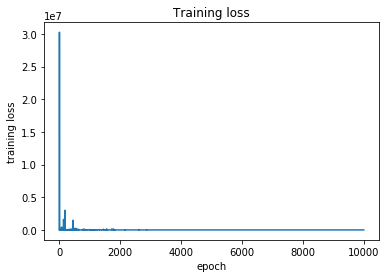

In [19]:
plt.plot(range(n_epochs), hist.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
y_test_pred_ae_list = [ae_model(X_test) for _ in range(n_test)]

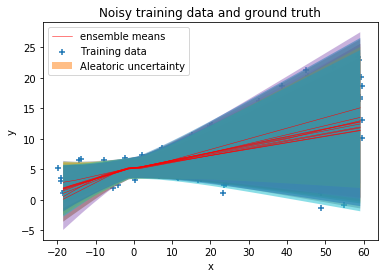

In [20]:
plt.scatter(X_train, y_train, marker='+', label='Training data')

avg_mean = np.zeros_like(X_test)
for i, y in enumerate(y_test_pred_ae_list):
    y_mean = y.mean()
    y_stddev = y.stddev()
    plt.plot(X_test, y_mean, 'r-', label='ensemble means' if i == 0 else None, linewidth=0.5)
    plt.fill_between(np.squeeze(X_test), 
                     np.squeeze(y_mean + 2 * y_stddev),
                     np.squeeze(y_mean - 2 * y_stddev),
                     alpha=0.5, label='Aleatoric uncertainty' if i == 0 else None)
    avg_mean += y_mean
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Uncertainties in CNNs

In [21]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

### Load MNIST dataset

Loading MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


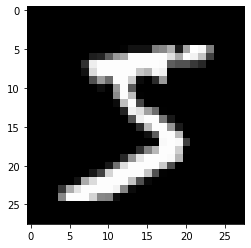

In [22]:
n_class = 10

batch_size = 128
n_epochs = 20
lr = 1e-3

print('Loading MNIST dataset')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')

### Define the kernel divergence function that comes with a weight

In [23]:
def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [24]:
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

### Build and train the Bayesian CNN model

In [25]:
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(10, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'])
bcnn_model.summary()
hist = bcnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1)

W0802 11:51:10.488073  9476 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\layers\util.py:103: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 14, 14, 32)        609       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 7, 7, 64)          36929     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0   

### Quantify the uncertainty in predictions

In [26]:
n_mc_run = 50
med_prob_thres = 0.2

y_pred_logits_list = [bcnn_model.predict(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9994
Unrecognizable samples: [1039 2293 3778 6572 6625 6651]
Test accuracy on MNIST (recognizable samples): 0.9881929157494497
Test accuracy on MNIST (unrecognizable samples): 0.16666666666666666


### Define the function that plots the histogram of predicted probabilities across all possible classes

In [27]:
def plot_pred_hist(y_pred, n_class, n_mc_run, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-30, 0, 31)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=(25, 10))
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                       np.median(y_pred[idx]),
                                                                       str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

### A recognizable example

True label of the test sample 0: 7


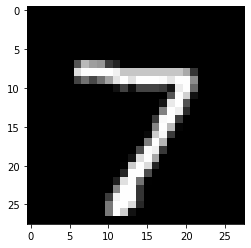

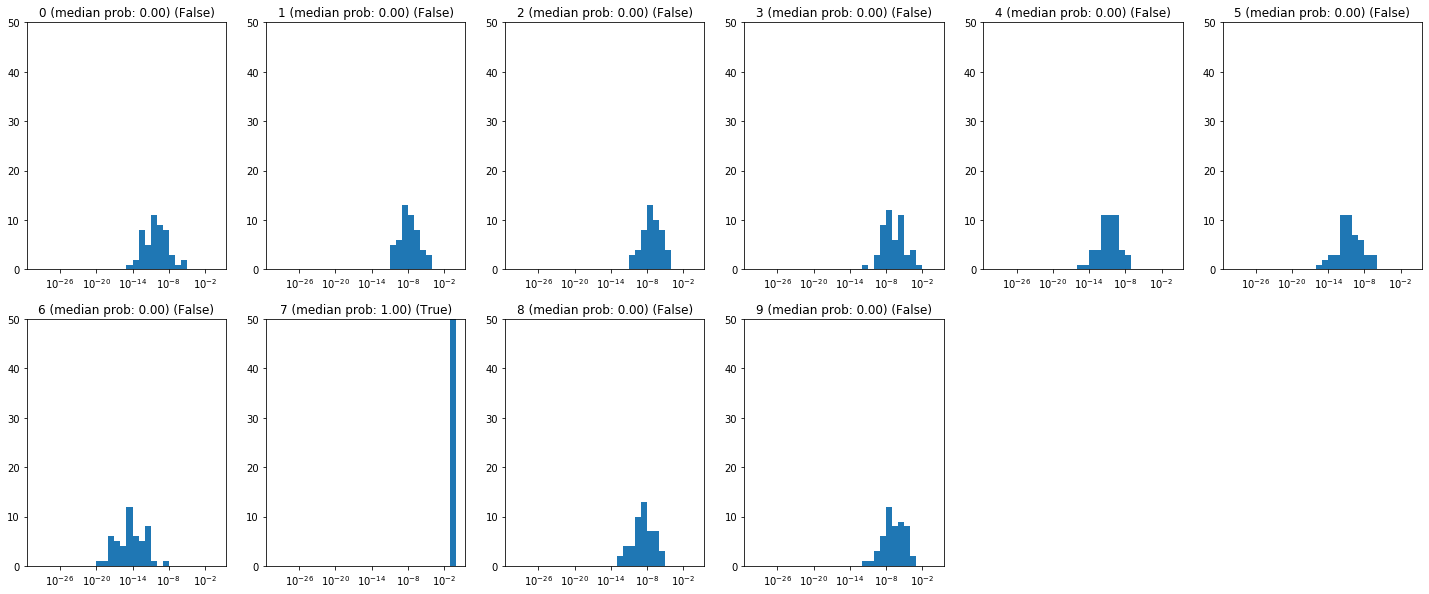

Predicted label of the test sample 0: 7


In [28]:
idx = 0
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

### An unrecognizable example

True label of the test sample 1039: 7


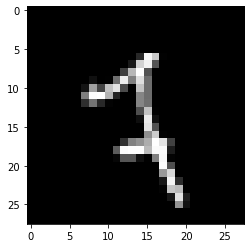

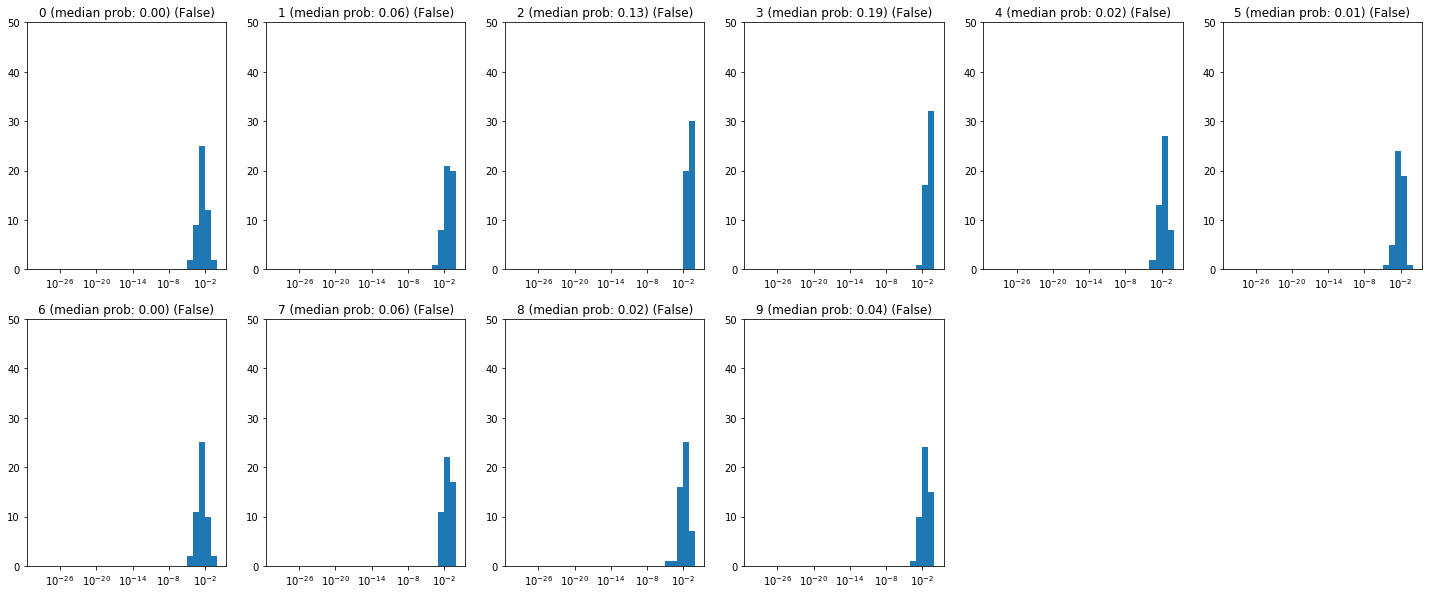

I don't know!


In [29]:
idx = np.where(idx_invalid)[0][0]
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

### Load Fashion-MNIST dataset

In [30]:
print('Loading Fashion-MNIST dataset')
_, (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_test = np.expand_dims(X_test, -1)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

Loading Fashion-MNIST dataset
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


### Quantify the uncertainty in predictions

In [31]:
y_pred_logits_list = [bcnn_model.predict(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 1225
Unrecognizable samples: [   1    2    3 ... 9997 9998 9999]
Test accuracy on MNIST (recognizable samples): 0.03428571428571429
Test accuracy on MNIST (unrecognizable samples): 0.11259259259259259


### An unrecognizable example

True label of the test sample 1: 2


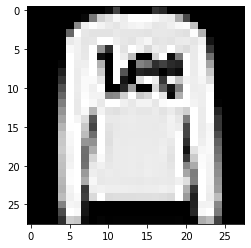

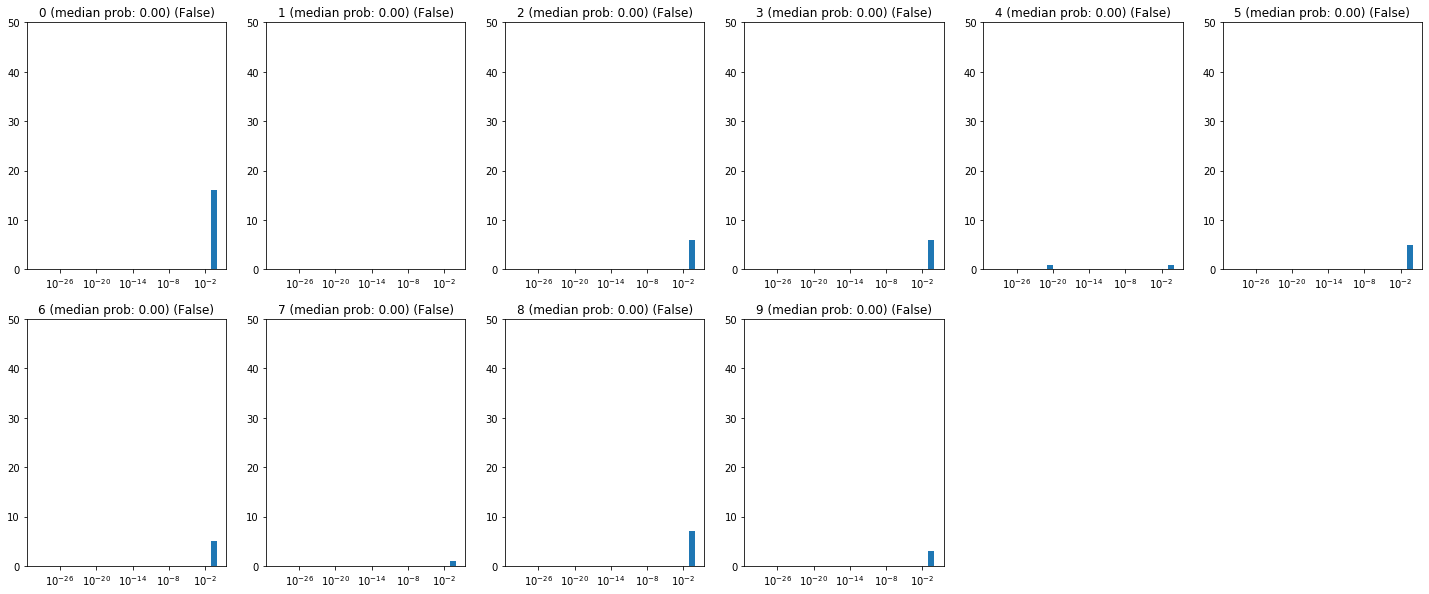

I don't know!


In [32]:
idx = np.where(idx_invalid)[0][0]
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")